In [1]:
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22)
matplotlib.rcParams["figure.facecolor"] = 'white'
matplotlib.rcParams["font.family"] = 'Times New Roman'
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib import cm
import numpy as np
import scipy.special
import scipy.optimize
from scipy.optimize import curve_fit
import unyt
from numba import njit
import h5py
import struct

import os,sys

import swiftsimio as sw
import woma
from woma.misc import utils, io
from woma.eos import tillotson, sesame, idg, hm80
from woma.eos.T_rho import T_rho
from woma.misc import glob_vars as gv
woma.load_eos_tables()

#this_dir, this_file = os.path.split(__file__)
#path = os.path.join(this_dir)
#sys.path.append(path)
#import gadget_sph

R_earth = gv.R_earth #6.371e6   # m
M_earth = gv.M_earth #5.9724e24  # kg 
G = 6.67408e-11  # m^3 kg^-1 s^-2
LEM=3.5E34 #AMof Earth-Moon system in mks

mant_mat_id = 403 #USER INPUT
core_mat_id = 402 #USER INPUT

def erfcfn(x, mFL, a, b):
    return mFL*scipy.special.erfc((x-a)/(b*np.sqrt(2)))

def arctanfn(x,a,b):
    return .5-np.arctan((x-a)/(b*np.pi))/(np.pi)

print(.5-np.arctan(100)/(np.pi))
markers=['o','P','x','*','^','s','p','h','v','D','d']

3.8.3
0.003182992764908188


In [2]:
# this cell has a java script that that enables hiding the raw python code
# test typing

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
def calcK(startProfile):
    [r0cgs,rho0cgs,T0,P0cgs,u0cgs,s0cgs,menclosedcgs,matID0]=np.loadtxt(startProfile,skiprows=1,unpack=True,delimiter=' ')
    r0=r0cgs/1.e2
    menclosed=menclosedcgs/1.e3
    Mt=menclosed[-1]
    Rt=r0[-1]
    Ishell=np.zeros(np.size(r0))
    for i in range(1,np.size(r0)):
        Ishell[i]=(2/5)*(menclosed[i]-menclosed[i-1])*(r0[i]**5-r0[i-1]**5)/(r0[i]**3-r0[i-1]**3)
    Itot=np.sum(Ishell,dtype='float64')
    K=Itot/Mt/(Rt**2)
    return K

In [4]:
def CMB_rubie(mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    return np.power(mcore*R_earth/(4/3*np.pi*rhocore*R_earth),1/3)

def P_rubie(r,rCMB,rplanet,mplanet,mcore,mmantle):
    rhomant = 1063.83*mplanet + 3436.17
    rhocore = 2.5*rhomant
    b = np.power(mcore/(4/3*np.pi*rhocore),1/3)
    a = np.power((mmantle+4/3*rhomant*np.pi*b**3)/(4/3*np.pi*rhomant),1/3)
    #a = np.power(mplanet*M_earth/(4/3*np.pi*(1-(rhomant/7/(rhocore/3+rhomant/7))*(rhocore-rhomant))),1/3)
    #b = rplanet*R_earth*np.power(4/7*rhomant/(4/3*rhocore + 4/7*rhomant),1/3)
    #a = rplanet*R_earth
    #b = rCMB*R_earth
    if (r<=a and r>=b):
        return 4/3*np.pi*rhomant*G*b**3*(rhocore-rhomant)*(1/r-1/a) + 2/3*np.pi*G*rhomant**2*(a**2-r**2)
    if (r>0 and r<b):
        return 2/3*np.pi*G*rhocore**2*(b**2-r**2) + 2/3*np.pi*G*rhomant**2*(a**2-b**2) + 4/3*np.pi*rhomant*G*b**3*(rhocore-rhomant)*(1/b-1/a)

def T_rubie(P):
    P=P/1.e9
    if P<24:
        return 1874 + 55.43*P - 1.74*P**2 + 0.0193*P**3
    if P>=24:
        return 1249 + 58.28*P - 0.395*P**2 + 0.0011*P**3

class simdata(object):
    def __init__(self,basename,label='',M_t=1,M_i=1,R_t=1,R_i=1,vi=1,theta=45,startProfile=''):
        self.basename=basename
        self.M_t = M_t
        self.M_i = M_i
        self.R_t = R_t
        self.R_i = R_i
        self.vi = vi
        self.theta = theta
        self.b=np.sin(self.theta*np.pi/180)
        self.B=(self.R_t+self.R_i)*np.sin(self.theta*np.pi/180)
        if os.path.isfile(basename+'_data.txt'):
            file_suffix='_data.txt'
        elif os.path.isfile(basename+'_data_last.txt'):
            file_suffix='_data_last.txt'
        [self.Lztot,
        self.Lzbnd,
        self.Lzplanet,
        self.Lzdisk,
        self.Lw0tot,
        self.Lw0bnd,
        self.Lw0planet,
        self.Lw0disk,
        self.Ntot,
        self.Nbound,
        self.Nplanet,
        self.Ndisk,
        self.Nmantle,
        self.Ncore,
        self.Mbound,
        self.Mplanet,
        self.Mdisk,
        self.Mmantle,
        self.Mcore,
        self.KEtot,
        self.KEbnd,
        self.KEplanet,
        self.KEdisk,
        self.KEmantle,
        self.KEcore,
        self.IEtot,
        self.IEbnd,
        self.IEplanet,
        self.IEdisk,
        self.IEmantle,
        self.IEcore,
        self.GPEtot,
        self.GPEbnd,
        self.GPEplanet,
        self.GPEdisk,
        self.GPEmantle,
        self.GPEcore,
        self.PGPEtot,
        self.PGPEbnd,
        self.PGPEplanet,
        self.PGPEdisk,
        self.PGPEmantle,
        self.PGPEcore,
        self.Etot,
        self.Ebnd,
        self.Eplanet,
        self.Edisk,
        self.Emantle,
        self.Ecore,
        self.Nh_maxtot,
        self.Nh_maxbound,
        self.Nlost,
        self.KElost,
        self.IElost,
        self.GPElost,
        self.PGPElost,
        self.Elost,
        self.Etot_adjusted,
        Etot0arr,
        Ntot0arr,
        self.time,
        GPEminarr] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_mantle_profiles.txt'):
            file_suffix='_mantle_profiles.txt'
        [self.RRRmant,
        self.RRR50mant,
        self.RRmant, 
        self.RR50mant,
        self.U25mant,
        self.U50mant,
        self.U75mant,
        self.Umeanmant,
        self.U25meanmant,
        self.U75meanmant,
        self.deltaU25mant,
        self.deltaU50mant,
        self.deltaU75mant,
        self.deltaUmeanmant,
        self.deltaU25meanmant,
        self.deltaU75meanmant,
        self.S25mant,
        self.S50mant,
        self.S75mant,
        self.Smeanmant,
        self.S25meanmant,
        self.S75meanmant,
        self.deltaS25mant,
        self.deltaS50mant,
        self.deltaS75mant,
        self.deltaSmeanmant,
        self.deltaS25meanmant,
        self.deltaS75meanmant,
        self.T25mant,
        self.T50mant,
        self.T75mant,
        self.Tmeanmant,
        self.T25meanmant,
        self.T75meanmant,
        self.deltaT25mant,
        self.deltaT50mant,
        self.deltaT75mant,
        self.deltaTmeanmant,
        self.deltaT25meanmant,
        self.deltaT75meanmant,
        self.P25mant,
        self.P50mant,
        self.P75mant,
        self.Pmeanmant,
        self.P25meanmant,
        self.P75meanmant,
        self.deltaP25mant,
        self.deltaP50mant,
        self.deltaP75mant,
        self.deltaPmeanmant,
        self.deltaP25meanmant,
        self.deltaP75meanmant,
        self.rho25mant,
        self.rho50mant,
        self.rho75mant,
        self.rhomeanmant,
        self.rho25meanmant,
        self.rho75meanmant] = np.loadtxt(basename+file_suffix,skiprows=3,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_core_profiles.txt'):
            file_suffix='_core_profiles.txt'
        [self.RRRcore,
        self.RRR50core,
        self.RRcore, 
        self.RR50core,
        self.U25core,
        self.U50core,
        self.U75core,
        self.Umeancore,
        self.U25meancore,
        self.U75meancore,
        self.deltaU25core,
        self.deltaU50core,
        self.deltaU75core,
        self.deltaUmeancore,
        self.deltaU25meancore,
        self.deltaU75meancore,
        self.S25core,
        self.S50core,
        self.S75core,
        self.Smeancore,
        self.S25meancore,
        self.S75meancore,
        self.deltaS25core,
        self.deltaS50core,
        self.deltaS75core,
        self.deltaSmeancore,
        self.deltaS25meancore,
        self.deltaS75meancore,
        self.T25core,
        self.T50core,
        self.T75core,
        self.Tmeancore,
        self.T25meancore,
        self.T75meancore,
        self.deltaT25core,
        self.deltaT50core,
        self.deltaT75core,
        self.deltaTmeancore,
        self.deltaT25meancore,
        self.deltaT75meancore,
        self.P25core,
        self.P50core,
        self.P75core,
        self.Pmeancore,
        self.P25meancore,
        self.P75meancore,
        self.deltaP25core,
        self.deltaP50core,
        self.deltaP75core,
        self.deltaPmeancore,
        self.deltaP25meancore,
        self.deltaP75meancore,
        self.rho25core,
        self.rho50core,
        self.rho75core,
        self.rhomeancore,
        self.rho25meancore,
        self.rho75meancore] = np.loadtxt(basename+file_suffix,skiprows=3,unpack=True,delimiter='|')
        corecore = np.where(self.RRRcore<self.RRRmant[0])
        if os.path.isfile(basename+'_miscibility.txt'):
            file_suffix='_miscibility.txt'
        [self.miscMtot,
        self.miscMmant,
        self.miscMcore,
        self.miscmantfrac,
        self.misccorefrac] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if os.path.isfile(basename+'_pressure_profiles.txt'):
            file_suffix='_pressure_profiles.txt'
        [self.radiusmeanPlist,
        self.P25profile,
        self.P50profile,
        self.P75profile,
        self.P25model,
        self.P50model,
        self.P75model] = np.loadtxt(basename+file_suffix,skiprows=1,unpack=True,delimiter='|')
        if (startProfile!='') & os.path.isfile(startProfile):
            [r0cgs,rho0cgs,self.T0,P0cgs,u0cgs,s0cgs,menclosed,matID0]=np.loadtxt(startProfile,skiprows=1,unpack=True,delimiter=' ')
            self.r0=r0cgs/1.e2
            self.rho0=rho0cgs*1.e3
            self.P0=P0cgs/10
            self.u0=u0cgs/1.e4
            self.s0=s0cgs/1.e4
            coreidx0=np.where(matID0==402)
            mantidx0=np.where(matID0==403)
            self.PCMB0=(self.P0[mantidx0][0]+self.P0[coreidx0][-1])/2
            self.TCMB0mant=self.T0[mantidx0][0]
            self.TCMB0core=self.T0[coreidx0][-1]
            self.K = calcK(startProfile)
            self.Lzstar=self.K*(self.M_t*M_earth)*(self.R_t*R_earth)**2*np.sqrt(G*(self.M_t*M_earth)/(self.R_t*R_earth)**3)/LEM
        self.P25profileCMB = self.P25profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.P50profileCMB = self.P50profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.P75profileCMB = self.P75profile[np.where(self.radiusmeanPlist<self.RRRmant[0])][-1]
        self.TCMB25 = self.T25mant[0]
        self.TCMB50 = self.T50mant[0]
        self.TCMB75 = self.T75mant[0]
        self.TCMBmean = self.Tmeanmant[0]
        self.TCMB25mean = self.T25meanmant[0]
        self.TCMB75mean = self.T75meanmant[0]
        self.PCMB25 = (self.P25mant[0]+self.P25core[corecore][-1])/2
        self.PCMB50 = (self.P50mant[0]+self.P50core[corecore][-1])/2
        self.PCMB75 = (self.P75mant[0]+self.P75core[corecore][-1])/2
        self.PCMBmean = (self.Pmeanmant[0]+self.Pmeancore[corecore][-1])/2
        self.PCMB25mean = (self.P25meanmant[0]+self.P25meancore[corecore][-1])/2
        self.PCMB75mean = (self.P75meanmant[0]+self.P75meancore[corecore][-1])/2
        self.CMBrubie = CMB_rubie(self.Mplanet[-1],self.Mcore[-1]*M_earth,(self.Mmantle[-1]+self.Mdisk[-1])*M_earth)
        self.P_CMBrubie = P_rubie(self.CMBrubie,self.CMBrubie,0,self.Mplanet[-1],self.Mcore[-1]*M_earth,(self.Mmantle[-1]+self.Mdisk[-1])*M_earth)
        self.T_CMBrubie = T_rubie(self.P_CMBrubie)
        self.Etot0 = Etot0arr[0]
        self.Ntot0 = Ntot0arr[0]
        self.GPEmin = GPEminarr[0]
        self.Nsnap = np.size(self.time)
        self.B_crit=self.R_t/(self.R_t+self.R_i)
        self.theta_crit=np.arcsin(self.R_t/(self.R_t+self.R_i))
        self.label=label
        self.QR = self.QRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.vi)
        self.QprimeR = self.QprimeRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QS = self.QSfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QstarprimeR = self.QstarprimeRfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QstarS = self.QstarSfn(self.M_t,self.M_i,self.R_t,self.R_i,self.theta)
        self.QSstandard = self.QSstandardfn(self.M_t,self.M_i,self.R_t,self.R_i)
        self.QstarSstandard = self.QSstandardfn(self.M_t,self.M_i,self.R_t,self.R_i,star=True)
        self.outcomemarker = 'o'
        anglelist = [0,10,20,30,45,60]
        for i in range(np.size(anglelist)):
            if self.theta==anglelist[i]:
                self.thetamarker=markers[i]
        mtarglist = [0.01,0.1,0.5,0.91]
        for i in range(np.size(mtarglist)):
            if np.abs(self.M_t-mtarglist[i])/mtarglist[i]<0.05:
                self.sizemarker=markers[i]
        mratiolist = [2,3,6]
        for i in range(np.size(mratiolist)):
            if np.abs((self.M_t/self.M_i)-mratiolist[i])/mratiolist[i]<0.05:
                self.ratiomarker=markers[i]
            
    def fP_T(self,fP):
        fracP = self.PCMBmean*fP
        fracR = self.radiusmeanPlist[np.where(self.Pmeanmant<fracP)][0]
        fracT = self.Tmeanmant[np.where(self.RRRmant>fracR)][0]
        return fracT
    
    def QRfn(self,M_t,M_i,R_t,R_i,Vi,):
        M_t = M_t*M_earth
        M_i = M_i*M_earth
        R_t = R_t * R_earth
        R_i = R_i * R_earth
        v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
        v_imp = Vi*v_esc
        Mtot = M_t+M_i
        mu = M_t*M_i/Mtot
        return 0.5*mu*v_imp**2/Mtot
    
    def QprimeRfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        mu = M_t*M_i/(M_t+M_i)
        return (mu/mua)*self.QR
    
    def QSfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        b=np.sin(theta)
        return self.QprimeR*(1+M_i/M_t)*(1-b)
    
    def QstarprimeRfn(self,M_t,M_i,R_t,R_i,theta):
        mubar = 0.35
        theta=theta*np.pi/180
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        mu = M_t*M_i/(M_t+M_i)
        return (mu/mua)**(2-3*mubar/2)*self.QR
    
    def QstarSfn(self,M_t,M_i,R_t,R_i,theta):
        theta=theta*np.pi/180
        b=np.sin(theta)
        return self.QstarprimeR*(1+M_i/M_t)*(1-b)
        
    def QSstandardfn(self,M_t,M_i,R_t,R_i,theta=30.,Vi=1.0,star=False):
        theta=theta*np.pi/180
        b=np.sin(theta)
        M_t = M_t*M_earth
        M_i = M_i*M_earth
        R_t = R_t * R_earth
        R_i = R_i * R_earth
        v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
        v_imp = Vi*v_esc
        Mtot = M_t+M_i
        mu = M_t*M_i/Mtot
        QR=0.5*mu*v_imp**2/Mtot
        B=(R_t+R_i)*np.sin(theta)
        l = R_t+R_i-B
        alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
        if l>=2*R_i:
            alpha=1
        mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
        QprimeR=(mu/mua)*QR
        if star:
            mubar = 0.35
            QstarprimeR=(mu/mua)**(2-3*mubar/2)*self.QR
            return QstarprimeR*(1+M_i/M_t)*(1-b)
        return QprimeR*(1+M_i/M_t)*(1-b)
    
def QS(M_t,M_i,R_t,R_i,Vi,theta):
    theta=theta*np.pi/180
    M_t = M_t*M_earth
    M_i = M_i*M_earth
    R_t = R_t * R_earth
    R_i = R_i * R_earth
    v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
    v_imp = Vi*v_esc
    Mtot = M_t+M_i
    mu = M_t*M_i/Mtot
    QR=0.5*mu*v_imp**2/Mtot
    B=(R_t+R_i)*np.sin(theta)
    l = R_t+R_i-B
    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
    if l>=2*R_i:
        alpha=1
    mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
    QprimeR=(mu/mua)*QR
    b=np.sin(theta)
    return QprimeR*(1+M_i/M_t)*(1-b)

def QS_theta_v(M_t,M_i,R_t,R_i,theta,Vi0,theta0):
    theta=theta*np.pi/180
    M_t = M_t*M_earth
    M_i = M_i*M_earth
    R_t = R_t * R_earth
    R_i = R_i * R_earth
    v_esc = np.sqrt(2 * G * (M_t + M_i) / (R_t + R_i))
    Mtot = M_t+M_i
    mu = M_t*M_i/Mtot
    QRnov=0.5*mu/Mtot
    B=(R_t+R_i)*np.sin(theta)
    l = R_t+R_i-B
    alpha=(3*R_i*l**2-l**3)/(4*R_i**3)
    if l>=2*R_i:
        alpha=1
    mua=(alpha*M_i*M_t)/(alpha*M_i+M_t)
    QprimeRnov=(mu/mua)*QRnov
    b=np.sin(theta)
    QSnov=QprimeRnov*(1+M_i/M_t)*(1-b)
    return np.sqrt(QS(M_t/M_earth,M_i/M_earth,R_t/R_earth,R_i/R_earth,Vi0,theta0)/QSnov)/v_esc

In [5]:
moon01x005v1th20 = simdata('./data/moon0.01x.005v1th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=20)
moon01x005v115th20 = simdata('./data/moon0.01x.005v1.15th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=20)
moon01x005v15th20 = simdata('./data/moon0.01x.005v1.5th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=20)
moon01x005v20th20 = simdata('./data/moon0.01x.005v2.0th20',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=20)
moon01x005th20list=[moon01x005v1th20,moon01x005v115th20,moon01x005v15th20,moon01x005v20th20]
moon01x005v1th30 = simdata('./data/moon0.01x.005v1th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=30)
moon01x005v115th30 = simdata('./data/moon0.01x.005v1.15th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=30)
moon01x005v15th30 = simdata('./data/moon0.01x.005v1.5th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=30)
moon01x005v20th30 = simdata('./data/moon0.01x.005v2.0th30',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=30)
moon01x005th30list=[moon01x005v1th30,moon01x005v115th30,moon01x005v15th30,moon01x005v20th30]
moon01x005th30list_nohnr=[moon01x005v1th30,moon01x005v115th30,moon01x005v15th30,moon01x005v20th30]
moon01x005v1th45 = simdata('./data/moon0.01x.005v1th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=45)
moon01x005v115th45 = simdata('./data/moon0.01x.005v1.15th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=45)
moon01x005v15th45 = simdata('./data/moon0.01x.005v1.5th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=45)
moon01x005v20th45 = simdata('./data/moon0.01x.005v2.0th45',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=45)
moon01x005th45list=[moon01x005v1th45,moon01x005v115th45,moon01x005v15th45,moon01x005v20th45]
moon01x005th45list_nohnr=[moon01x005v1th45,moon01x005v115th45,moon01x005v15th45,moon01x005v20th45]
moon01x005v1th60 = simdata('./data/moon0.01x.005v1th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1,theta=60)
moon01x005v115th60 = simdata('./data/moon0.01x.005v1.15th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=60)
moon01x005v15th60 = simdata('./data/moon0.01x.005v1.5th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.5,theta=60)
moon01x005v20th60 = simdata('./data/moon0.01x.005v2.0th60',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=2.0,theta=60)
moon01x005th60list=[moon01x005v1th60,moon01x005v115th60,moon01x005v15th60,moon01x005v20th60]
moon01x005th60list_nohnr=[moon01x005v1th60,moon01x005v115th60,moon01x005v15th60,moon01x005v20th60]
moon01x005v115th10 = simdata('./data/moon0.01x.005v1.15th10',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th10',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=10)
moon01x005v115th0 = simdata('./data/moon0.01x.005v1.15th0',startProfile='./data/M.01PyroSCmantleSMwarmN133_fulltension.txt',label='moon0.01x.005v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.196122884947418,M_i=0.004999976776505257,vi=1.15,theta=0)
moon01x005th010list=[moon01x005v115th10,moon01x005v115th0]
print('Target K: ',moon01x005v1th30.K)
print('Target L*: ',moon01x005v1th30.Lzstar)

Target K:  0.35533313214398515
Target L*:  0.0015185824583004233


In [6]:
mars01x05v1th0 = simdata('./data/mars0.1x.05v1th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=0)
mars01x05v115th0 = simdata('./data/mars0.1x.05v1.15th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=0)
mars01x05v15th0 = simdata('./data/mars0.1x.05v1.5th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=0)
mars01x05v20th0 = simdata('./data/mars0.1x.05v2.0th0',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=0)
mars01x05th0list=[mars01x05v1th0,mars01x05v115th0,mars01x05v15th0,mars01x05v20th0]
mars01x05v1th20 = simdata('./data/mars0.1x.05v1th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=20)
mars01x05v115th20 = simdata('./data/mars0.1x.05v1.15th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=20)
mars01x05v15th20 = simdata('./data/mars0.1x.05v1.5th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=20)
mars01x05v20th20 = simdata('./data/mars0.1x.05v2.0th20',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=20)
mars01x05th20list=[mars01x05v1th20,mars01x05v115th20,mars01x05v15th20,mars01x05v20th20]
mars01x05v1th30 = simdata('./data/mars0.1x.05v1th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=30)
mars01x05v115th30 = simdata('./data/mars0.1x.05v1.15th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=30)
mars01x05v145th30 = simdata('./data/mars0.1x.05v1.45th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.45th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.45,theta=30)
mars01x05v15th30 = simdata('./data/mars0.1x.05v1.5th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=30)
mars01x05v20th30 = simdata('./data/mars0.1x.05v2.0th30',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=30)
mars01x05th30list=[mars01x05v1th30,mars01x05v115th30,mars01x05v15th30,mars01x05v20th30,mars01x05v145th30]
mars01x05th30list_nohnr=[mars01x05v1th30,mars01x05v115th30,mars01x05v15th30,mars01x05v20th30]
mars01x05v1th45 = simdata('./data/mars0.1x.05v1th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=45)
mars01x05v115th45 = simdata('./data/mars0.1x.05v1.15th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=45)
mars01x05v135th45 = simdata('./data/mars0.1x.05v1.35th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.35th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.35,theta=45)
mars01x05v15th45 = simdata('./data/mars0.1x.05v1.5th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=45)
mars01x05v20th45 = simdata('./data/mars0.1x.05v2.0th45',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=45)
mars01x05th45list=[mars01x05v1th45,mars01x05v115th45,mars01x05v15th45,mars01x05v20th45,mars01x05v135th45]
mars01x05th45list_nohnr=[mars01x05v1th45,mars01x05v115th45,mars01x05v15th45] #,mars01x05v20th45]
mars01x05v1th60 = simdata('./data/mars0.1x.05v1th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1,theta=60)
mars01x05v105th60 = simdata('./data/mars0.1x.05v1.05th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.05th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.05,theta=60)
mars01x05v115th60 = simdata('./data/mars0.1x.05v1.15th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.15,theta=60)
mars01x05v15th60 = simdata('./data/mars0.1x.05v1.5th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=1.5,theta=60)
mars01x05v20th60 = simdata('./data/mars0.1x.05v2.0th60',startProfile='./data/M0.1PyroSCmantleSMwarmN133_fulltension.txt',label='mars0.1x.05v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.41534689216763465,M_i=0.050025178320273256,vi=2.0,theta=60)
mars01x05th60list=[mars01x05v1th60,mars01x05v115th60,mars01x05v15th60,mars01x05v20th60,mars01x05v105th60]
mars01x05th60list_nohnr=[mars01x05v1th60,mars01x05v115th60,mars01x05v15th60] #,mars01x05v20th60]
print('Target K: ',mars01x05v1th30.K)
print('Target L*: ',mars01x05v1th30.Lzstar)

Target K:  0.3467146991927441
Target L*:  0.0678766490582238


In [7]:
halfearth05x025v1th0 = simdata('./data/halfearth0.5x0.25v1th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=0)
halfearth05x025v115th0 = simdata('./data/halfearth0.5x0.25v1.15th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=0)
halfearth05x025v15th0 = simdata('./data/halfearth0.5x0.25v1.5th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=0)
halfearth05x025v20th0 = simdata('./data/halfearth0.5x0.25v2.0th0',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=0)
halfearth05x025th0list=[halfearth05x025v1th0,halfearth05x025v115th0,halfearth05x025v15th0,halfearth05x025v20th0]
halfearth05x025v1th20 = simdata('./data/halfearth0.5x0.25v1th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=20)
halfearth05x025v115th20 = simdata('./data/halfearth0.5x0.25v1.15th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=20)
halfearth05x025v15th20 = simdata('./data/halfearth0.5x0.25v1.5th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=20)
halfearth05x025v20th20 = simdata('./data/halfearth0.5x0.25v2.0th20',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=20)
halfearth05x025th20list=[halfearth05x025v1th20,halfearth05x025v115th20,halfearth05x025v15th20,halfearth05x025v20th20]
halfearth05x025v1th30 = simdata('./data/halfearth0.5x0.25v1th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=30)
halfearth05x025v115th30 = simdata('./data/halfearth0.5x0.25v1.15th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=30)
halfearth05x025v15th30 = simdata('./data/halfearth0.5x0.25v1.5th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=30)
halfearth05x025v20th30 = simdata('./data/halfearth0.5x0.25v2.0th30',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=30)
halfearth05x025th30list=[halfearth05x025v1th30,halfearth05x025v115th30,halfearth05x025v15th30,halfearth05x025v20th30]
halfearth05x025th30list_nohnr=[halfearth05x025v1th30,halfearth05x025v115th30,halfearth05x025v15th30] #,halfearth05x025v20th30]
halfearth05x025v1th45 = simdata('./data/halfearth0.5x0.25v1th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=45)
halfearth05x025v115th45 = simdata('./data/halfearth0.5x0.25v1.15th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=45)
halfearth05x025v15th45 = simdata('./data/halfearth0.5x0.25v1.5th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=45)
halfearth05x025v20th45 = simdata('./data/halfearth0.5x0.25v2.0th45',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2.0,theta=45)
halfearth05x025th45list=[halfearth05x025v1th45,halfearth05x025v115th45,halfearth05x025v15th45,halfearth05x025v20th45]
halfearth05x025th45list_nohnr=[halfearth05x025v1th45,halfearth05x025v115th45] #,halfearth05x025v15th45,halfearth05x025v20th45]
halfearth05x025v1th60 = simdata('./data/halfearth0.5x0.25v1th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1,theta=60)
halfearth05x025v115th60 = simdata('./data/halfearth0.5x0.25v1.15th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.15,theta=60)
halfearth05x025v15th60 = simdata('./data/halfearth0.5x0.25v1.5th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=1.5,theta=60)
halfearth05x025v20th60 = simdata('./data/halfearth0.5x0.25v2.0th60',startProfile='M0.5PyroSCwarmSMwarmN133_fulltension.txt',label='halfearth0.5x0.25v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6858380144404332,M_i=0.25007144364074746,vi=2,theta=60)
halfearth05x025th60list=[halfearth05x025v1th60,halfearth05x025v115th60,halfearth05x025v15th60,halfearth05x025v20th60]
halfearth05x025th60list_nohnr=[halfearth05x025v1th60,halfearth05x025v115th60] #,halfearth05x025v15th60,halfearth05x025v20th60]
print('Target K: ',halfearth05x025v1th30.K)
print('Target L*: ',halfearth05x025v1th30.Lzstar)

Target K:  0.3357305031317825
Target L*:  0.9385968191248246


In [8]:
print(halfearth05x025v1th0.P_CMBrubie/1.e9)
print(halfearth05x025v1th0.PCMB25/1.e9)
print(halfearth05x025v20th60.P_CMBrubie/1.e9)
print(halfearth05x025v20th60.PCMB25/1.e9)

96.08343232535225
74.87081421
68.37799948129465
65.29364787


In [9]:
protoearth091x0455v1th20 = simdata('./data/protoearth0.91x0.455v1th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=20)
protoearth091x0455v115th20 = simdata('./data/protoearth0.91x0.455v1.15th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=20)
protoearth091x0455v15th20 = simdata('./data/protoearth0.91x0.455v1.5th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=20)
protoearth091x0455v20th20 = simdata('./data/protoearth0.91x0.455v2.0th20',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=20)
protoearth091x0455th20list=[protoearth091x0455v1th20,protoearth091x0455v115th20,protoearth091x0455v15th20,protoearth091x0455v20th20]
protoearth091x0455v1th30 = simdata('./data/protoearth0.91x0.455v1th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=30)
protoearth091x0455v115th30 = simdata('./data/protoearth0.91x0.455v1.15th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=30)
protoearth091x0455v145th30 = simdata('./data/protoearth0.91x0.455v1.45th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.45th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.45,theta=30)
protoearth091x0455v15th30 = simdata('./data/protoearth0.91x0.455v1.5th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=30)
protoearth091x0455v20th30 = simdata('./data/protoearth0.91x0.455v2.0th30',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=30)
protoearth091x0455th30list=[protoearth091x0455v1th30,protoearth091x0455v115th30,protoearth091x0455v145th30,protoearth091x0455v15th30,protoearth091x0455v20th30]
protoearth091x0455th30list_nohr=[protoearth091x0455v1th30,protoearth091x0455v115th30,protoearth091x0455v15th30] #,protoearth091x0455v20th30]
protoearth091x0455v1th45 = simdata('./data/protoearth0.91x0.455v1th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=45)
protoearth091x0455v115th45 = simdata('./data/protoearth0.91x0.455v1.15th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=45)
protoearth091x0455v135th45 = simdata('./data/protoearth0.91x0.455v1.35th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.35th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.35,theta=45)
protoearth091x0455v15th45 = simdata('./data/protoearth0.91x0.455v1.5th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=45)
protoearth091x0455v20th45 = simdata('./data/protoearth0.91x0.455v2.0th45',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=45)
protoearth091x0455th45list=[protoearth091x0455v1th45,protoearth091x0455v115th45,protoearth091x0455v135th45,protoearth091x0455v15th45,protoearth091x0455v20th45]
protoearth091x0455th45list_nohnr=[protoearth091x0455v1th45,protoearth091x0455v115th45] #,protoearth091x0455v15th45,protoearth091x0455v20th45]
protoearth091x0455v1th60 = simdata('./data/protoearth0.91x0.455v1th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=60)
protoearth091x0455v105th60 = simdata('./data/protoearth0.91x0.455v1.05th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.05th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.05,theta=60)
protoearth091x0455v115th60 = simdata('./data/protoearth0.91x0.455v1.15th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=60)
protoearth091x0455v15th60 = simdata('./data/protoearth0.91x0.455v1.5th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=60)
protoearth091x0455v20th60 = simdata('./data/protoearth0.91x0.455v2.0th60',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=60)
protoearth091x0455th60list=[protoearth091x0455v1th60,protoearth091x0455v105th60,protoearth091x0455v115th60,protoearth091x0455v15th60,protoearth091x0455v20th60]
protoearth091x0455th60list_nohnr=[protoearth091x0455v1th60,protoearth091x0455v115th60] #,protoearth091x0455v15th60,protoearth091x0455v20th60
protoearth091x0455v1th0 = simdata('./data/protoearth0.91x0.455v1th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1,theta=0)
protoearth091x0455v115th0 = simdata('./data/protoearth0.91x0.455v1.15th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.15th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.15,theta=0)
protoearth091x0455v15th0 = simdata('./data/protoearth0.91x0.455v1.5th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v1.5th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=1.5,theta=0)
protoearth091x0455v20th0 = simdata('./data/protoearth0.91x0.455v2.0th0',startProfile='M0.91PyroSCwarmSMwarmN133_fulltension.txt',label='protoearth0.91x0.455v2.0th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.8202282231988699,M_i=0.45499484461857875,vi=2.0,theta=0)
protoearth091x0455th0list = [protoearth091x0455v1th0,protoearth091x0455v115th0,protoearth091x0455v15th0,protoearth091x0455v20th0]
print('Target K: ',protoearth091x0455v1th30.K)
print('Target L*: ',protoearth091x0455v1th30.Lzstar)

Target K:  0.33090117284196463
Target L*:  2.473883292514736


In [10]:
moon01x003v1th0 = simdata('./data/moon.01x.003v1th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=0)
moon01x003v115th0 = simdata('./data/moon.01x.003v1.15th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=0)
moon01x003v15th0 = simdata('./data/moon.01x.003v1.5th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=0)
moon01x003v20th0 = simdata('./data/moon.01x.003v2.0th0',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=0)
moon01x003th0list=[moon01x003v1th0,moon01x003v115th0,moon01x003v15th0,moon01x003v20th0]
moon01x003v1th20 = simdata('./data/moon.01x.003v1th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=20)
moon01x003v115th20 = simdata('./data/moon.01x.003v1.15th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=20)
moon01x003v15th20 = simdata('./data/moon.01x.003v1.5th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=20)
moon01x003v20th20 = simdata('./data/moon.01x.003v2.0th20',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=20)
moon01x003th20list=[moon01x003v1th20,moon01x003v115th20,moon01x003v15th20,moon01x003v20th20]
moon01x003v1th30 = simdata('./data/moon.01x.003v1th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=30)
moon01x003v115th30 = simdata('./data/moon.01x.003v1.15th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=30)
moon01x003v15th30 = simdata('./data/moon.01x.003v1.5th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=30)
moon01x003v20th30 = simdata('./data/moon.01x.003v2.0th30',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=30)
moon01x003th30list=[moon01x003v1th30,moon01x003v115th30,moon01x003v15th30,moon01x003v20th30]
moon01x003th30list_nohnr=[moon01x003v1th30,moon01x003v115th30,moon01x003v15th30,moon01x003v20th30]
moon01x003v1th45 = simdata('./data/moon.01x.003v1th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=45)
moon01x003v115th45 = simdata('./data/moon.01x.003v1.15th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=45)
moon01x003v15th45 = simdata('./data/moon.01x.003v1.5th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=45)
moon01x003v20th45 = simdata('./data/moon.01x.003v2.0th45',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=45)
moon01x003th45list=[moon01x003v1th45,moon01x003v115th45,moon01x003v15th45,moon01x003v20th45]
moon01x003th45list_nohnr=[moon01x003v1th45,moon01x003v115th45,moon01x003v15th45,moon01x003v20th45]
moon01x003v1th60 = simdata('./data/moon.01x.003v1th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1,theta=60)
moon01x003v115th60 = simdata('./data/moon.01x.003v1.15th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.15,theta=60)
moon01x003v15th60 = simdata('./data/moon.01x.003v1.5th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=1.5,theta=60)
moon01x003v20th60 = simdata('./data/moon.01x.003v2.0th60',startProfile='M.01PyroSCmantleSMwarmN150_fulltension.txt',label='moon.01x.003v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.17153902527075815,M_i=0.0033328373518183648,vi=2.0,theta=60)
moon01x003th60list=[moon01x003v1th60,moon01x003v115th60,moon01x003v15th60,moon01x003v20th60]
moon01x003th60list_nohnr=[moon01x003v1th60,moon01x003v115th60,moon01x003v15th60,moon01x003v20th60]
print('Target K: ',moon01x003v1th30.K)
print('Target L*: ',moon01x003v1th30.Lzstar)

Target K:  0.35533313214398515
Target L*:  0.0015185824583004233


In [11]:
mars01x03v1th0 = simdata('./data/mars0.1x.03v1th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=0)
mars01x03v115th0 = simdata('./data/mars0.1x.03v1.15th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=0)
mars01x03v15th0 = simdata('./data/mars0.1x.03v1.5th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=0)
mars01x03v20th0 = simdata('./data/mars0.1x.03v2.0th0',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th0',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=0)
mars01x03th0list=[mars01x03v1th0,mars01x03v115th0,mars01x03v15th0,mars01x03v20th0]
mars01x03v1th20 = simdata('./data/mars0.1x.03v1th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=20)
mars01x03v115th20 = simdata('./data/mars0.1x.03v1.15th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=20)
mars01x03v15th20 = simdata('./data/mars0.1x.03v1.5th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=20)
mars01x03v20th20 = simdata('./data/mars0.1x.03v2.0th20',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th20',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=20)
mars01x03th20list=[mars01x03v1th20,mars01x03v115th20,mars01x03v15th20,mars01x03v20th20]
mars01x03v1th30 = simdata('./data/mars0.1x.03v1th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=30)
mars01x03v115th30 = simdata('./data/mars0.1x.03v1.15th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=30)
mars01x03v15th30 = simdata('./data/mars0.1x.03v1.5th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=30)
mars01x03v20th30 = simdata('./data/mars0.1x.03v2.0th30',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=30)
mars01x03th30list=[mars01x03v1th30,mars01x03v115th30,mars01x03v15th30,mars01x03v20th30]
mars01x03th30list_nohnr=[mars01x03v1th30,mars01x03v115th30,mars01x03v15th30,mars01x03v20th30]
mars01x03v1th45 = simdata('./data/mars0.1x.03v1th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=45)
mars01x03v115th45 = simdata('./data/mars0.1x.03v1.15th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=45)
mars01x03v15th45 = simdata('./data/mars0.1x.03v1.5th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=45)
mars01x03v20th45 = simdata('./data/mars0.1x.03v2.0th45',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=45)
mars01x03th45list=[mars01x03v1th45,mars01x03v115th45,mars01x03v15th45,mars01x03v20th45]
mars01x03th45list_nohnr=[mars01x03v1th45,mars01x03v115th45,mars01x03v15th45] #,mars01x03v20th45]
mars01x03v1th60 = simdata('./data/mars0.1x.03v1th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1,theta=60)
mars01x03v115th60 = simdata('./data/mars0.1x.03v1.15th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.15,theta=60)
mars01x03v15th60 = simdata('./data/mars0.1x.03v1.5th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=1.5,theta=60)
mars01x03v20th60 = simdata('./data/mars0.1x.03v2.0th60',startProfile='M0.1PyroSCmantleSMwarmN150_fulltension.txt',label='mars0.1x.03v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.36451458954638205,M_i=0.03332227848101266,vi=2.0,theta=60)
mars01x03th60list=[mars01x03v1th60,mars01x03v115th60,mars01x03v15th60,mars01x03v20th60]
mars01x03th60list_nohnr=[mars01x03v1th60,mars01x03v115th60,mars01x03v15th60] #,mars01x03v20th60]
print('Target K: ',mars01x03v1th30.K)
print('Target L*: ',mars01x03v1th30.Lzstar)

Target K:  0.3467146991927441
Target L*:  0.0678766490582238


In [12]:
halfearth05x017v1th0=simdata('./data/halfearth0.5x0.17v1th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=0)
halfearth05x017v115th0=simdata('./data/halfearth0.5x0.17v1.15th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=0)
halfearth05x017v15th0=simdata('./data/halfearth0.5x0.17v1.5th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=0)
halfearth05x017v20th0=simdata('./data/halfearth0.5x0.17v2.0th0',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th0',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=0)
halfearth05x017th0list=[halfearth05x017v1th0,halfearth05x017v115th0,halfearth05x017v15th0,halfearth05x017v20th0]
halfearth05x017v1th20=simdata('./data/halfearth0.5x0.17v1th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=20)
halfearth05x017v115th20=simdata('./data/halfearth0.5x0.17v1.15th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=20)
halfearth05x017v15th20=simdata('./data/halfearth0.5x0.17v1.5th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=20)
halfearth05x017v20th20=simdata('./data/halfearth0.5x0.17v2.0th20',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th20',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=20)
halfearth05x017th20list=[halfearth05x017v1th20,halfearth05x017v115th20,halfearth05x017v15th20,halfearth05x017v20th20]
halfearth05x017v1th30=simdata('./data/halfearth0.5x0.17v1th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=30)
halfearth05x017v115th30=simdata('./data/halfearth0.5x0.17v1.15th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=30)
halfearth05x017v15th30=simdata('./data/halfearth0.5x0.17v1.5th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=30)
halfearth05x017v20th30=simdata('./data/halfearth0.5x0.17v2.0th30',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=30)
halfearth05x017th30list=[halfearth05x017v1th30,halfearth05x017v115th30,halfearth05x017v15th30,halfearth05x017v20th30]
halfearth05x017th30list_nohnr=[halfearth05x017v1th30,halfearth05x017v115th30,halfearth05x017v15th30] #,halfearth05x017v20th30]
halfearth05x017v1th45=simdata('./data/halfearth0.5x0.17v1th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=45)
halfearth05x017v115th45=simdata('./data/halfearth0.5x0.17v1.15th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=45)
halfearth05x017v15th45=simdata('./data/halfearth0.5x0.17v1.5th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=45)
halfearth05x017v20th45=simdata('./data/halfearth0.5x0.17v2.0th45',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=45)
halfearth05x017th45list=[halfearth05x017v1th45,halfearth05x017v115th45,halfearth05x017v15th45,halfearth05x017v20th45]
halfearth05x017th45list_nohnr=[halfearth05x017v1th45,halfearth05x017v115th45] #,halfearth05x017v15th45] #,halfearth05x017v20th45]
halfearth05x017v1th60=simdata('./data/halfearth0.5x0.17v1th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1,theta=60)
halfearth05x017v115th60=simdata('./data/halfearth0.5x0.17v1.15th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.15,theta=60)
halfearth05x017v15th60=simdata('./data/halfearth0.5x0.17v1.5th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=1.5,theta=60)
halfearth05x017v20th60=simdata('./data/halfearth0.5x0.17v2.0th60',startProfile='M0.5PyroSCwarmSMwarmN150_fulltension.txt',label='halfearth0.5x0.17v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.6058557086799561,M_i=0.16672166683410355,vi=2.0,theta=60)
halfearth05x017th60list=[halfearth05x017v1th60,halfearth05x017v115th60,halfearth05x017v15th60,halfearth05x017v20th60]
halfearth05x017th60list_nohnr=[halfearth05x017v1th60,halfearth05x017v115th60] #,halfearth05x017v15th60,halfearth05x017v20th60]
print('Target K: ',halfearth05x017v1th30.K)
print('Target L*: ',halfearth05x017v1th30.Lzstar)

Target K:  0.3357305031317825
Target L*:  0.9385968191248246


In [13]:
protoearth091x03v1th0=simdata('./data/protoearth0.91x0.3v1th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=0)
protoearth091x03v115th0=simdata('./data/protoearth0.91x0.3v1.15th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=0)
protoearth091x03v15th0=simdata('./data/protoearth0.91x0.3v1.5th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=0)
protoearth091x03v20th0=simdata('./data/protoearth0.91x0.3v2.0th0',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th0',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=0)
protoearth091x03th0list=[protoearth091x03v1th0,protoearth091x03v115th0,protoearth091x03v15th0,protoearth091x03v20th0]
protoearth091x03v1th20=simdata('./data/protoearth0.91x0.3v1th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=20)
protoearth091x03v115th20=simdata('./data/protoearth0.91x0.3v1.15th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=20)
protoearth091x03v15th20=simdata('./data/protoearth0.91x0.3v1.5th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=20)
protoearth091x03v20th20=simdata('./data/protoearth0.91x0.3v2.0th20',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th20',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=20)
protoearth091x03th20list=[protoearth091x03v1th20,protoearth091x03v115th20,protoearth091x03v15th20,protoearth091x03v20th20]
protoearth091x03v1th30=simdata('./data/protoearth0.91x0.3v1th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=30)
protoearth091x03v115th30=simdata('./data/protoearth0.91x0.3v1.15th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=30)
protoearth091x03v15th30=simdata('./data/protoearth0.91x0.3v1.5th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=30)
protoearth091x03v20th30=simdata('./data/protoearth0.91x0.3v2.0th30',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=30)
protoearth091x03th30list=[protoearth091x03v1th30,protoearth091x03v115th30,protoearth091x03v15th30,protoearth091x03v20th30]
protoearth091x03th30list_nohnr=[protoearth091x03v1th30,protoearth091x03v115th30,protoearth091x03v15th30] #,protoearth091x03v20th30]
protoearth091x03v1th45=simdata('./data/protoearth0.91x0.3v1th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=45)
protoearth091x03v115th45=simdata('./data/protoearth0.91x0.3v1.15th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=45)
protoearth091x03v15th45=simdata('./data/protoearth0.91x0.3v1.5th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=45)
protoearth091x03v20th45=simdata('./data/protoearth0.91x0.3v2.0th45',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=45)
protoearth091x03th45list=[protoearth091x03v1th45,protoearth091x03v115th45,protoearth091x03v15th45,protoearth091x03v20th45]
protoearth091x03th45list_nohnr=[protoearth091x03v1th45,protoearth091x03v115th45,protoearth091x03v15th45] #,protoearth091x03v20th45]
protoearth091x03v1th60=simdata('./data/protoearth0.91x0.3v1th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1,theta=60)
protoearth091x03v115th60=simdata('./data/protoearth0.91x0.3v1.15th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.15,theta=60)
protoearth091x03v15th60=simdata('./data/protoearth0.91x0.3v1.5th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=1.5,theta=60)
protoearth091x03v20th60=simdata('./data/protoearth0.91x0.3v2.0th60',startProfile='M0.91PyroSCwarmSMwarmN150_fulltension.txt',label='protoearth0.91x0.3v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.7269859001726573,M_i=0.303408095572969,vi=2.0,theta=60)
protoearth091x03th60list=[protoearth091x03v1th60,protoearth091x03v115th60,protoearth091x03v15th60,protoearth091x03v20th60]
protoearth091x03th60list_nohnr=[protoearth091x03v1th60,protoearth091x03v115th60] #,protoearth091x03v15th60,protoearth091x03v20th60]
print('Target K: ',protoearth091x03v1th30.K)
print('Target L*: ',protoearth091x03v1th30.Lzstar)

Target K:  0.33090117284196463
Target L*:  2.473883292514736


In [14]:
moon01x0017v1th0=simdata('./data/moon.01x.0017v1th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=0)
moon01x0017v115th0=simdata('./data/moon.01x.0017v1.15th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=0)
moon01x0017v15th0=simdata('./data/moon.01x.0017v1.5th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=0)
moon01x0017v20th0=simdata('./data/moon.01x.0017v2.0th0',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th0',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=0)
moon01x0017th0list = [moon01x0017v115th0,moon01x0017v15th0,moon01x0017v20th0]
moon01x0017v1th20=simdata('./data/moon.01x.0017v1th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=20)
moon01x0017v115th20=simdata('./data/moon.01x.0017v1.15th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=20)
moon01x0017v15th20=simdata('./data/moon.01x.0017v1.5th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=20)
moon01x0017v20th20=simdata('./data/moon.01x.0017v2.0th20',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th20',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=20)
moon01x0017th20list = [moon01x0017v1th20,moon01x0017v115th20,moon01x0017v15th20,moon01x0017v20th20]
moon01x0017v1th30=simdata('./data/moon.01x.0017v1th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=30)
moon01x0017v115th30=simdata('./data/moon.01x.0017v1.15th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=30)
moon01x0017v15th30=simdata('./data/moon.01x.0017v1.5th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=30)
moon01x0017v20th30=simdata('./data/moon.01x.0017v2.0th30',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th30',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=30)
moon01x0017th30list = [moon01x0017v1th30,moon01x0017v115th30,moon01x0017v15th30,moon01x0017v20th30]
moon01x0017th30list_nohnr = [moon01x0017v1th30,moon01x0017v115th30,moon01x0017v15th30,moon01x0017v20th30]
moon01x0017v1th45=simdata('./data/moon.01x.0017v1th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=45)
moon01x0017v115th45=simdata('./data/moon.01x.0017v1.15th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=45)
moon01x0017v15th45=simdata('./data/moon.01x.0017v1.5th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=45)
moon01x0017v20th45=simdata('./data/moon.01x.0017v2.0th45',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th45',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=45)
moon01x0017th45list = [moon01x0017v1th45,moon01x0017v115th45,moon01x0017v15th45,moon01x0017v20th45]
moon01x0017th45list_nohnr = [moon01x0017v1th45,moon01x0017v115th45,moon01x0017v15th45,moon01x0017v20th45]
moon01x0017v1th60=simdata('./data/moon.01x.0017v1th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1,theta=60)
moon01x0017v115th60=simdata('./data/moon.01x.0017v1.15th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.15th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.15,theta=60)
moon01x0017v15th60=simdata('./data/moon.01x.0017v1.5th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v1.5th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=1.5,theta=60)
moon01x0017v20th60=simdata('./data/moon.01x.0017v2.0th60',startProfile='M.01PyroSCmantleSMwarmN171_fulltension.txt',label='moon.01x.0017v2.0th60',R_t=0.24646038455501493,M_t=0.010007283755274262,R_i=0.1363740857008319,M_i=0.001667078114325899,vi=2.0,theta=60)
moon01x0017th60list = [moon01x0017v1th60,moon01x0017v115th60,moon01x0017v15th60,moon01x0017v20th60]
moon01x0017th60list_nohnr = [moon01x0017v1th60,moon01x0017v115th60,moon01x0017v15th60,moon01x0017v20th60]
print('Target K: ',moon01x0017v1th30.K)
print('Target L*: ',moon01x0017v1th30.Lzstar)

Target K:  0.35533313214398515
Target L*:  0.0015185824583004233


In [15]:
mars01x017v1th30=simdata('./data/mars0.1x.017v1th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=30)
mars01x017v115th30=simdata('./data/mars0.1x.017v1.15th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=30)
mars01x017v15th30=simdata('./data/mars0.1x.017v1.5th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=30)
mars01x017v20th30=simdata('./data/mars0.1x.017v2.0th30',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th30',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=30)
mars01x017th30list=[mars01x017v1th30,mars01x017v115th30,mars01x017v15th30,mars01x017v20th30]
mars01x017th30list_nohnr=[mars01x017v1th30,mars01x017v115th30,mars01x017v15th30,mars01x017v20th30]
mars01x017v1th45=simdata('./data/mars0.1x.017v1th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=45)
mars01x017v115th45=simdata('./data/mars0.1x.017v1.15th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=45)
mars01x017v15th45=simdata('./data/mars0.1x.017v1.5th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=45)
mars01x017v20th45=simdata('./data/mars0.1x.017v2.0th45',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th45',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=45)
mars01x017th45list=[mars01x017v1th45,mars01x017v115th45,mars01x017v15th45,mars01x017v20th45]
mars01x017th45list_nohnr=[mars01x017v1th45,mars01x017v115th45,mars01x017v15th45,mars01x017v20th45]
mars01x017v1th60=simdata('./data/mars0.1x.017v1th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1,theta=60)
mars01x017v115th60=simdata('./data/mars0.1x.017v1.15th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.15th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.15,theta=60)
mars01x017v15th60=simdata('./data/mars0.1x.017v1.5th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v1.5th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=1.5,theta=60)
mars01x017v20th60=simdata('./data/mars0.1x.017v2.0th60',startProfile='M0.1PyroSCmantleSMwarmN171_fulltension.txt',label='mars0.1x.017v2.0th60',R_t=0.5172520844451421,M_t=0.10006790670417252,R_i=0.29133816355360226,M_i=0.01668026595673431,vi=2.0,theta=60)
mars01x017th60list=[mars01x017v1th60,mars01x017v115th60,mars01x017v15th60,mars01x017v20th60]
mars01x017th60list_nohnr=[mars01x017v1th60,mars01x017v115th60,mars01x017v15th60,mars01x017v20th60]
print('Target K: ',mars01x017v1th30.K)
print('Target L*: ',mars01x017v1th30.Lzstar)

Target K:  0.3467146991927441
Target L*:  0.0678766490582238


In [16]:
halfearth05x08v1th30=simdata('./data/halfearth0.5x.08v1th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=30)
halfearth05x08v115th30=simdata('./data/halfearth0.5x.08v1.15th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=30)
halfearth05x08v15th30=simdata('./data/halfearth0.5x.08v1.5th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=30)
halfearth05x08v20th30=simdata('./data/halfearth0.5x.08v2.0th30',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th30',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=30)
halfearth05x08th30list=[halfearth05x08v1th30,halfearth05x08v115th30,halfearth05x08v15th30,halfearth05x08v20th30]
halfearth05x08th30list_nohnr=[halfearth05x08v1th30,halfearth05x08v115th30,halfearth05x08v15th30,halfearth05x08v20th30]
halfearth05x08v1th45=simdata('./data/halfearth0.5x.08v1th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=45)
halfearth05x08v115th45=simdata('./data/halfearth0.5x.08v1.15th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=45)
halfearth05x08v15th45=simdata('./data/halfearth0.5x.08v1.5th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=45)
halfearth05x08v20th45=simdata('./data/halfearth0.5x.08v2.0th45',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th45',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=45)
halfearth05x08th45list=[halfearth05x08v1th45,halfearth05x08v115th45,halfearth05x08v15th45,halfearth05x08v20th45]
halfearth05x08th45list_nohnr=[halfearth05x08v1th45,halfearth05x08v115th45,halfearth05x08v15th45,halfearth05x08v20th45]
halfearth05x08v1th60=simdata('./data/halfearth0.5x.08v1th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1,theta=60)
halfearth05x08v115th60=simdata('./data/halfearth0.5x.08v1.15th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.15th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.15,theta=60)
halfearth05x08v15th60=simdata('./data/halfearth0.5x.08v1.5th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v1.5th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=1.5,theta=60)
halfearth05x08v20th60=simdata('./data/halfearth0.5x.08v2.0th60',startProfile='M0.5PyroSCwarmSMwarmN171_fulltension.txt',label='halfearth0.5x.08v2.0th60',R_t=0.8434668074085702,M_t=0.5004180781595339,R_i=0.4884051090880553,M_i=0.08336844585091421,vi=2.0,theta=60)
halfearth05x08th60list=[halfearth05x08v1th60,halfearth05x08v115th60,halfearth05x08v15th60,halfearth05x08v20th60]
halfearth05x08th60list_nohnr=[halfearth05x08v1th60,halfearth05x08v115th60,halfearth05x08v15th60] #,halfearth05x08v20th60]
print('Target K: ',halfearth05x08v1th30.K)
print('Target L*: ',halfearth05x08v1th30.Lzstar)

Target K:  0.3357305031317825
Target L*:  0.9385968191248246


In [17]:
protoearth091x015v1th30=simdata('./data/protoearth0.91x0.15v1th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=30)
protoearth091x015v115th30=simdata('./data/protoearth0.91x0.15v1.15th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=30)
protoearth091x015v15th30=simdata('./data/protoearth0.91x0.15v1.5th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=30)
protoearth091x015v20th30=simdata('./data/protoearth0.91x0.15v2.0th30',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th30',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=30)
protoearth091x015th30list=[protoearth091x015v1th30,protoearth091x015v115th30,protoearth091x015v15th30,protoearth091x015v20th30]
protoearth091x015v1th45=simdata('./data/protoearth0.91x0.15v1th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=45)
protoearth091x015v115th45=simdata('./data/protoearth0.91x0.15v1.15th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=45)
protoearth091x015v15th45=simdata('./data/protoearth0.91x0.15v1.5th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=45)
protoearth091x015v20th45=simdata('./data/protoearth0.91x0.15v2.0th45',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th45',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=45)
protoearth091x015th45list=[protoearth091x015v1th45,protoearth091x015v115th45,protoearth091x015v15th45,protoearth091x015v20th45]
protoearth091x015v1th60=simdata('./data/protoearth0.91x0.15v1th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1,theta=60)
protoearth091x015v115th60=simdata('./data/protoearth0.91x0.15v1.15th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.15th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.15,theta=60)
protoearth091x015v15th60=simdata('./data/protoearth0.91x0.15v1.5th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v1.5th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=1.5,theta=60)
protoearth091x015v20th60=simdata('./data/protoearth0.91x0.15v2.0th60',startProfile='M0.91PyroSCwarmSMwarmN171_fulltension.txt',label='protoearth0.91x0.15v2.0th60',R_t=1.002639835190708,M_t=0.9101278849373786,R_i=0.5886796327107204,M_i=0.1517723913334673,vi=2.0,theta=60)
protoearth091x015th60list=[protoearth091x015v1th60,protoearth091x015v115th60,protoearth091x015v15th60,protoearth091x015v20th60]
print('Target K: ',protoearth091x015v1th30.K)
print('Target L*: ',protoearth091x015v1th30.Lzstar)

Target K:  0.33090117284196463
Target L*:  2.473883292514736


In [18]:
markerlist=['o','P','x','*','^','s','p','h','v','D','d']
prop_cycle = plt.rcParams['axes.prop_cycle']
colorlist = prop_cycle.by_key()['color']

def PTrubie_plot(simlistlist,labels=None):
    fig1,ax = plt.subplots(1, 1, figsize=(18,10))
    for j in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[j]
        #QprimeRs=np.zeros(np.size(simlist))
        #IEplanets=np.zeros(np.size(simlist))
        for i in range(np.size(simlist)):
            sim = simlist[i]
            #print(sim.Mcore[-1],sim.Mmantle[-1]+sim.Mdisk[-1])
            #ax.plot(sim.radiusmeanPlist/R_earth,vP_rubie(sim.radiusmeanPlist, rCMB, rplanet, mtot/M_earth,mcore,mmant)/1.e9,color='black',label='T&S model',lw=3)
            #ax.scatter(sim.CMBrubie/R_earth,sim.P_CMBrubie/1.e9,s=60,label='T&S model CMB')
            if labels is not None:
                #ax.plot(sim.radiusmeanPlist/sim.RRRmant[0],sim.P25profile/1.e9,lw=1,label=labels[j])
                if i==0:
                    labelstring=labels[j]
                else:
                    labelstring=None
            else:
                labelstring=sim.label
                #ax.plot(sim.radiusmeanPlist/sim.RRRmant[0],sim.P25profile/1.e9,lw=1,label=sim.label)
            ax.plot(sim.radiusmeanPlist/sim.RRRmant[0],sim.P25profile/sim.P25profile[0],lw=1,label=labelstring)
            #ax.plot(sim.radiusmeanPlist/R_earth,sim.P50profile/1.e9,'--',lw=1)
            #ax.plot(sim.radiusmeanPlist/R_earth,sim.P75profile/1.e9,'--',lw=1,color='lime')
    #ax.set_xlabel(r"R $[R_\oplus]$")
    ax.set_xlabel('R fraction of CMB')
    ax.set_ylabel('Pressure P [GPa]')
    ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    ax.set_xlim(0,2.0)
    ax.tick_params(axis='both', which='both', labelsize=20)
    plt.show()

#PTrubie_plot(np.array([[mars01x03v115th45,mars01x03v15th45,mars01x03v20th45]]))

In [19]:
def conservation_plot(simlist):
    fig1,ax = plt.subplots(3, 1, figsize=(10,18))
    for i in range(np.size(simlist)):
        sim = simlist[i]
        ax[0].plot(sim.time/3600,sim.Etot_adjusted/sim.Etot0,label=sim.label+' (corrected for lost particles)')
        #ax[0].plot(timelist[i]/3600,Etotlist[i]/Etot0list[i],label=runlist[i]['label']+' (unadjusted)',ls='--')
    ax[0].set_xlabel('time (hours)')
    ax[0].set_ylabel('Fraction of total initial energy')
    ax[0].legend(fontsize=8)
    ax[0].set_title('Total energy conservation')

    for i in range(np.size(simlist)):
        sim = simlist[i]
        ax[1].plot(sim.time/3600,(sim.Nh_maxtot)/sim.Ntot0,label=sim.label+' total h_max particles')
        ax[1].plot(sim.time/3600,(sim.Nlost)/sim.Ntot0,label=sim.label+' total lost particles',ls='--')
    ax[1].set_xlabel('time (hours)')
    ax[1].set_ylabel('Fraction of particles')
    ax[1].legend(fontsize=8)
    ax[1].set_title('Particles lost or at density floor')

    for i in range(np.size(simlist)):
        sim = simlist[i]
        ax[2].plot(sim.time/3600,sim.Nlost/sim.Ntot0,label=sim.label+' lost particles',ls='--')
        ax[2].plot(sim.time/3600,(sim.Nh_maxtot-sim.Nh_maxbound)/sim.Ntot0,label=sim.label+' unbound h_max particles',ls='-.')
        ax[2].plot(sim.time/3600,(sim.Nh_maxbound)/sim.Ntot0,label=sim.label+' bound h_max particles',ls=':')
    ax[2].set_xlabel('time (hours)')
    ax[2].set_ylabel('Fraction of particles')
    ax[2].legend(fontsize=8)
    ax[2].set_title('Particles lost or at density floor')

    #imname = dir+'energy_conservation.png'
    plt.tight_layout()
    #plt.savefig(imname, dpi=100)
    #print('Saved image: ',imname)

In [20]:
def energyplot(sim):
    fir2, ax = plt.subplots(4, 1, figsize=(10,20))
    fir2.suptitle(sim.label+' energies')
    ax[0].plot(sim.time/3600,sim.Etot/sim.Etot0,label='Total energy (PGPE+KE+IE)')
    ax[0].plot(sim.time/3600,sim.PGPEtot/sim.Etot0,label='Participating GPE')
    ax[0].plot(sim.time/3600,sim.KEtot/sim.Etot0,label='KE')
    ax[0].plot(sim.time/3600,sim.IEtot/sim.Etot0,label='IE')
    ax[0].set_xlabel('time (hours)')
    ax[0].set_ylabel('Fraction of total initial energy')
    ax[0].legend(fontsize=8)
    ax[0].set_title('Total system energy')

    #ax[1].plot(sim.time/3600,sim.Ebnd/sim.Etot0,label='Bound energy (PGPEbnd+KEbnd+IEbnd)')
    ax[1].plot(sim.time/3600,(sim.Edisk+sim.Eplanet)/sim.Etot0,label='Bound energy (PGPEbnd+KEbnd+IEbnd)')
    #ax[1].plot(sim.time/3600,sim.PGPEbnd/sim.Etot0,label='Participating GPEbnd')
    ax[1].plot(sim.time/3600,(sim.PGPEplanet+sim.PGPEdisk)/sim.Etot0,label='Participating GPEbnd')
    #ax[1].plot(sim.time/3600,sim.KEbnd/sim.Etot0,label='KEbnd')
    ax[1].plot(sim.time/3600,(sim.KEplanet+sim.KEdisk)/sim.Etot0,label='KEbnd')
    #ax[1].plot(sim.time/3600,sim.IEbnd/sim.Etot0,label='IEbnd')
    ax[1].plot(sim.time/3600,(sim.IEplanet+sim.IEdisk)/sim.Etot0,label='IEbnd')
    ax[1].plot(sim.time/3600,sim.Eplanet/sim.Etot0,label='Planet energy (PGPEplanet+KEplanet+IEplanet)')
    ax[1].plot(sim.time/3600,sim.PGPEplanet/sim.Etot0,label='Participating GPEplanet')
    ax[1].plot(sim.time/3600,sim.KEplanet/sim.Etot0,label='KEplanet')
    ax[1].plot(sim.time/3600,sim.IEplanet/sim.Etot0,label='IEplanet')
    ax[1].plot(sim.time/3600,sim.Edisk/sim.Etot0,label='Disk energy (PGPEdisk+KEdisk+IEdisk)')
    ax[1].plot(sim.time/3600,sim.PGPEdisk/sim.Etot0,label='Participating GPEdisk')
    ax[1].plot(sim.time/3600,sim.KEdisk/sim.Etot0,label='KEdisk')
    ax[1].plot(sim.time/3600,sim.IEdisk/sim.Etot0,label='IEdisk')
    ax[1].set_xlabel('time (hours)')
    ax[1].set_ylabel('Fraction of total initial energy')
    ax[1].legend(fontsize=8)
    ax[1].set_title('Bound mass energy')

    ax[2].plot(sim.time/3600,sim.Eplanet/sim.Etot0,label='Planet energy (PGPEplanet+KEplanet+IEplanet)')
    ax[2].plot(sim.time/3600,sim.PGPEplanet/sim.Etot0,label='Participating GPEplanet')
    ax[2].plot(sim.time/3600,sim.KEplanet/sim.Etot0,label='KEplanet')
    ax[2].plot(sim.time/3600,sim.IEplanet/sim.Etot0,label='IEplanet')
    ax[2].plot(sim.time/3600,sim.Emantle/sim.Etot0,label='Mantle energy (PGPEmantle+KEmantle+IEmantle)')
    ax[2].plot(sim.time/3600,sim.PGPEmantle/sim.Etot0,label='Participating GPEmantle')
    ax[2].plot(sim.time/3600,sim.KEmantle/sim.Etot0,label='KEmantle')
    ax[2].plot(sim.time/3600,sim.IEmantle/sim.Etot0,label='IEmantle')
    ax[2].plot(sim.time/3600,sim.Ecore/sim.Etot0,label='Core energy (PGPEcore+KEcore+IEcore)')
    ax[2].plot(sim.time/3600,sim.PGPEcore/sim.Etot0,label='Participating GPEcore')
    ax[2].plot(sim.time/3600,sim.KEcore/sim.Etot0,label='KEcore')
    ax[2].plot(sim.time/3600,sim.IEcore/sim.Etot0,label='IEcore')
    ax[2].set_xlabel('time (hours)')
    ax[2].set_ylabel('Fraction of total initial energy')
    ax[2].legend(fontsize=8)
    ax[2].set_title('Planet energy')
    
    ax[3].plot(sim.time/3600,sim.IEmantle/sim.Etot0/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
    ax[3].plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax[3].set_xlabel('time (hours)')
    ax[3].set_ylabel('Fraction of total initial energy per mass fraction')
    ax[3].legend(fontsize=8)
    ax[3].set_title('Scaled internal energy per mass fraction')

    plt.tight_layout()
    #imname = basename+'_energies.png'
    #plt.savefig(imname, dpi=100)
    #print('Saved image: ',imname)
    #plt.close()

In [21]:


def Q_R_u_planet(simlistlist,labels=None,xlim=None):
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QRs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            QRs[j] = sim.QR
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
        ax.scatter(QRs,IEplanets,label=labels[i],s=30)#/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QR(J)',size=12)
    ax.set_ylabel('Planet internal energy/Total initial energy',size=12)
    ax.legend(fontsize=8)
    ax.set_xlim(0,xlim)
    ax.set_ylim(0,None)
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()

In [70]:
def QprimeR_u_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.Lzbnd[-1]
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Planet internal energy/Total initial energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.Lzbnd[-1]
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].Etot0
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Mantle internal energy/Total initial energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_core(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.Lzbnd[-1]
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = sim.IEcore[-1]/simlist[j].Etot0
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Core internal energy/Total initial energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.Lzbnd[-1]
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = (sim.IEmantle[-1]/simlist[j].Etot0)/(sim.IEcore[-1]/sim.Etot0)
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Mantle internal energy/core internal energy',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_massfraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.Lzbnd[-1]
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            IEplanets[j] = (sim.IEmantle[-1]/sim.Etot0)/(sim.IEcore[-1]/sim.Etot0)/(sim.Mmantle[-1]/sim.Mcore[-1])
            if labels is None:
                ax.scatter(QprimeRs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('(Mantle IE/core IE)/(Mantle mass/core mass)',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QprimeR_u_planetmass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QprimeRs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Lzs[j]=sim.Lzbnd[-1]
            if star:
                QprimeRs[j] = sim.QstarprimeR
            else:
                QprimeRs[j] = sim.QprimeR
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)
            if labels is None:
                ax.scatter(QprimeRs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QprimeRs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QprimeR (J)',size=12)
    ax.set_ylabel('Final bound mass/Initial target mass',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    plt.show()

def theta_vi_ICs(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(8,8))
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        vi=np.zeros(np.size(simlist))
        theta=np.zeros(np.size(simlist))
        count=0
        logallQS=np.array([])
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            theta[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            vi[j] = (sim.vi*np.sqrt(2 * G * (sim.M_t + sim.M_i)*M_earth / ((sim.R_t + sim.R_i)*R_earth)))/1.e3
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(theta[j],vi[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    ax.scatter(theta[j],vi[j],label=sim.label,s=35,marker=marker)
            #if labels is None:
                #ax.scatter(theta[j],vi[j],label=sim.label,s=60,marker=markerlist[i//3%np.size(markerlist)],color=colors[j%10])
                count+=1
        if labels is not None:
            ax.scatter(theta,vi,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_ylabel(r'$[V_{imp}]$, km/s',size=24)
    ax.set_xlabel('Impact angle (degrees)',size=24)
    #ax.set_ylim(.95,None)
    ax.set_xlim(-5,None)
    #ax.set_yscale('log')
    plt.grid(visible=True)
    plt.show()
        
def QS_ICs_theta(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        theta=np.zeros(np.size(simlist))
        count=0
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            theta[j] = sim.theta
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(theta[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],theta[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(theta[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],theta[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(theta),label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            else:
                ax.scatter(QSs,theta,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel('Log[Impact angle (degrees)]',size=22)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel('Impact angle (degrees)',size=22)
    ax.set_ylim(-5,None)
    plt.grid(visible=True)
    plt.show()
        
def QS_ICs_vi(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(18,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        vi=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            vi[j] = sim.vi
            #logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(vi[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],vi[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(vi[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],vi[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(vi),label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            else:
                ax.scatter(QSs,vi,label=labels[i],s=60,marker=markerlist[i//3%np.size(markerlist)],color=colorlist[i%3])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel(r'Log[$[v/v_{esc}]$]',size=22)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel(r'$[v/v_{esc}]$',size=22)
    ax.set_ylim(.9,None)
    plt.grid(visible=True)
    plt.show()
        
def QS_IE_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEtot[0]/sim.Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel('Log[Total kinetic energy]',size=22)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel('Total kinetic energy',size=22)
    plt.show()
        
def QS_u_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        markerslist=np.zeros(np.size(simlist),dtype='S')
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            markerslist[j]=marker
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=24)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        #ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=26)
        ax.set_ylabel('Log[Planet internal energy/Total initial energy]',size=26)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel('Planet internal energy/Total initial energy',size=22)
    plt.show()
    
def QS_u_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel('Log[Mantle internal energy/Total initial energy]',size=22)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel('Mantle internal energy/Total initial energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    plt.show()
        
def QS_u_mantle_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEmantle[-1]/sim.IEplanet[-1]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(None,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel('Log[Mantle internal energy/Planet internal energy]',size=22)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel('Mantle internal energy/Planet internal energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    plt.show()
    
def QS_u_core(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=20)
        ax.set_ylabel('Log[Core internal energy/Total initial energy]',size=20)
    else:
        ax.set_xlabel('QS (J)',size=20)
        ax.set_ylabel('Core internal energy/Total initial energy',size=20)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
    plt.show()
        
def QS_u_core_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEcore[-1]/sim.IEplanet[-1]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if not loglog:
        ax.set_ylim(None,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel('Log[Core internal energy/Total initial energy]',size=22)
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel('Core internal energy/Total initial energy',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    plt.show()
        
def QS_u_core_mantle(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(IEcore[j]))
            #if labels is None:
                #if logfit:
                    #ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
                #else:
                    #ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
                #count+=1
        #if labels is not None:
            #if logfit:
                #ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #else:
                #ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Core polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
        ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
        ax.set_xlabel('Log[QS (J)]',size=24)
        ax.set_ylabel('Log[Internal energy/Total initial energy]',size=24)
    else:
        ax.set_xlabel('QS (J)',size=24)
        ax.set_ylabel('Internal energy/Total initial energy',size=24)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #if labels is None: plt.show()
    #else: plt.tight_layout()
    plt.show()
    
def QS_u_core_mantle_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,(sim.QS))
            IEmantle[j] = sim.IEmantle[-1]/sim.IEplanet[-1]
            IEcore[j] = sim.IEcore[-1]/sim.IEplanet[-1]
            logallmantleIE=np.append(logallmantleIE,IEmantle[j])
            logallcoreIE=np.append(logallcoreIE,IEcore[j])
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
        mantlefitfn=np.poly1d(mantlefit)
        print('Mantle polynomial coefficients, n...0 : ',mantlefit)
        mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
        print('Mantle r^2 value: ',mantleR2)
        corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
        corefitfn=np.poly1d(corefit)
        print('Mantle polynomial coefficients, n...0 : ',corefit)
        coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
        print('Core r^2 value: ',coreR2)
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        ax.plot(logspace,mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
        ax.plot(logspace,corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
        ax.set_xlabel('Log[QS (J)]',size=24)
        ax.set_ylabel('Log[Planet internal energy/Total initial energy]',size=24)
    else:
        ax.set_xlabel(r'Specific impact energy $Q_S$ (J)',size=24)
        ax.set_ylabel('Fraction of largest remnant internal energy',size=24)
        ax.scatter(logallQS,logallmantleIE,s=35,label='Mantle data')
        ax.scatter(logallQS,logallcoreIE,s=35,label='Core data')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    #if labels is None: plt.show()
    #else: plt.tight_layout()
    plt.show()


def QS_u_mantle_gain(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].IEmantle[0]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Mantle internal energy/Initial target mantle internal energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
    plt.show()
        
def QS_u_core_gain(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = sim.IEcore[-1]/simlist[j].IEcore[0]
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Core internal energy/Initial target core internal energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
    plt.show()
    
def QS_u_fraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            IEplanets[j] = (sim.IEmantle[-1]/simlist[j].Etot0)/(sim.IEcore[-1]/sim.Etot0)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Mantle internal energy/core internal energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QS_u_massfraction(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            IEplanets[j] = (sim.IEmantle[-1]/sim.Etot0)/(sim.IEcore[-1]/sim.Etot0)/(sim.Mmantle[-1]/sim.Mcore[-1])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('(Mantle IE/core IE)/(Mantle mass/core mass)',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_title('Scaled internal energy per mass fraction')
    plt.show()
    
def QS_u_planetmass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Final bound mass/Initial target mass',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    plt.show()
        
def QS_u_scaled_planetmass(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=1
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS/sim.QstarSstandard
            else:
                QSs[j] = sim.QS/sim.QSstandard
            massplanets[j] = (sim.Mbound[-1]/sim.M_t)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Scaled QS',size=18)
    ax.set_ylabel('Final bound mass/Initial target mass',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if not loglog:
        ax.set_ylim(None,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    plt.show()
    
def QS_u_xi(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            massplanets[j] = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Xi (L&S 2012))',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    #ax.set_aspect(1./ax.get_data_ratio())
    ax.set_aspect('auto',adjustable='box')
    plt.show()
    
def QS_u_scaled_xi(simlistlist,labels=None,xlim=None,star=False,loglog=False,erfcfit=False,arctanfit=False,fitlabels=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    logallQS=np.array([])
    allxi=np.array([])
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS/sim.QstarSstandard
                logallQS=np.append(logallQS,np.log10(QSs[j]))
            else:
                QSs[j] = sim.QS/sim.QSstandard
                logallQS=np.append(logallQS,np.log10(QSs[j]))
            massplanets[j] = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            allxi=np.append(allxi,massplanets[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets,label=labels[i],s=35,marker=marker)
            count+=1
            if erfcfit and fitlabels:
                QSspace=np.logspace(np.log10(np.amin(QSs)),np.log10(np.amax(QSs)),base=10,num=200)
                params,extras=curve_fit(erfcfn,np.log10(QSs),massplanets,p0=[0.5,np.log10(2.3),.07])
                ax.plot(QSspace,erfcfn(np.log10(QSspace),*params),label=labels[i]+'Erfc fit')
                R2=1-np.sum((massplanets-erfcfn(np.log10(QSs),*params))**2)/np.sum((massplanets-np.mean(massplanets))**2)
                print(labels[i]+' erfc fit:',params[0],np.exp(params[1]),params[2])
                print('R^2=',R2)
            if arctanfit and fitlabels:
                QSspace=np.logspace(np.log10(np.amin(QSs)),np.log10(np.amax(QSs)),base=10,num=200)
                params,extras=curve_fit(arctanfn,np.log10(QSs),massplanets,p0=[np.log10(2.3),.0001])
                R2=1-np.sum((massplanets-arctanfn(np.log10(QSs),*params))**2)/np.sum((massplanets-np.mean(massplanets))**2)
                ax.plot(QSspace,arctanfn(np.log10(QSspace),*params),label=labels[i]+r' arctan fit, $r^2=$%.3f'%R2)
                print(labels[i]+' arctan fit:',np.exp(params[0]),params[1])
                print('R^2=',R2)
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    ax.set_xlabel('Scaled QS',size=22)
    ax.set_ylabel('Xi (Asphaug 2010))',size=22)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    QSspace=np.logspace(np.amin(logallQS),np.amax(logallQS),base=10,num=200)
    if erfcfit:
        #ax.set_xscale('linear')
        #QSsort=np.argsort(logallQS)
        params,extras=curve_fit(erfcfn,logallQS,allxi,p0=[0.5,np.log10(2.3),.07])
        ax.plot(QSspace,erfcfn(np.log10(QSspace),*params),label='Erfc fit (all data)')
        R2=1-np.sum((allxi-erfcfn(logallQS,*params))**2)/np.sum((allxi-np.mean(allxi))**2)
        print('Erfc fit: ',params[0],np.exp(params[1]),params[2])
        print('R^2=',R2)
    if arctanfit:
        params,extras=curve_fit(arctanfn,logallQS,allxi,p0=[np.log10(2.3),.0001])
        R2=1-np.sum((allxi-arctanfn(logallQS,*params))**2)/np.sum((allxi-np.mean(allxi))**2)
        ax.plot(QSspace,arctanfn(np.log10(QSspace),*params),label=r'Arctan fit (all data), $r^2=$%.3f'%R2,color='black',linewidth=3)
        print('Arctan fit: ',np.exp(params[0]),params[1])
        print('R^2=',R2)
    #ax.set_aspect(1./ax.get_data_ratio())
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    ax.set_aspect('auto',adjustable='box')
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%g"))
    #plt.minorticks_on()
    plt.show()
    
def accretion_eff(simlistlist,labels=None,xlim=None,markers=None,legend=True,colors=None,star=False,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        massbound=np.zeros(np.size(simlist))
        massinitial=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            massbound[j] = (sim.Mbound[-1]/sim.M_t)
            massinitial[j] = sim.Mbound[-1]/(sim.M_t+sim.M_i)
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(massinitial[j],massbound[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(massinitial[j],massbound[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(massinitial,massbound,label=labels[i],s=35,marker=marker)
            count+=1
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('Final Bound mass/Total initial mass',size=12)
    ax.set_ylabel('Final bound mass/Initial target mass',size=12)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=8)
    plt.show()
        
def u_xi(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Xi (L&S 2012)) * Planet internal energy/Total initial energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def u_accretion_eff(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
     #   labels=np.full(np.size(simlistlist),None)
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = sim.Mbound[-1]/(sim.M_t+sim.M_i)
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
            else:
                QSs[j] = sim.QS
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Final Bound mass/Total initial mass * Planet internal energy/Total initial energy',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def u_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mplanet[-1]/sim.M_t)**(-1)
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(massplanets[j]*IEplanets[j]))
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel('Log[QS (J)]',size=22)
        ax.set_ylabel(r'(Log[$IE_{Planet}/E^0_{tot}) * (M_{planet}/M_{target})$]',size=22)
        if labels is None:
            fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,fitfn(logspace),label='Fit in log-log (all data)')
    else:
        ax.set_xlabel('QS (J)',size=22)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def u_core_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallmantleIE=np.array([])
    logallcoreIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEmantle=np.zeros(np.size(simlist))
        IEcore=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mplanet[-1]/sim.M_t)**(-1)
            IEmantle[j] = sim.IEmantle[-1]/simlist[j].Etot0
            IEcore[j] = sim.IEcore[-1]/simlist[j].Etot0
            logallmantleIE=np.append(logallmantleIE,np.log10(massplanets[j]*IEmantle[j]))
            logallcoreIE=np.append(logallcoreIE,np.log10(massplanets[j]*IEcore[j]))
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            #if labels is None:
            #    if logfit:
            #        ax.scatter(np.log10(QSs[j]),np.log10(massplanets[j]*IEplanets[j]),label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    else:
            #        ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=markers[(count//10)%np.size(markers)])
            #    count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel(r'Specific impact energy $Q_S$ (J)',size=24)
        #ax.set_ylabel(r'Log[($IE/E^0_{tot})*(M_{target}/M_{LR})$]',size=26)
        ax.set_ylabel(r'Normalized internal energy/Total energy',size=24)
        if labels is None:
            mantlefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallmantleIE,logfit,full=True)
            print('Mantle polynomial coefficients, n...0 : ',mantlefit)
            mantleR2=1-residuals/np.sum((logallmantleIE-np.mean(logallmantleIE))**2)
            print('Mantle R^2 value: ',mantleR2)
            mantlefitfn=np.poly1d(mantlefit)
            corefit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallcoreIE,logfit,full=True)
            print('Core polynomial coefficients, n...0 : ',corefit)
            coreR2=1-residuals/np.sum((logallcoreIE-np.mean(logallcoreIE))**2)
            print('Core R^2 value: ',coreR2)
            corefitfn=np.poly1d(corefit)
            logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
            ax.plot(10**logspace,10**mantlefitfn(logspace),label=r'Mantle fit in log-log, $r^2=$%.3f'%mantleR2)
            ax.plot(10**logspace,10**corefitfn(logspace),label=r'Core fit in log-log, $r^2=$%.3f'%coreR2)
            ax.scatter(10**logallQS,np.power(10,logallmantleIE),s=35,label='Mantle data')
            ax.scatter(10**logallQS,np.power(10,logallcoreIE),s=35,label='Core data')
            ax.set_yscale('log')
    else:
        ax.set_xlabel('QS (J)',size=26)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=26)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=22)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    #if logfit:
        #ax.set_xscale('linear')
        #ax.set_yscale('linear')
    #if labels is None: plt.show()
    ax.tick_params(axis='both', which='major', labelsize=24)
    plt.show()
        
def u_mantle_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1])**(-1)
            IEplanets[j] = sim.IEmantle[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('Log[QS (J)]',size=22)
    ax.set_ylabel(r'(Log[$IE_{Mantle}/E^0_{tot}) * (M_{planet}/M_{target})$]',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def u_core_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1])**(-1)
            IEplanets[j] = sim.IEcore[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('Log[QS (J)]',size=22)
    ax.set_ylabel(r'(Log[$IE_{Core}/E^0_{tot}) * (M_{planet}/M_{target})$]',size=22)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def QS_delta_u_planet(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    #if labels is None:
        #labels=np.full(np.size(simlistlist),None)
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        IEplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                logallQS=np.append(logallQS,np.log10(sim.QS))
            IEplanets[j] = (sim.IEtot[-1]-sim.IEplanet[0])/simlist[j].Etot0
            logallIE=np.append(logallIE,np.log10(IEplanets[j]))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                if colors is None:
                    if logfit:
                        ax.scatter(np.log10(QSs[j]),np.log10(IEplanets[j]),label=sim.label,s=35,marker=marker)
                    else:
                        ax.scatter(QSs[j],IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(IEplanets),label=labels[i],s=35,marker=marker)
            else:
                ax.scatter(QSs,IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    #ax.set_ylim(0,None)
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    if not loglog:
        ax.set_ylim(0,None)
    ax.set_xscale('log')
    if loglog:
        ax.set_yscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        fit,residuals,rank,singular_values,rcond=np.polyfit(logallQS,logallIE,logfit,full=True)
        print('polynomial coefficients, n...0 : ',fit)
        #print(cov)
        print('r^2 value: ',1-residuals/np.sum((logallIE-np.mean(logallIE))**2))
        logspace=np.linspace(np.amin(logallQS),np.amax(logallQS),100)
        fitfn=np.poly1d(fit)
        ax.plot(logspace,fitfn(logspace),label='Linear fit in log-log')
        ax.set_xlabel('Log[QS (J)]',size=18)
        ax.set_ylabel('Log[(Final planet IE-initial target IE)/Total initial energy]',size=18)
    else:
        ax.set_xlabel('QS (J)',size=18)
        ax.set_ylabel('(Final planet IE-initial target IE)/Total initial energy',size=18)
    plt.show()
        
def scaled_u_bound_mass(simlistlist,labels=None,xlim=None,star=False,loglog=False,logfit=False,markers=None,legend=True,colors=None,Lzstar=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    logallQS=np.array([])
    logallIE=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        IEplanets=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            massplanets[j] = (sim.Mbound[-1])**(-1)
            IEplanets[j] = sim.IEplanet[-1]/simlist[j].Etot0
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS/sim.QSstandard
                logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],massplanets[j]*IEplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            if logfit:
                ax.scatter(np.log10(QSs),np.log10(massplanets*IEplanets),label=labels[i],s=35,marker=marker)
                fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                print('polynomial coefficients, n...0 : ',fit)
                print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                fitfn=np.poly1d(fit)
                ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            else:
                ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=marker)
            count+=1
            #/(sim.Mmantle/sim.Mplanet),label='scaled IEmantle/Mmantle')
        #ax.plot(sim.time/3600,sim.IEcore/sim.Etot0/(sim.Mcore/sim.Mplanet),label='scaled IEcore/Mcore')
    if logfit:
        ax.set_xlabel('Log[Scaled QS ]',size=18)
        ax.set_ylabel(r'Log[$IE_{Planet}/(E^0_{tot} * M_{bound}/M_\oplus$)]',size=18)
    else:
        ax.set_xlabel('Scaled QS',size=18)
        ax.set_ylabel(r'Planet IE/(Total initial energy * Final bound mass $[M_\oplus]$)',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xscale('log')
    if logfit:
        ax.set_xscale('linear')
        ax.set_yscale('linear')
    plt.show()
        
def dPT_rubie(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.fP_T(fP) - T_rubie(sim.P_CMBrubie*fP))/T_rubie(sim.P_CMBrubie*fP)*100
            DPplanets[j] = (sim.P25profileCMB - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(DTplanets,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    ax.axvline(x=0, color='k',lw=3)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    #ax.set_xlabel('T deviation (K)',size=18)
    ax.set_xlabel('Percent T deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
        ax.set_xscale('log')
    plt.show()

def dPT_CMB(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(DTplanets[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(DTplanets,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    ax.axvline(x=0, color='k',lw=3)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    #ax.set_xlabel('T deviation (K)',size=18)
    ax.set_xlabel('Percent T deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    ax.set_ylabel('Percent P deviation from initial CMB',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
        ax.set_xscale('log')
    plt.show()
    
def T_rubie_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.fP_T(fP) - T_rubie(sim.P_CMBrubie*fP))/T_rubie(sim.P_CMBrubie*fP)*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Percent T deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def P_rubie_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def P_rubie_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.T_CMBrubie)/sim.T_CMBrubie*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            eLzs[j]=sim.Lzbnd[-1]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('LzBound [LEM]',size=18)
    ax.set_ylabel('Percent P deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

def T_rubie_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,fP=1.0):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.fP_T(fP) - T_rubie(sim.P_CMBrubie*fP))/T_rubie(sim.P_CMBrubie*fP)*100
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            eLzs[j]=sim.Lzbnd[-1]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('LzBound [LEM]',size=18)
    ax.set_ylabel('Percent T deviation from Rubie15',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

    
def dP_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DPplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DPplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Percent P deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def dT_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100/(sim.M_t/sim.Mbound[-1])
            else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant/(sim.M_t/sim.Mbound[-1])
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(DTplanets),logfit,full=True)
            allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2))
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Percent T deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    return allfits

def deltaT_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(12,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/(sim.M_t/sim.Mbound[-1])
            else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant/(sim.M_t/sim.Mbound[-1])
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(DTplanets),logfit,full=True)
            allfits[i,:]=fit
            print('polynomial coefficients, n...0 : ',fit)
            fitR2=1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2)
            print('R^2 value: ',fitR2)
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label=r'Fit in log-log, $r^2=$%.3f'%fitR2)
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=22)
            else:cbar.set_label('LzBound [LEM]',size=22)
        if colors=='QS':cbar.set_label('QS [J]',size=22)
    ax.set_xlabel(r'Specific impact energy $Q_S$ (J)',size=24)
    ax.set_ylabel('T change from initial CMB',size=24)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=20)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    return allfits


def dT_CMB_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        eLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100/(sim.M_t/sim.Mbound[-1])
            else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/sim.TCMB0mant*100
            #DTplanets[j] = (sim.TCMBmean)/sim.TCMB0mant
            DPplanets[j] = (sim.P25profileCMB - sim.PCMB0)/sim.PCMB0*100
            eLzs[j]=sim.Lzbnd[-1]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(eLzs[j],DTplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(eLzs),np.log10(DTplanets),logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(DTplanets)-np.mean(np.log10(DTplanets)))**2))
            logspace=np.logspace(np.amin(np.log10(eLzs)),np.amax(np.log10(eLzs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            ax.scatter(eLzs,DTplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axhline(y=0, color='k',lw=3)
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('Lz (LEM)',size=18)
    ax.set_ylabel('Percent T deviation from initial CMB',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def T_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('CMB Temperature [K]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def T_core_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            r = sim.RRRmant[0]
            rcore = np.where(sim.RRRcore<r)
            Tplanets[j] = sim.deltaT25meancore[rcore][-1]
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Core CMB Temperature [K]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def P_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            Pplanets[j] = sim.P25profileCMB
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Pplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('CMB Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def rho_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        rhoplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            #Tplanets[j] = sim.deltaT25meanmant[0]
            #Pplanets[j] = sim.P25profileCMB
            rhoplanets[j] = sim.rho25mant[0]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],rhoplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],rhoplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,rhoplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Mantle CMB density [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def P_CMB_scaled_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            Pplanets[j] = sim.P25profileCMB/(sim.M_t/sim.Mbound[-1])
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Pplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('CMB Pressure [GPa] * (Mbound/Mtarg)',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def P_CMB_core(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        Pcores=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Tplanets[j] = sim.deltaT25meanmant[0]
            Pplanets[j] = sim.P25profileCMB
            Pcores[j] = sim.P25profile[0]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(Pcores[j]/1.e9,Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(Pcores[j]/1.e9,Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(Pcores/1.e9,Pplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('Core Pressure [GPa]',size=18)
    ax.set_ylabel('CMB Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def M_RCMB(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Mplanets=np.zeros(np.size(simlist))
        RCMBs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Mplanets[j] = sim.Mbound[-1]
            RCMBs[j] = sim.RRRmant[0]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(RCMBs[j]/R_earth,Mplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(RCMBs[j]/R_earth,Mplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(RCMBs/R_earth,Mplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('Core Radius',size=18)
    ax.set_ylabel(r'Planet Mass $[M_{\oplus}]$',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def Pcore_M(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Mplanets=np.zeros(np.size(simlist))
        Pplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Mplanets[j] = sim.Mbound[-1]
            Pplanets[j] = sim.P25profile[0]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(Mplanets[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(Mplanets[j],Pplanets[j]/1.e9,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(Mplanets,Pplanets/1.e9,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel(r'Planet Mass $[M_{\oplus}]$',size=18)
    ax.set_ylabel('Core Pressure [GPa]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def S_CMB_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Splanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            Splanets[j] = sim.deltaS25meanmant[0]
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Splanets[j]/1.e3,label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Splanets[j]/1.e3,label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,Splanets/1.e3,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Mantle Sp. Entropy at CMB [kJ/K/kg]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
        
def T_CMB_QS_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allTplanets=np.array([])
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            Tplanets[j] = sim.deltaT25meanmant[0]
            allTplanets=np.append(allTplanets,Tplanets[j])
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allQS=np.append(allQS,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],Tplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            if colors is not None:
                if colors=='Lz':c=Lzs
                if colors=='QS':c=QSs
                ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(QSs,Tplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('CMB Temperature [K]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def mant_misc_QS(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False):
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        fracplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            fracplanets[j] = sim.miscmantfrac
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            #DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],fracplanets[j],label=sim.label,s=35,marker=marker)
                count+=1
        if labels is not None:
            #if logfit:
            ax.scatter(QSs,fracplanets,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('Mantle fraction above Fe-MgO solvus',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()
    
def QS_Lz(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False):
    if logfit==True:
        logfit=1
    fig,ax=plt.subplots(1,1,figsize=(16,8))
    count=0
    allTplanets=np.array([])
    allQS=np.array([])
    allLz=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Tplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        realLzs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            realLzs[j]=sim.Lzbnd[-1]
            if normalize: realLzs[j]=realLzs[j]/(sim.M_t/sim.Mbound[-1])
            Tplanets[j] = sim.deltaT25meanmant[0]
            allTplanets=np.append(allTplanets,Tplanets[j])
            DPplanets[j] = (sim.PCMBmean - sim.P_CMBrubie)/sim.P_CMBrubie*100
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            allQS=np.append(allQS,QSs[j])
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    ax.scatter(QSs[j],realLzs[j],label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    ax.scatter(QSs[j],realLzs[j],label=sim.label,s=35,marker=marker)
                count+=1
        if logfit:
            #logQSs=np.log(QSs)
            #logDTs=np.log(DTplanets)
            fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(realLzs),logfit,full=True)
            print('polynomial coefficients, n...0 : ',fit)
            print('R^2 value: ',1-residuals/np.sum((np.log10(realLzs)-np.mean(np.log10(realLzs)))**2))
            logspace=np.logspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
            fitfn=np.poly1d(fit)
            ax.plot(logspace,np.power(10,fitfn(np.log10(logspace))),label='Fit in log-log')
        if labels is not None:
            #if logfit:
            if colors is not None:
                if colors=='Lz':c=Lzs
                if colors=='QS':c=QSs
                ax.scatter(QSs,realLzs,label=labels[i],s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(QSs,realLzs,label=labels[i],s=35,marker=marker)
                #fit,residuals,rank,singular_values,rcond=np.polyfit(np.log10(QSs),np.log10(massplanets*IEplanets),logfit,full=True)
                #print('polynomial coefficients, n...0 : ',fit)
                #print(labels[i],' r^2 value: ',1-residuals/np.sum((np.log10(massplanets*IEplanets)-np.mean(np.log10(massplanets*IEplanets)))**2))
                #logspace=np.linspace(np.amin(np.log10(QSs)),np.amax(np.log10(QSs)),100)
                #fitfn=np.poly1d(fit)
                #ax.plot(logspace,fitfn(logspace),label=labels[i]+' Fit in log-log')
            #else:
                #ax.scatter(QSs,massplanets*IEplanets,label=labels[i],s=35,marker=markers[(count//10)%np.size(markers)])
            #count+=1
    
    #ax.axvline(x=0, color='k',lw=3)
    #ax.set_xlabel('T deviation (K)',size=18)
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=18)
            else:cbar.set_label('LzBound [LEM]',size=18)
        if colors=='QS':cbar.set_label('QS [J]',size=18)
    ax.set_xlabel('QS (J)',size=18)
    ax.set_ylabel('LzBound [LEM]',size=18)
    #ax.set_ylabel('P deviation (GPa)',size=18)
    #ax.set_ylabel('Percent P deviation',size=18)
    if legend: ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left',fontsize=14)
    if loglog:
        ax.set_yscale('log')
    #ax.set_xlim(0,xlim)
    ax.set_xscale('log')
    plt.show()

In [23]:
mass1to2list = [moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list]#,protoearth091x0455th0list]
mass1to2listno0 = [moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list]#,protoearth091x0455th0list]
mass1to2list_nohnr = [moon01x005th30list_nohnr,moon01x005th45list_nohnr,moon01x005th60list_nohnr,mars01x05th30list_nohnr,mars01x05th45list_nohnr,mars01x05th60list_nohnr,halfearth05x025th30list_nohnr,halfearth05x025th45list_nohnr,halfearth05x025th60list_nohnr,protoearth091x0455th30list_nohr,protoearth091x0455th45list_nohnr,protoearth091x0455th60list_nohnr]
mass1to2labels = ['moon 1:2 impact th0-10','moon 1:2 impact th20','moon 1:2 impact th30','moon 1:2 impact th45','moon 1:2 impact th60','mars 1:2 th0','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','halfearth 1:2 th0','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','protoearth 1:2 th0','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60']#,'protoearth 1:2 th0']
mass1to2no0labels = ['moon 1:2 impact th20','moon 1:2 impact th30','moon 1:2 impact th45','moon 1:2 impact th60','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60']#,'protoearth 1:2 th0']

In [24]:
mass1to3list = [moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list]
mass1to3listno0 = [moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list]
mass1to3list_nohnr = [moon01x003th30list_nohnr,moon01x003th45list_nohnr,moon01x003th60list_nohnr,mars01x03th30list_nohnr,mars01x03th45list_nohnr,mars01x03th60list_nohnr,halfearth05x017th30list_nohnr,halfearth05x017th45list_nohnr,halfearth05x017th60list_nohnr,protoearth091x03th30list_nohnr,protoearth091x03th45list_nohnr,protoearth091x03th60list_nohnr]
mass1to3labels = ['moon 1:3 impact th0','moon 1:3 impact th20','moon 1:3 impact th30','moon 1:3 impact th45','moon 1:3 impact th60','mars 1:3 th0','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','halfearth 1:3 th0','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','protoearth 1:3 th0','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60']
mass1to3no0labels = ['moon 1:3 impact th20','moon 1:3 impact th30','moon 1:3 impact th45','moon 1:3 impact th60','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60']

In [25]:
mass1to6list=[moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,mars01x017th30list,mars01x017th45list,mars01x017th60list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list]
mass1to6listno0=[moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,mars01x017th30list,mars01x017th45list,mars01x017th60list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list]
mass1to6list_nohnr=[moon01x0017th30list_nohnr,moon01x0017th45list_nohnr,moon01x0017th60list_nohnr,mars01x017th30list_nohnr,mars01x017th45list_nohnr,mars01x017th60list_nohnr,halfearth05x08th30list_nohnr,halfearth05x08th45list_nohnr,halfearth05x08th60list_nohnr]
mass1to6labels=['moon 1:6 th0','moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60']
mass1to6no0labels=['moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60']

In [26]:
theta010list=np.concatenate((moon01x005th010list,moon01x003th0list,moon01x0017th0list,mars01x05th0list,mars01x03th0list,halfearth05x025th0list,halfearth05x017th0list,protoearth091x0455th0list,protoearth091x03th0list),axis=0)
theta20list=np.concatenate((moon01x003th20list,moon01x005th20list,moon01x0017th20list,mars01x03th20list,mars01x05th20list,halfearth05x017th20list,halfearth05x025th20list,protoearth091x03th20list,protoearth091x0455th20list),axis=0)
theta30list=np.concatenate((moon01x0017th30list,moon01x003th30list,moon01x005th30list,mars01x017th30list,mars01x03th30list,mars01x05th30list,halfearth05x017th30list,halfearth05x025th30list,halfearth05x08th30list,protoearth091x015th30list,protoearth091x03th30list,protoearth091x0455th30list),axis=0)
theta45list=np.concatenate((moon01x0017th45list,moon01x003th45list,moon01x005th45list,mars01x017th45list,mars01x03th45list,mars01x05th45list,halfearth05x017th45list,halfearth05x025th45list,halfearth05x08th45list,protoearth091x015th45list,protoearth091x03th45list,protoearth091x0455th45list),axis=0)
theta60list=np.concatenate((moon01x0017th60list,moon01x003th60list,moon01x005th60list,mars01x017th60list,mars01x03th60list,mars01x05th60list,halfearth05x017th60list,halfearth05x025th60list,halfearth05x08th60list,protoearth091x015th60list,protoearth091x03th60list,protoearth091x0455th60list),axis=0)
thetalabels=[r'$[\theta_{imp}=0-10]$',r'$[\theta_{imp}=20]$',r'$[\theta_{imp}=30]$',r'$[\theta_{imp}=45]$',r'$[\theta_{imp}=60]$']
thetano0labels=[r'$[\theta_{imp}=20]$',r'$[\theta_{imp}=30]$',r'$[\theta_{imp}=45]$',r'$[\theta_{imp}=60]$']
moonlistall = np.concatenate((moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list),axis=0)
moonlistallno0 = np.concatenate((moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list),axis=0)
marslistall = np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list),axis=0)
marslistallno0 = np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list),axis=0)
halfearthlistall = np.concatenate((halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list),axis=0)
halfearthlistallno0 = np.concatenate((halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list),axis=0)
protoearthlistall = np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x0455th0list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list),axis=0)
protoearthlistallno0 = np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list),axis=0)
sizelabels=[r'Moon target $[0.01 M_\oplus]$',r'Mars target $[0.1 M_\oplus]$',r'Half-earth target $[0.5 M_\oplus]$',r'Proto-earth target $[0.91 M_\oplus]$']
mass1to2concat = np.concatenate(mass1to2list,axis=0)
mass1to2no0concat = np.concatenate(mass1to2listno0,axis=0)
mass1to3concat = np.concatenate(mass1to3list,axis=0)
mass1to3no0concat = np.concatenate(mass1to3listno0,axis=0)
mass1to6concat = np.concatenate(mass1to6list,axis=0)
mass1to6no0concat = np.concatenate(mass1to6listno0,axis=0)
alldatalist = mass1to2list+mass1to3list+mass1to6list
alldatalistno0 = mass1to2listno0+mass1to3listno0+mass1to6listno0
alllabels = mass1to2labels+mass1to3labels+mass1to6labels
alllabelsno0 = mass1to2no0labels+mass1to3no0labels+mass1to6no0labels
massratiolabels=['Mass ratio 1:2','Mass ratio 1:3','Mass ratio 1:6']

In [27]:
moonlists = [moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list,moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list,moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list]
moonlabels = ['moon 1:2 th0-10','moon 1:2 th20','moon 1:2 th30','moon 1:2 th45','moon 1:2 th60','moon 1:3 th0','moon 1:3 th20','moon 1:3 th30','moon 1:3 th45','moon 1:3 th60','moon 1:6 th0','moon 1:6 th20','moon 1:6 th30','moon 1:6 th45','moon 1:6 th60']
moon1to2list=np.concatenate((moon01x005th010list,moon01x005th20list,moon01x005th30list,moon01x005th45list,moon01x005th60list),axis=0)
moon1to3list=np.concatenate((moon01x003th0list,moon01x003th20list,moon01x003th30list,moon01x003th45list,moon01x003th60list),axis=0)
moon1to6list=np.concatenate((moon01x0017th0list,moon01x0017th20list,moon01x0017th30list,moon01x0017th45list,moon01x0017th60list),axis=0)
marslists = [mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list,mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list,mars01x017th30list,mars01x017th45list,mars01x017th60list]
marslabels = ['mars 1:2 th0','mars 1:2 th20','mars 1:2 th30','mars 1:2 th45','mars 1:2 th60','mars 1:3 th0','mars 1:3 th20','mars 1:3 th30','mars 1:3 th45','mars 1:3 th60','mars 1:6 th30','mars 1:6 th45','mars 1:6 th60']
mars1to2list=np.concatenate((mars01x05th0list,mars01x05th20list,mars01x05th30list,mars01x05th45list,mars01x05th60list),axis=0)
mars1to3list=np.concatenate((mars01x03th0list,mars01x03th20list,mars01x03th30list,mars01x03th45list,mars01x03th60list),axis=0)
mars1to6list=np.concatenate((mars01x017th30list,mars01x017th45list,mars01x017th60list),axis=0)
halfearthlists = [halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list,halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list,halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list]
halfearthlabels = ['halfearth 1:2 th0','halfearth 1:2 th20','halfearth 1:2 th30','halfearth 1:2 th45','halfearth 1:2 th60','halfearth 1:3 th0','halfearth 1:3 th20','halfearth 1:3 th30','halfearth 1:3 th45','halfearth 1:3 th60','halfearth 1:6 th30','halfearth 1:6 th45','halfearth 1:6 th60']
halfearth1to2list=np.concatenate((halfearth05x025th0list,halfearth05x025th20list,halfearth05x025th30list,halfearth05x025th45list,halfearth05x025th60list),axis=0)
halfearth1to3list=np.concatenate((halfearth05x017th0list,halfearth05x017th20list,halfearth05x017th30list,halfearth05x017th45list,halfearth05x017th60list),axis=0)
halfearth1to6list=np.concatenate((halfearth05x08th30list,halfearth05x08th45list,halfearth05x08th60list),axis=0)
protoearthlists = [protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list,protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list,protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list]
protoearthlabels = ['protoearth 1:2 th0','protoearth 1:2 th20','protoearth 1:2 th30','protoearth 1:2 th45','protoearth 1:2 th60','protoearth 1:3 th0','protoearth 1:3 th20','protoearth 1:3 th30','protoearth 1:3 th45','protoearth 1:3 th60','protoearth 1:6 th30','protoearth 1:6 th45','protoearth 1:6 th60']
protoearth1to2list=np.concatenate((protoearth091x0455th0list,protoearth091x0455th20list,protoearth091x0455th30list,protoearth091x0455th45list,protoearth091x0455th60list),axis=0)
protoearth1to3list=np.concatenate((protoearth091x03th0list,protoearth091x03th20list,protoearth091x03th30list,protoearth091x03th45list,protoearth091x03th60list),axis=0)
protoearth1to6list=np.concatenate((protoearth091x015th30list,protoearth091x015th45list,protoearth091x015th60list),axis=0)
massandratiolist=[moon1to2list,moon1to3list,moon1to6list,mars1to2list,mars1to3list,mars1to6list,halfearth1to2list,halfearth1to3list,halfearth1to6list,protoearth1to2list,protoearth1to3list,protoearth1to6list]
massandratiolabels=[r'Moon 1:2 $[0.01:0.005 M_\oplus]$',r'Moon 1:3 $[0.01:0.00333 M_\oplus]$',r'Moon 1:6 $[0.01:0.00167 M_\oplus]$',r'Mars 1:2 $[0.1:0.05 M_\oplus]$',r'Mars 1:3 $[0.1:0.0333 M_\oplus]$',r'Mars 1:6 $[0.1:0.0167 M_\oplus]$',r'Half-earth 1:2 $[0.5:0.25 M_\oplus]$',r'Half-earth 1:3 $[0.5:0.167 M_\oplus]$',r'Half-earth 1:6 $[0.5:0.083 M_\oplus]$',r'Proto-earth 1:2 $[0.91:0.455 M_\oplus]$',r'Proto-earth 1:3 $[0.91:0.303 M_\oplus]$',r'Proto-earth 1:6 $[0.91:0.152 M_\oplus]$']

accretionlist=[]
accretionlistno0=[]
accretion010list=[]
accretion20list=[]
accretion30list=[]
accretion45list=[]
accretion60list=[]
partialaccretionlist=[]
partialaccretionlistno0=[]
partialaccretion010list=[]
partialaccretion20list=[]
partialaccretion30list=[]
partialaccretion45list=[]
partialaccretion60list=[]
hitandrunlist=[]
hitandrunlistno0=[]
hitandrun010list=[]
hitandrun20list=[]
hitandrun30list=[]
hitandrun45list=[]
hitandrun60list=[]
thetasubcritlist=[]
thetasupercritlist=[]
outcomelabels=['Accretion','Partial accretion','Hit-and-run']
for i in range(np.shape(alldatalist)[0]):
        simlist = alldatalist[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if sim.b>=sim.B_crit: thetasupercritlist.append(sim)
            if sim.b<sim.B_crit: thetasubcritlist.append(sim)
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                accretionlist.append(sim)
                if sim.theta!=0: accretionlistno0.append(sim)
                sim.outcomemarker=markerlist[0]
                if sim.theta<=10: accretion010list.append(sim)
                if sim.theta==20: accretion20list.append(sim)
                if sim.theta==30: accretion30list.append(sim)
                if sim.theta==45: accretion45list.append(sim)
                if sim.theta==60: accretion60list.append(sim)
            elif (xi<0.8) & (xi>0.2):
                partialaccretionlist.append(sim)
                if sim.theta!=0: partialaccretionlistno0.append(sim)
                sim.outcomemarker=markerlist[1]
                if sim.theta<=10: partialaccretion010list.append(sim)
                if sim.theta==20: partialaccretion20list.append(sim)
                if sim.theta==30: partialaccretion30list.append(sim)
                if sim.theta==45: partialaccretion45list.append(sim)
                if sim.theta==60: partialaccretion60list.append(sim)
            elif xi<=0.2:
                hitandrunlist.append(sim)
                if sim.theta!=0: hitandrunlistno0.append(sim)
                sim.outcomemarker=markerlist[2]
                if sim.theta<=10: hitandrun010list.append(sim)
                if sim.theta==20: hitandrun20list.append(sim)
                if sim.theta==30: hitandrun30list.append(sim)
                if sim.theta==45: hitandrun45list.append(sim)
                if sim.theta==60: hitandrun60list.append(sim)
                
moonaccretionlist=[]
moonpartiallist=[]
moonhitandrunlist=[]
for i in range(np.shape(moonlists)[0]):
        simlist = moonlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                moonaccretionlist.append(sim)
            elif (xi<0.8) & (xi>0.2):
                moonpartiallist.append(sim)
            elif xi<=0.2:
                moonhitandrunlist.append(sim)
                
marsaccretionlist=[]
marspartiallist=[]
marshitandrunlist=[]
for i in range(np.shape(marslists)[0]):
        simlist = marslists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                marsaccretionlist.append(sim)
            elif (xi<0.8) & (xi>0.2):
                marspartiallist.append(sim)
            elif xi<=0.2:
                marshitandrunlist.append(sim)

halfearthaccretionlist=[]
halfearthpartiallist=[]
halfearthhitandrunlist=[]
for i in range(np.shape(halfearthlists)[0]):
        simlist = halfearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                halfearthaccretionlist.append(sim)
            elif (xi<0.8) & (xi>0.2):
                halfearthpartiallist.append(sim)
            elif xi<=0.2:
                halfearthhitandrunlist.append(sim)
                
protoearthaccretionlist=[]
protoearthpartiallist=[]
protoearthhitandrunlist=[]
for i in range(np.shape(protoearthlists)[0]):
        simlist = protoearthlists[i]
        QSs=np.zeros(np.size(simlist))
        massplanets=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            xi = (sim.Mbound[-1]-sim.M_t)/sim.M_i
            if xi>=0.8:
                protoearthaccretionlist.append(sim)
            elif (xi<0.8) & (xi>0.2):
                protoearthpartiallist.append(sim)
            elif xi<=0.2:
                protoearthhitandrunlist.append(sim)
                
print(np.size(accretionlist))
print(np.size(partialaccretionlist))
print(np.size(hitandrunlist))

108
23
85


## Parameter space grids

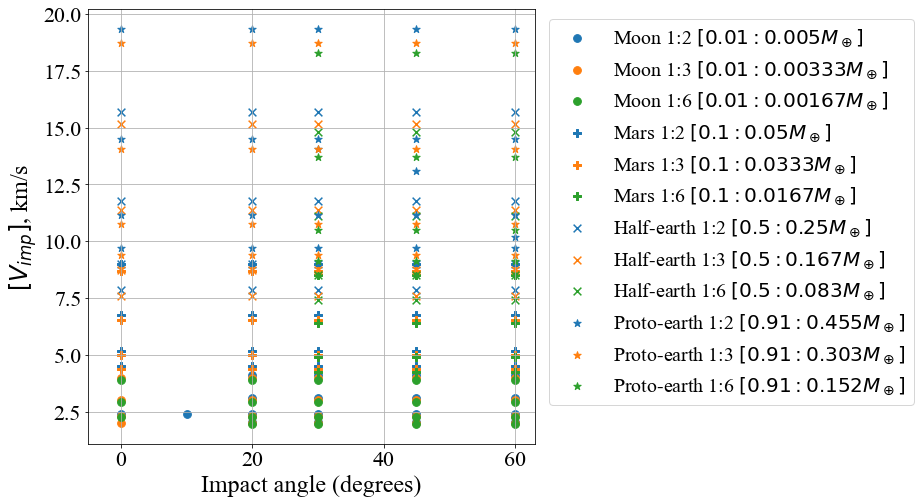

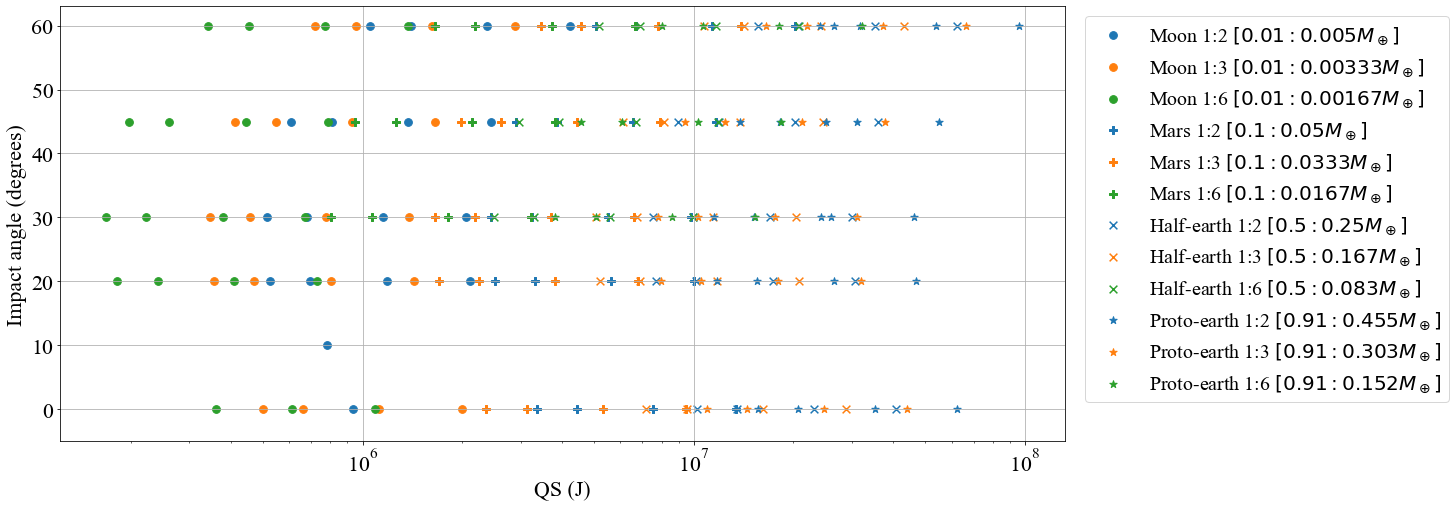

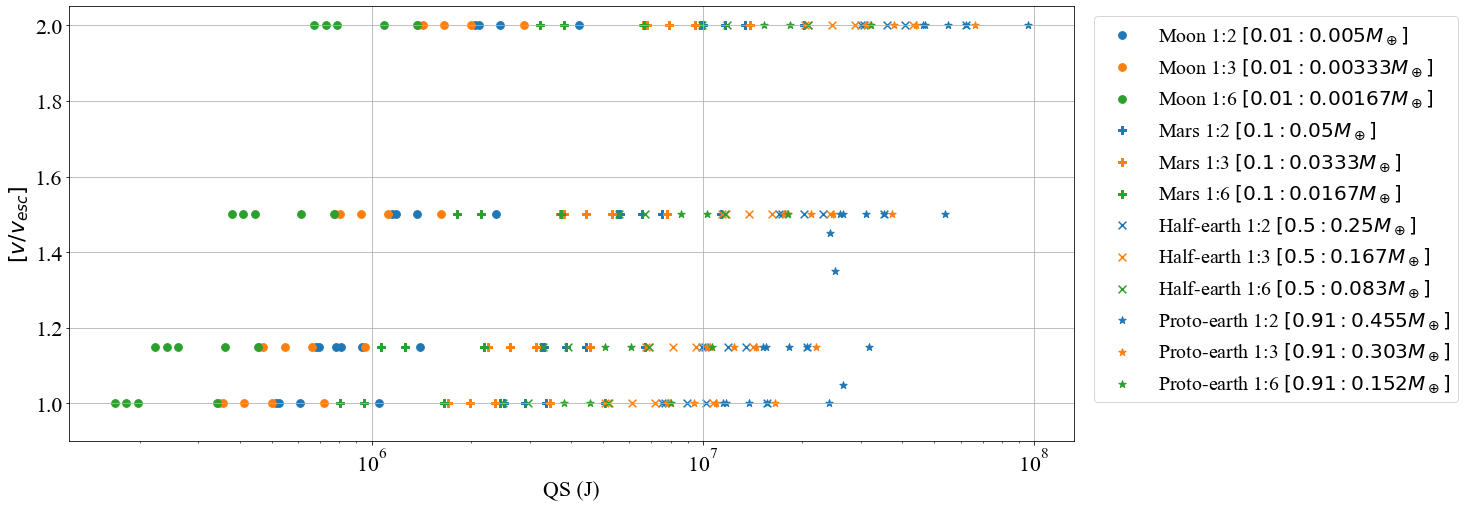

In [51]:
theta_vi_ICs(massandratiolist,labels=massandratiolabels)
QS_ICs_theta(massandratiolist,labels=massandratiolabels)
QS_ICs_vi(massandratiolist,labels=massandratiolabels)

# Accretion efficiency

### All data
Icon legend:
'o' = accretion
'+' = partial accretion
'x' = hit-and-run

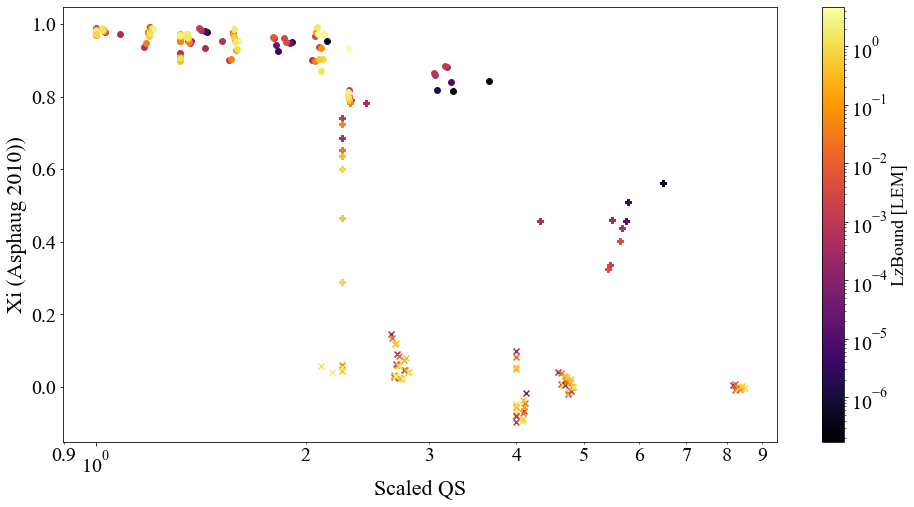

In [29]:
QS_u_scaled_xi([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')

### Without head-on data

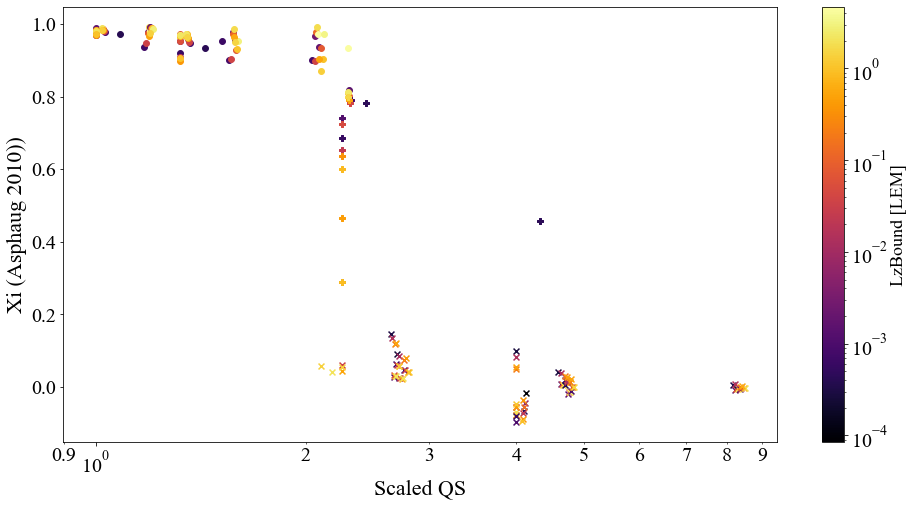

In [30]:
QS_u_scaled_xi([accretionlistno0,partialaccretionlistno0,hitandrunlistno0],labels=None,colors='Lz',legend=False,markers='outcome')

# Energy deposition/heat budgets

### Accretionary data, no head-on

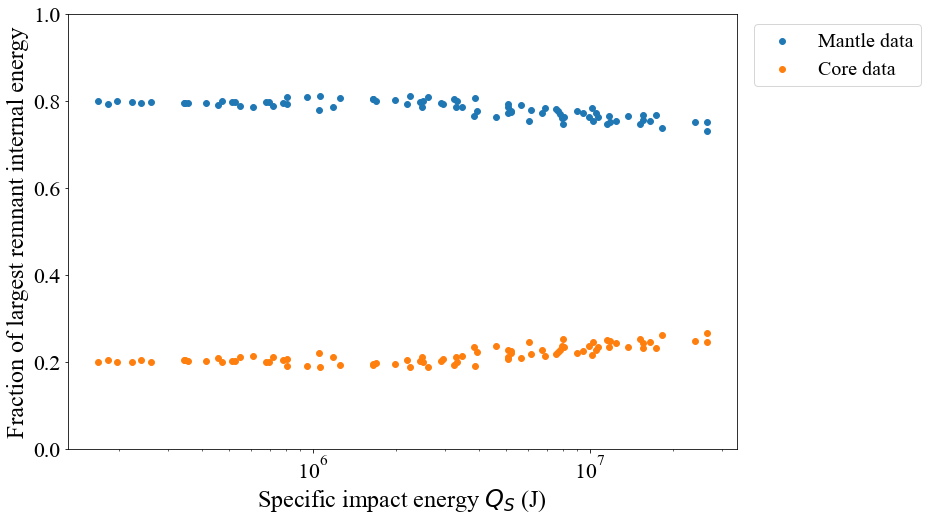

polynomial coefficients, n...0 :  [-0.27808274  1.3266803 ]
R^2 value:  [0.96375765]


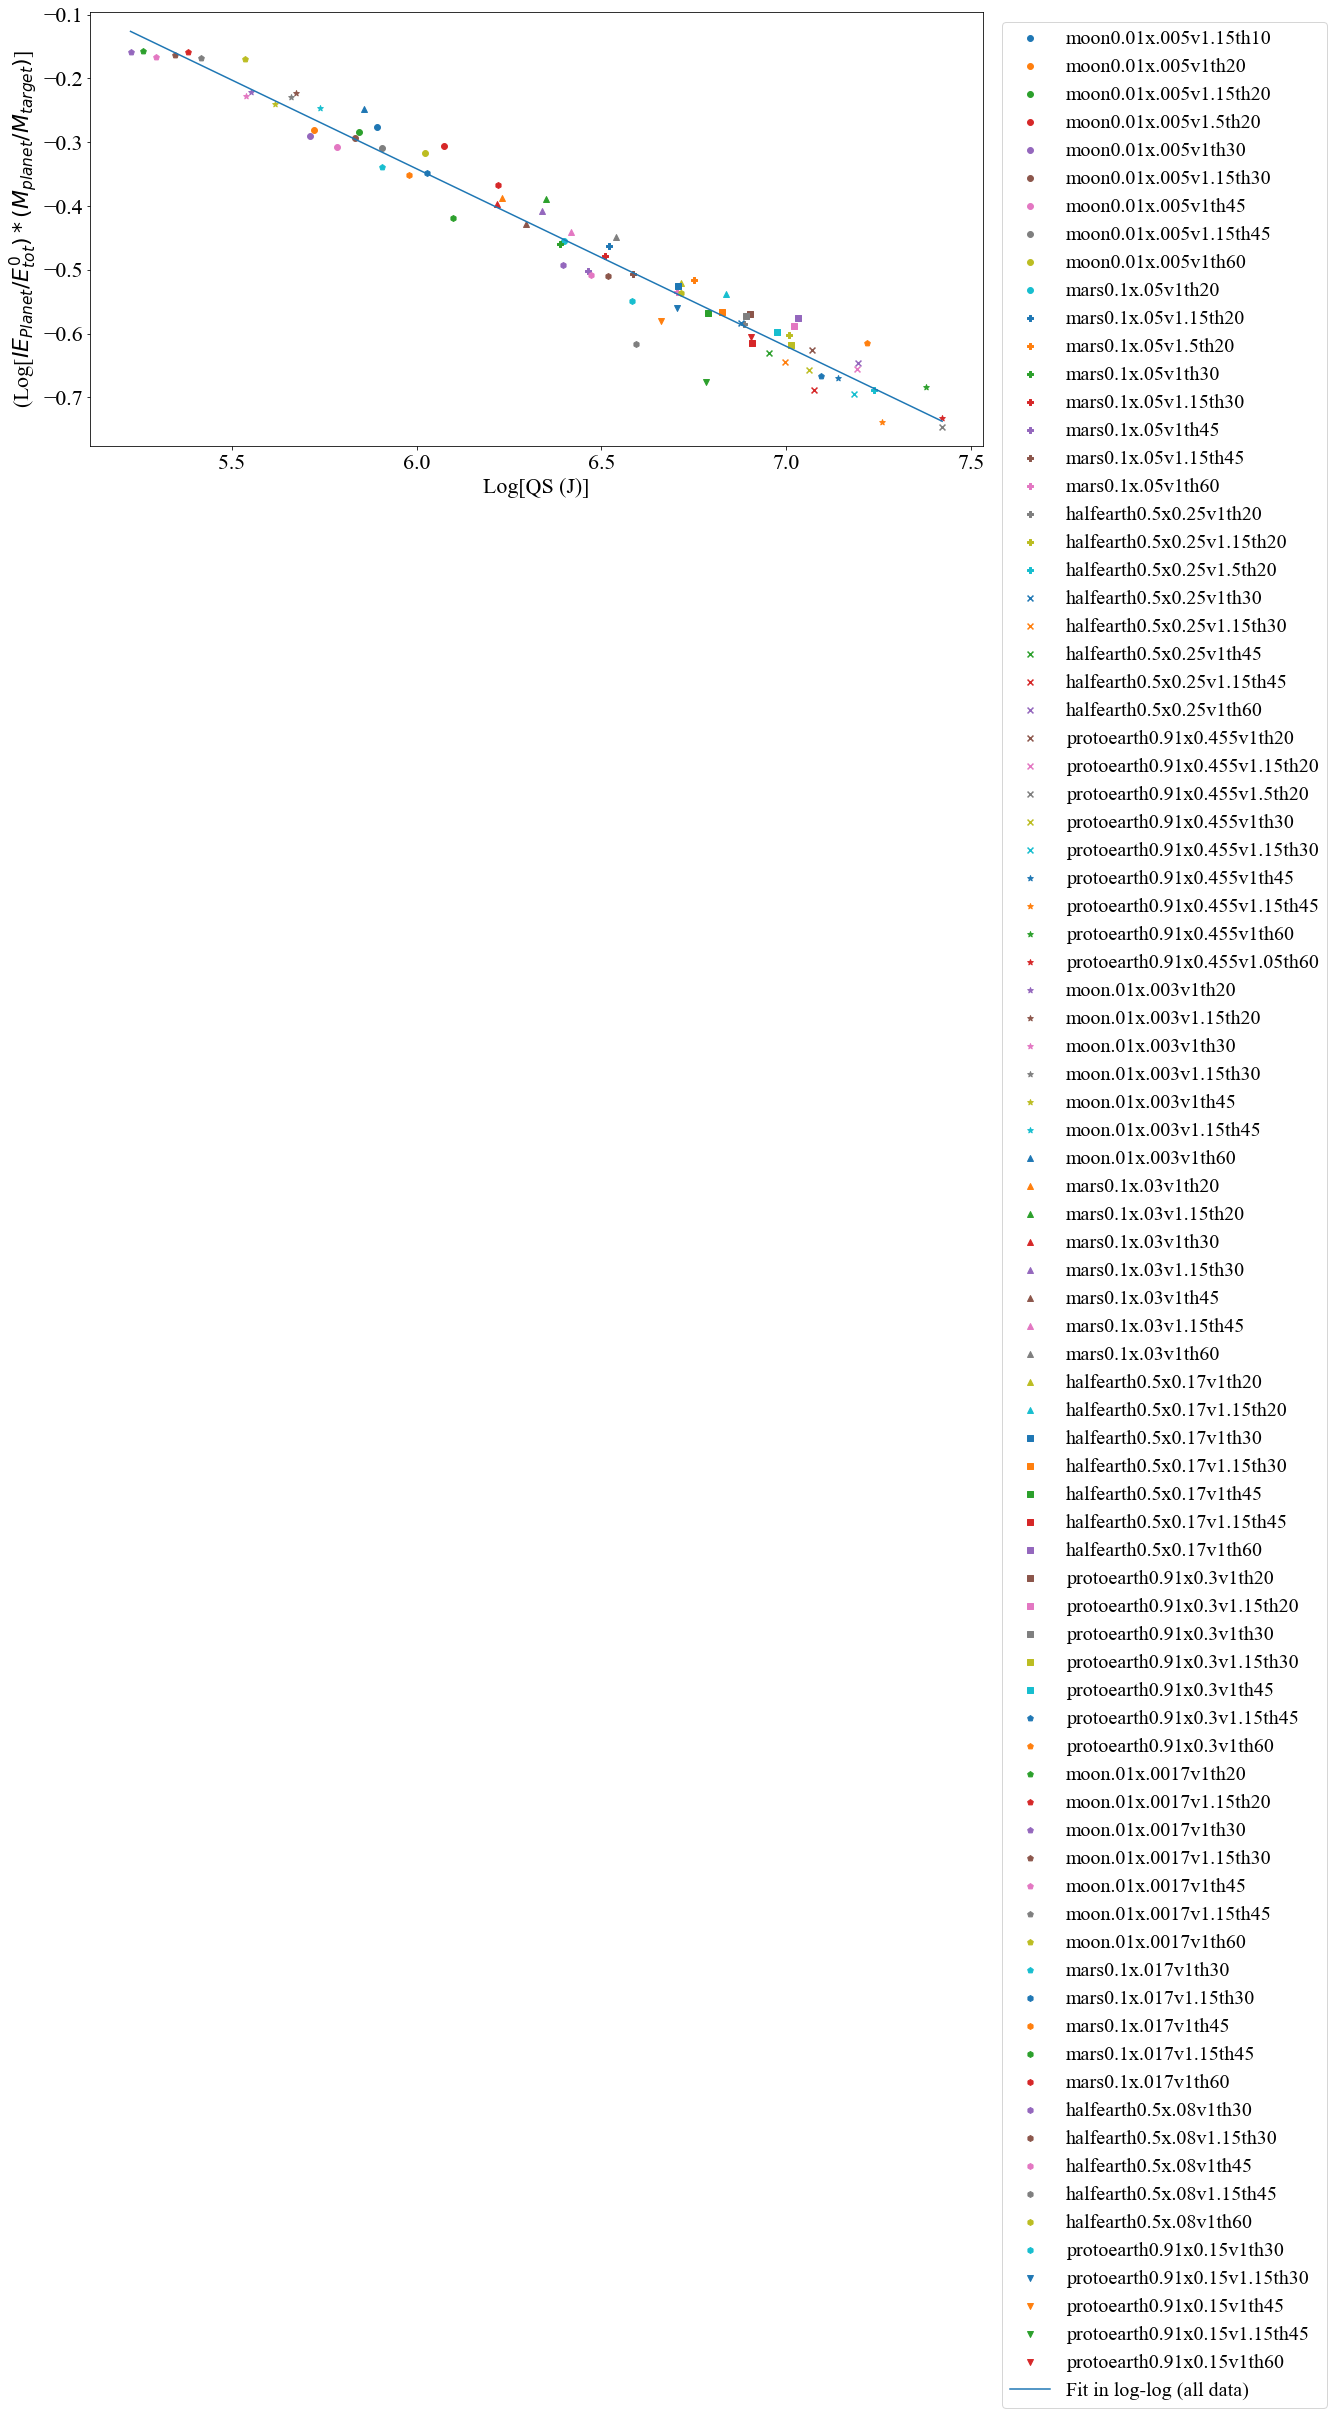

Mantle polynomial coefficients, n...0 :  [-0.29158917  1.30722612]
Mantle R^2 value:  [0.96219079]
Core polynomial coefficients, n...0 :  [-0.2307962   0.35717881]
Core R^2 value:  [0.93434935]


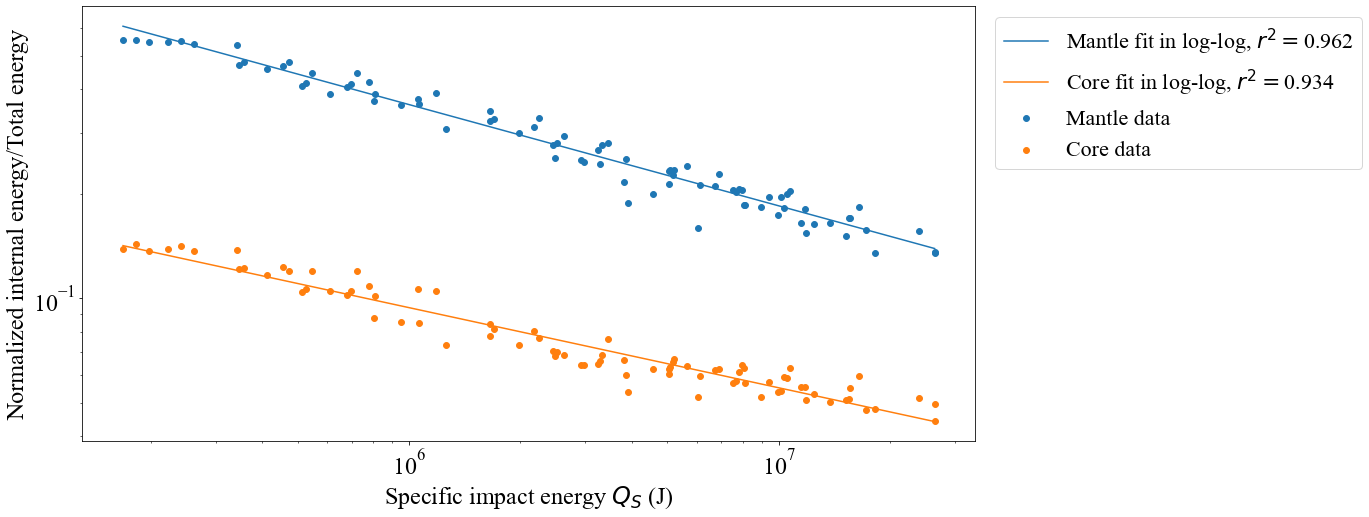

In [69]:
QS_u_core_mantle_fraction([accretionlistno0],labels=None)
u_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)
u_core_mantle_bound_mass([accretionlistno0],labels=None,loglog=True,logfit=True)

### Accretionary data, only head-on

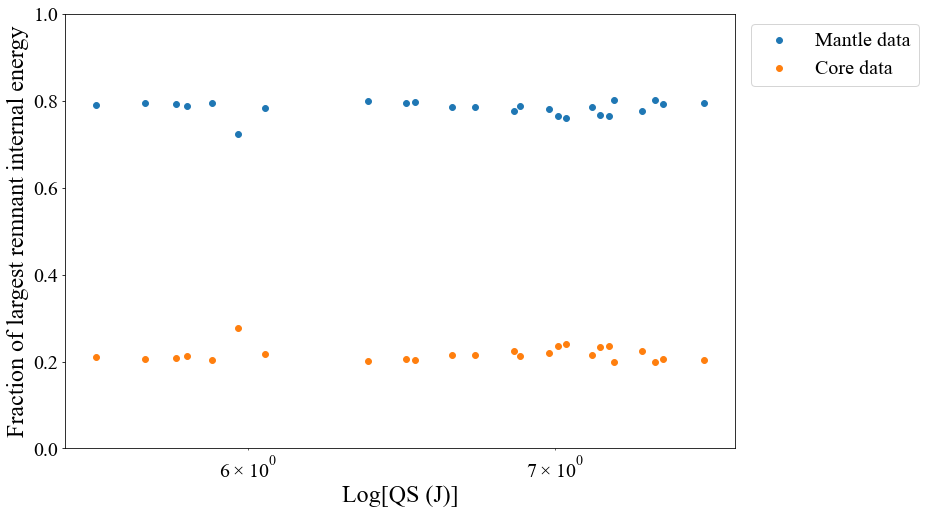

polynomial coefficients, n...0 :  [-0.24835804  1.21629936]
R^2 value:  [0.9591481]


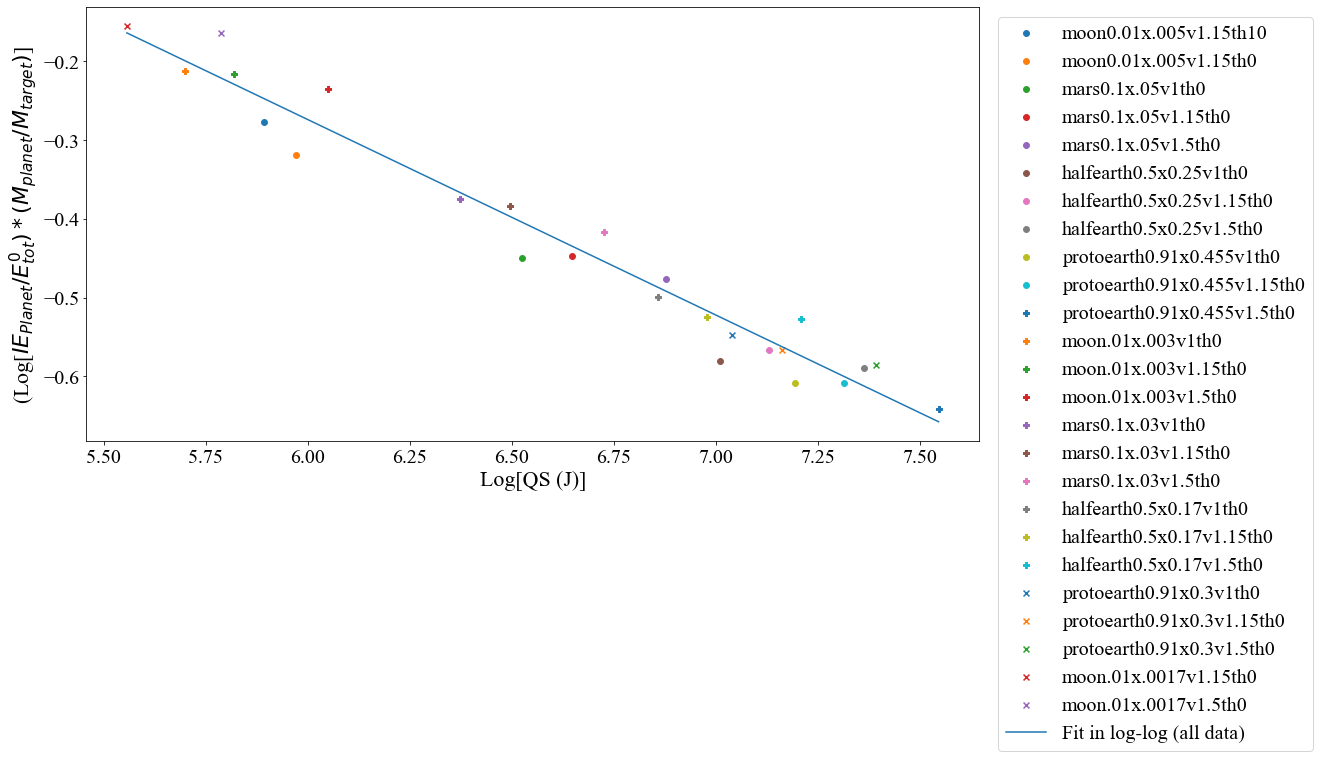

Mantle polynomial coefficients, n...0 :  [-0.24842902  1.1103283 ]
Mantle R^2 value:  [0.94254363]
Core polynomial coefficients, n...0 :  [-0.2471679   0.54397447]
Core R^2 value:  [0.95973935]


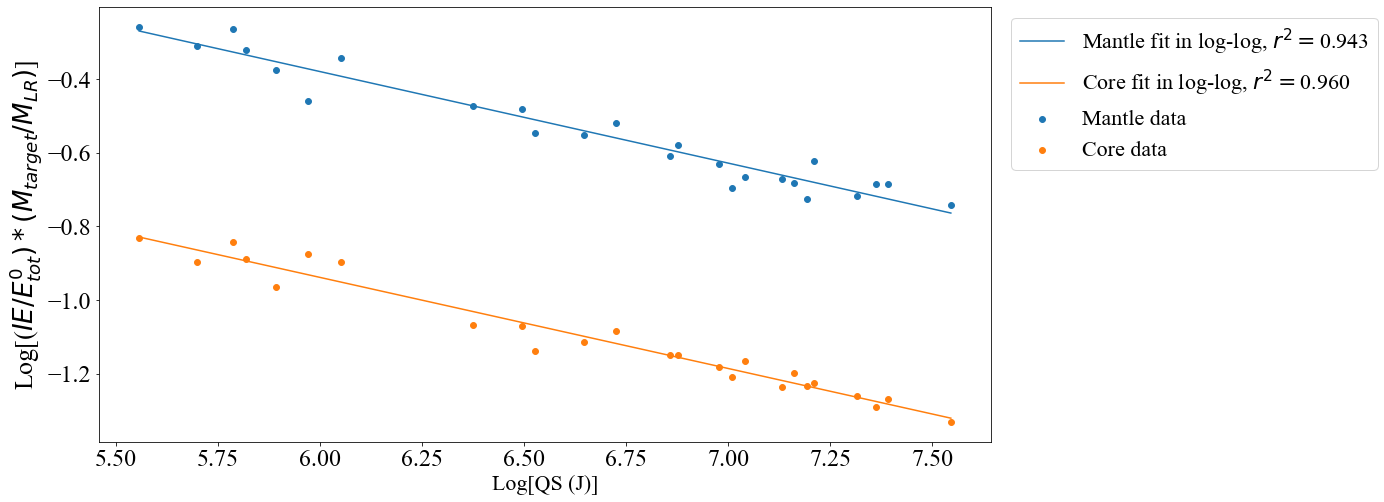

In [32]:
QS_u_core_mantle_fraction([accretion010list],labels=None)
u_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)
u_core_mantle_bound_mass([accretion010list],labels=None,loglog=True,logfit=True)

### Hit-and-run data

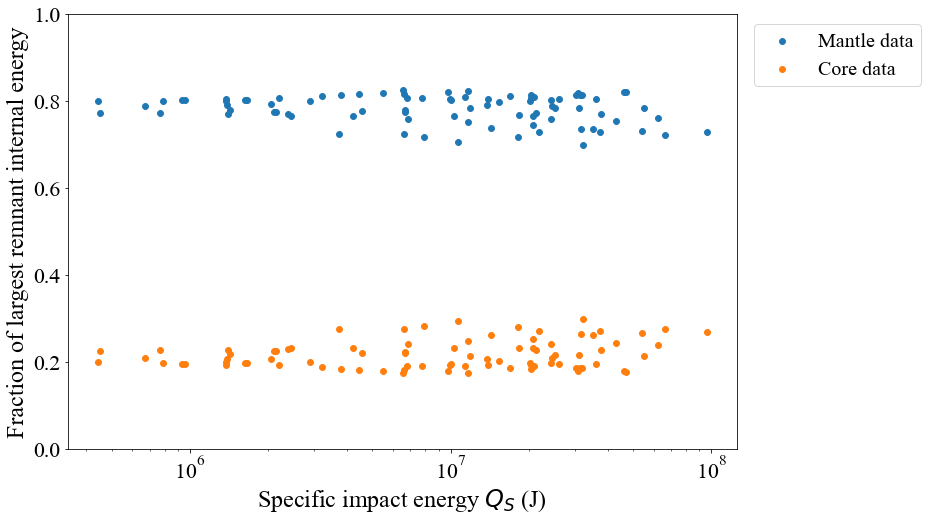

polynomial coefficients, n...0 :  [-0.41963038  2.20157584]
r^2 value:  [0.928895]


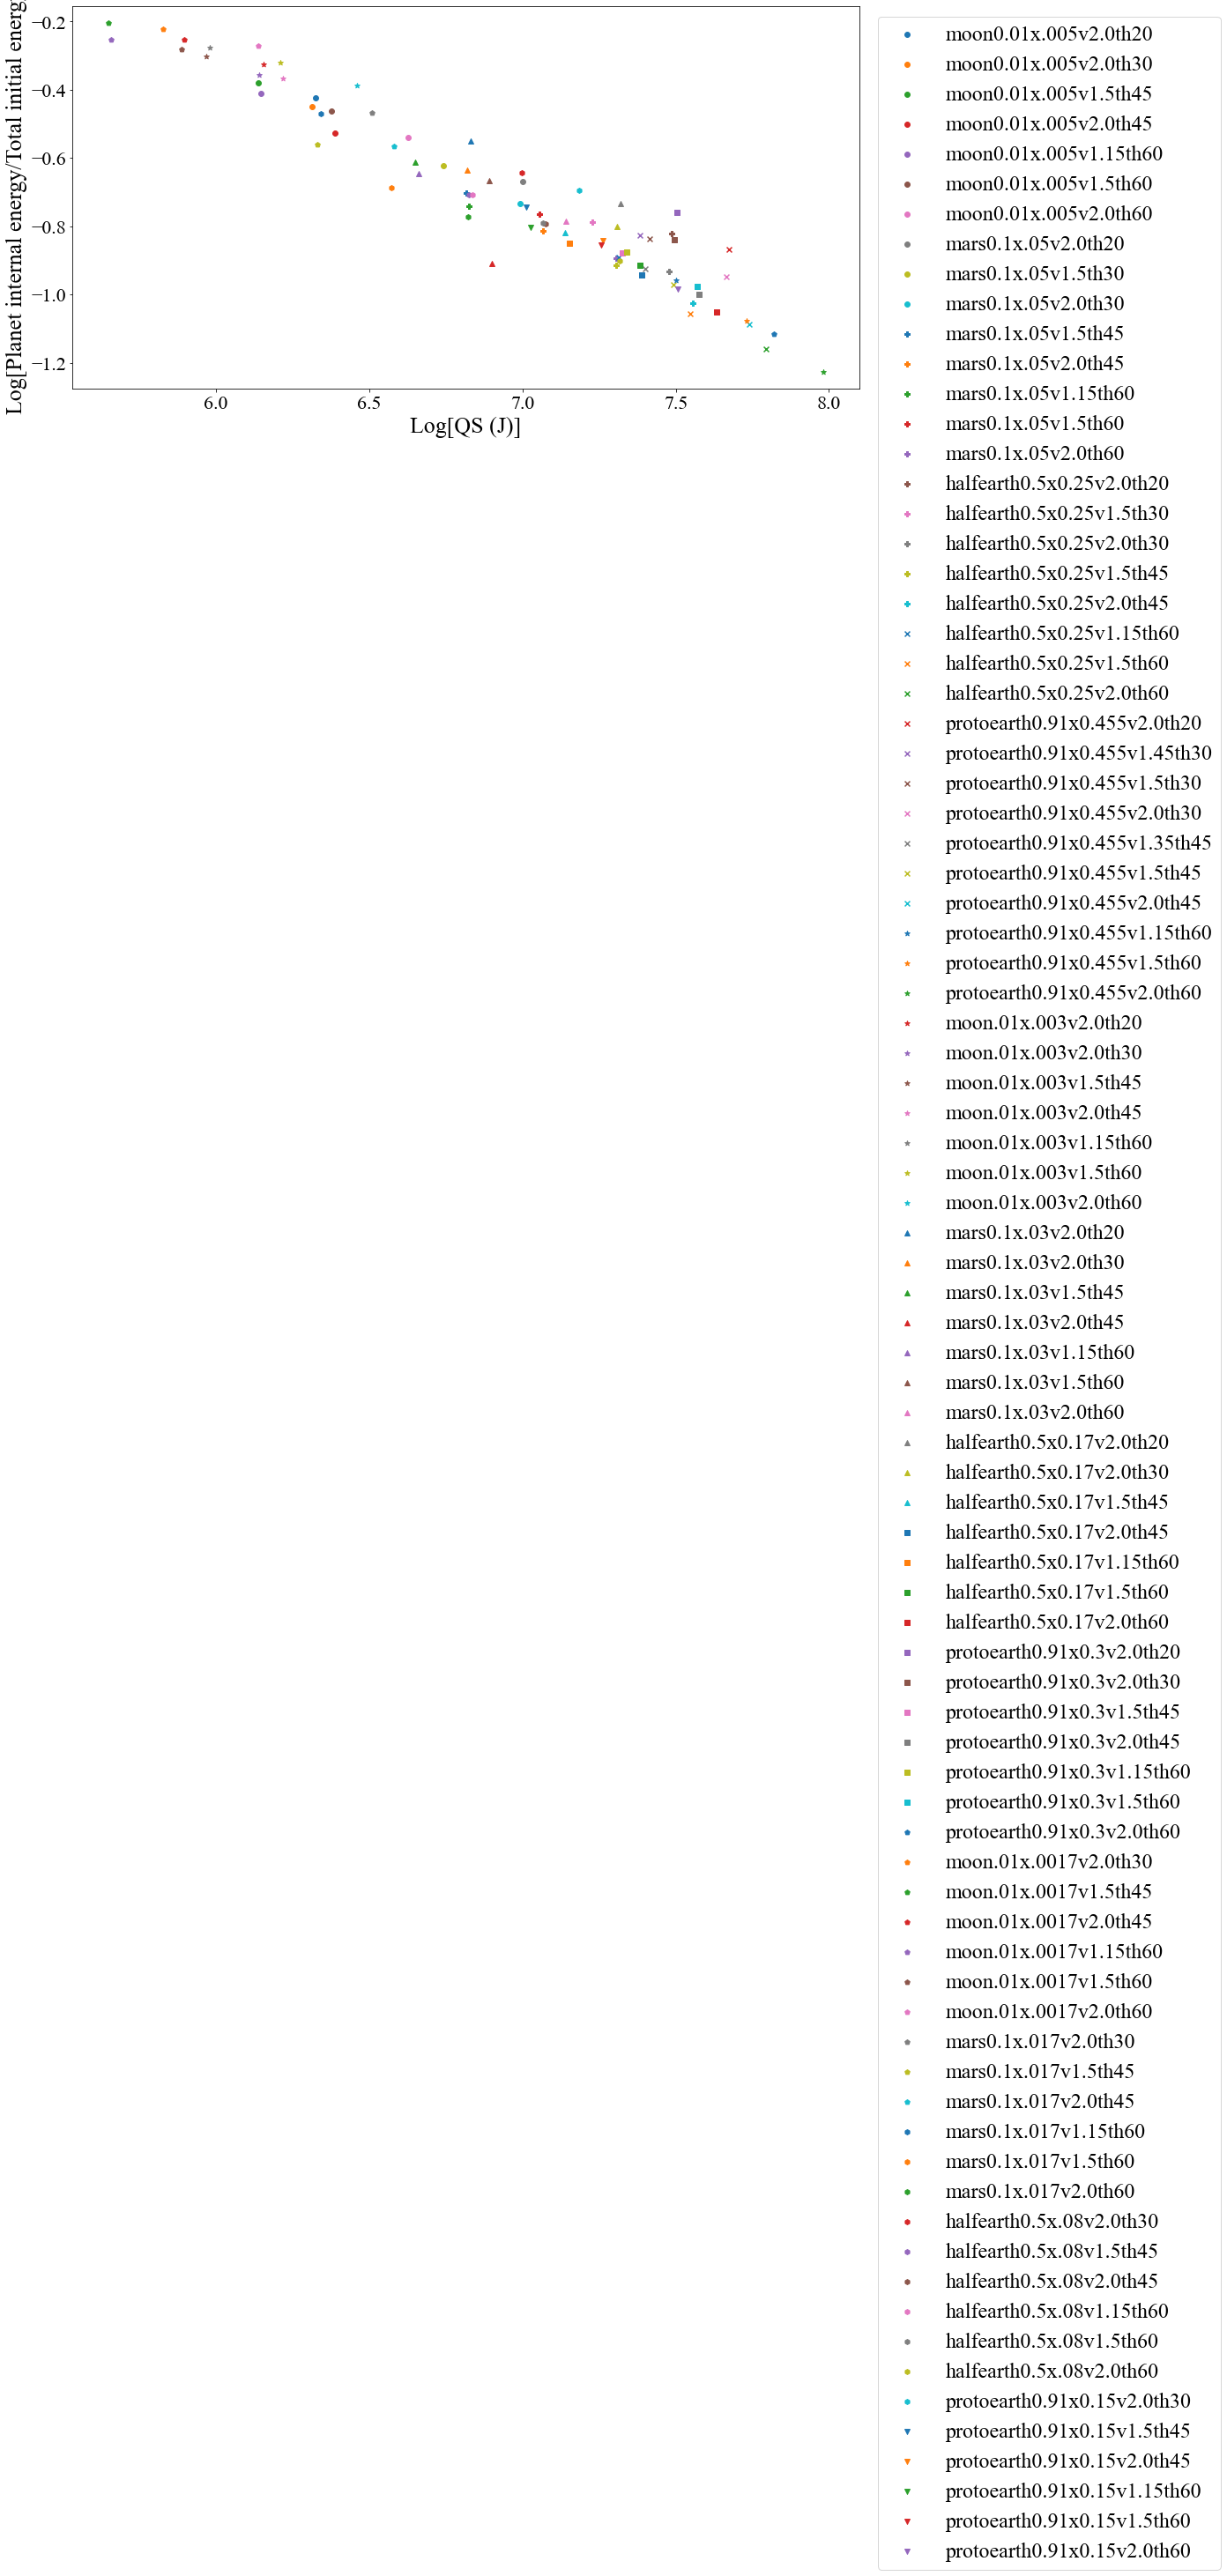

Mantle polynomial coefficients, n...0 :  [-0.42657814  2.14267232]
Mantle r^2 value:  [0.90743682]
Core polynomial coefficients, n...0 :  [-0.39855543  1.38921865]
Core r^2 value:  [0.93933512]


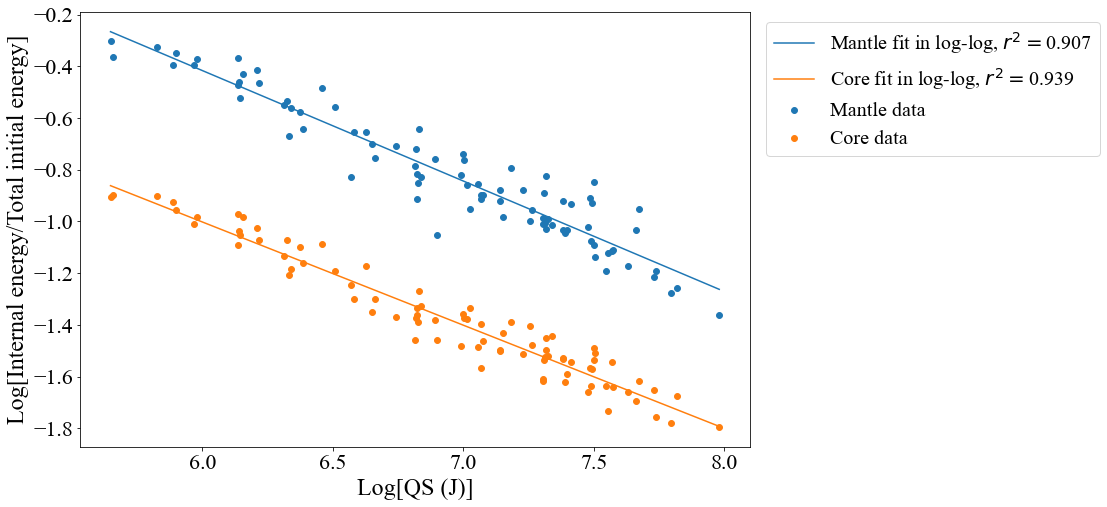

In [54]:
QS_u_core_mantle_fraction([hitandrunlist],labels=None)
QS_u_planet([hitandrunlist],labels=None,loglog=True,logfit=1)
QS_u_core_mantle([hitandrunlist],labels=None,loglog=True,logfit=1)

# Core-mantle-boundary P/T conditions
## Compared to Rubie 2015:
### All data
Icon legend:
'o' = accretion
'+' = partial accretion
'x' = hit-and-run

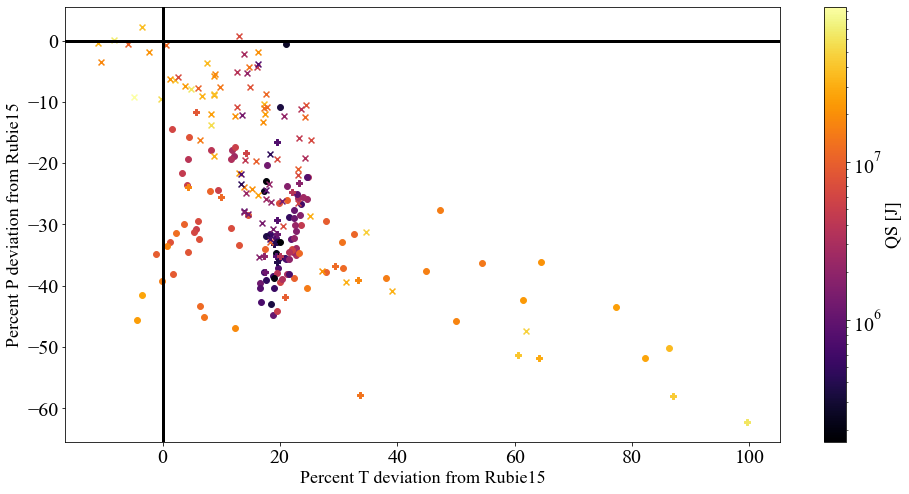

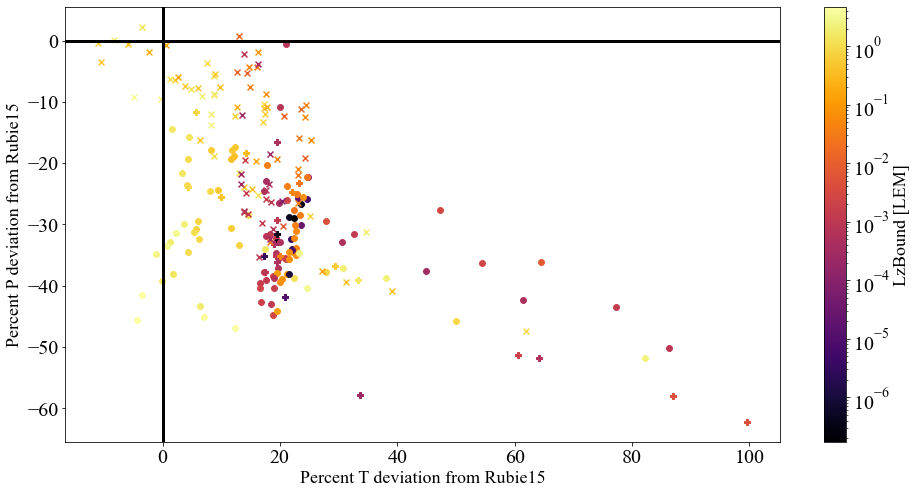

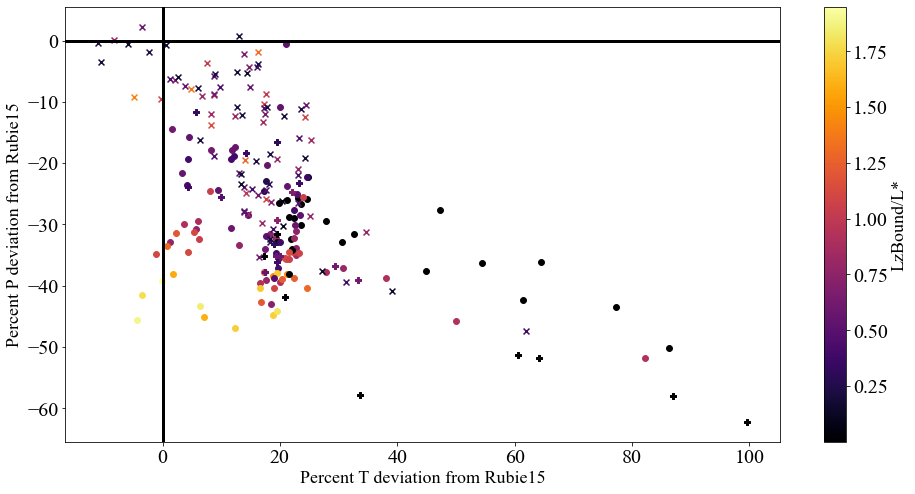

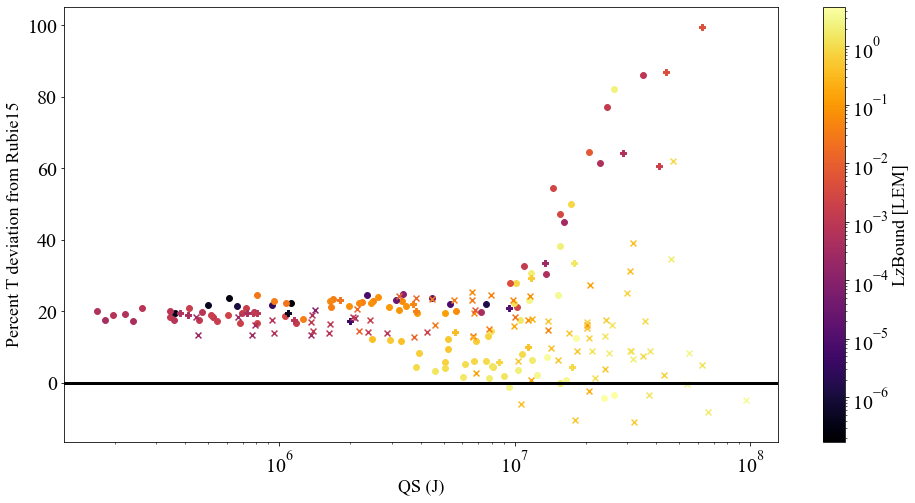

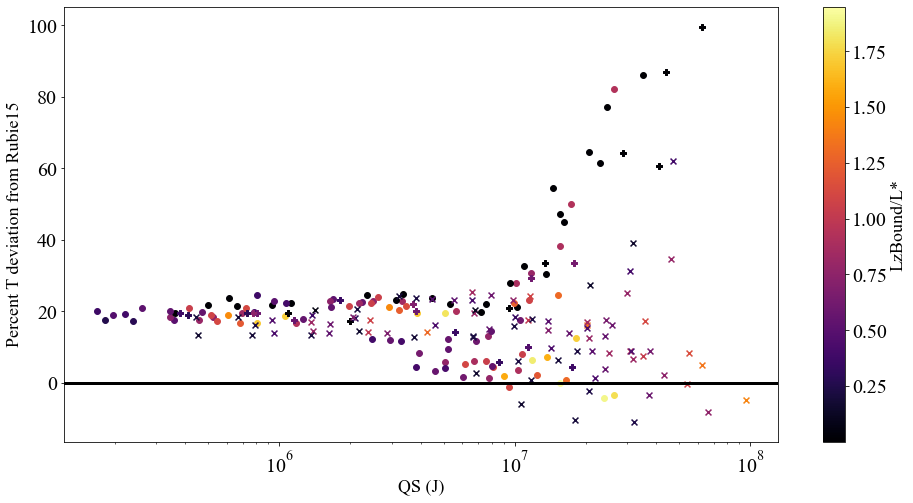

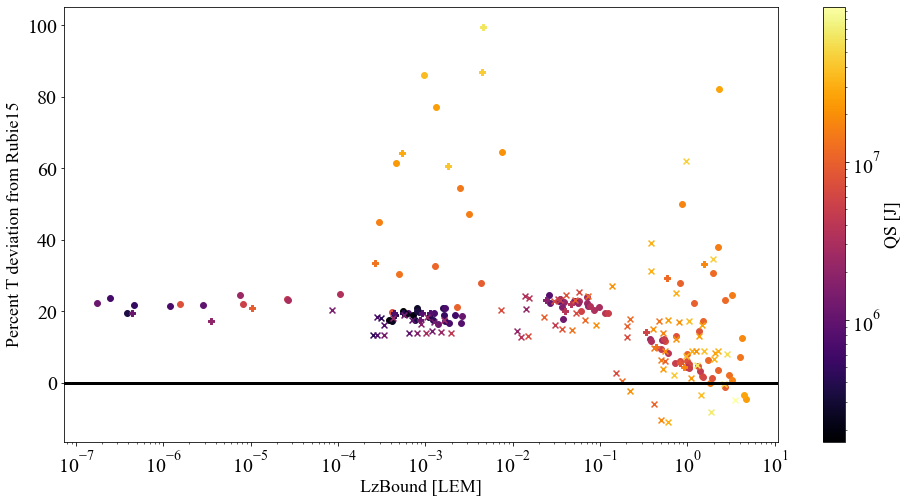

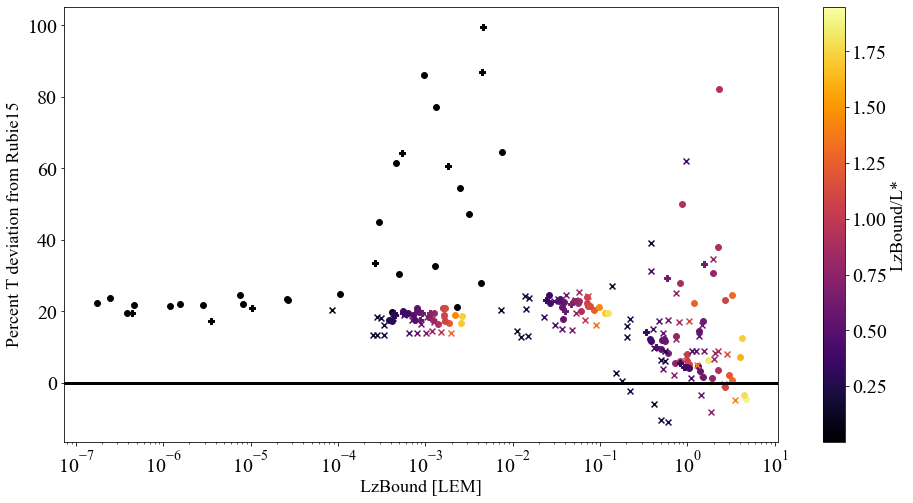

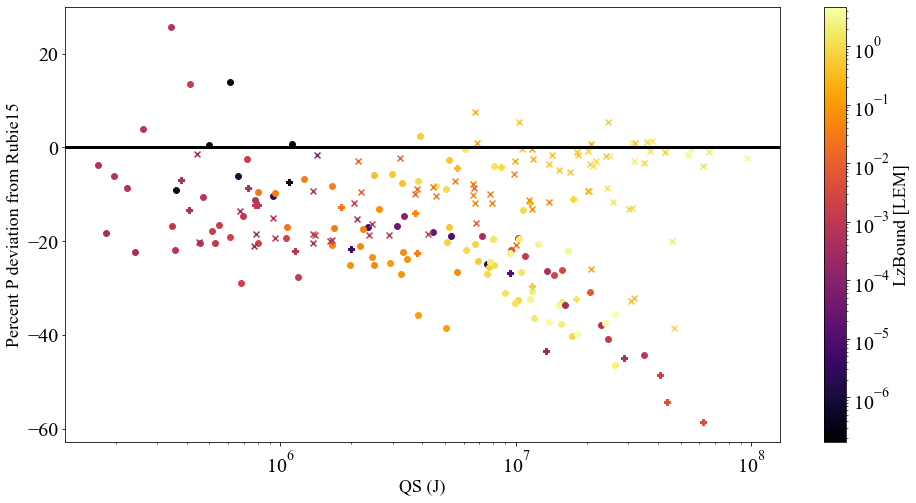

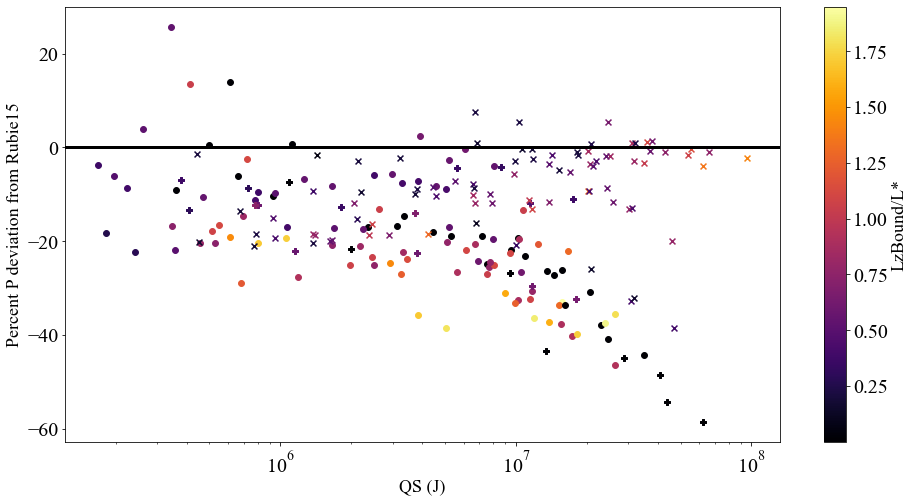

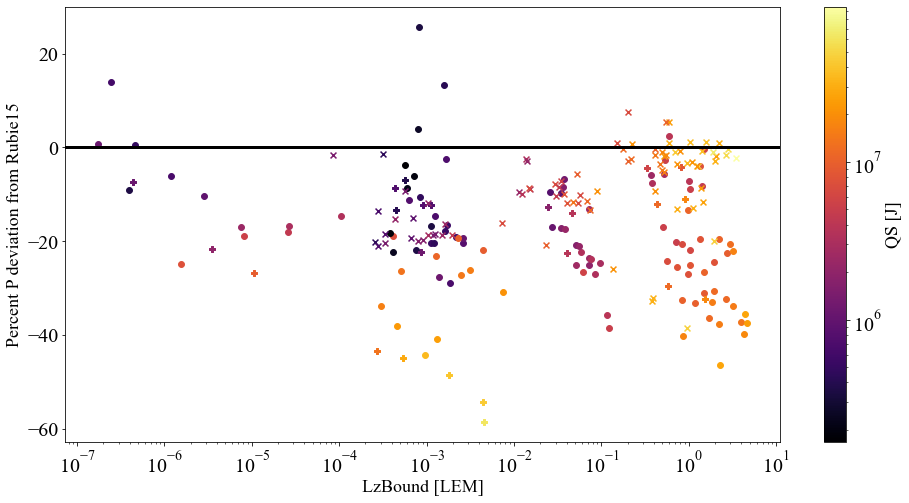

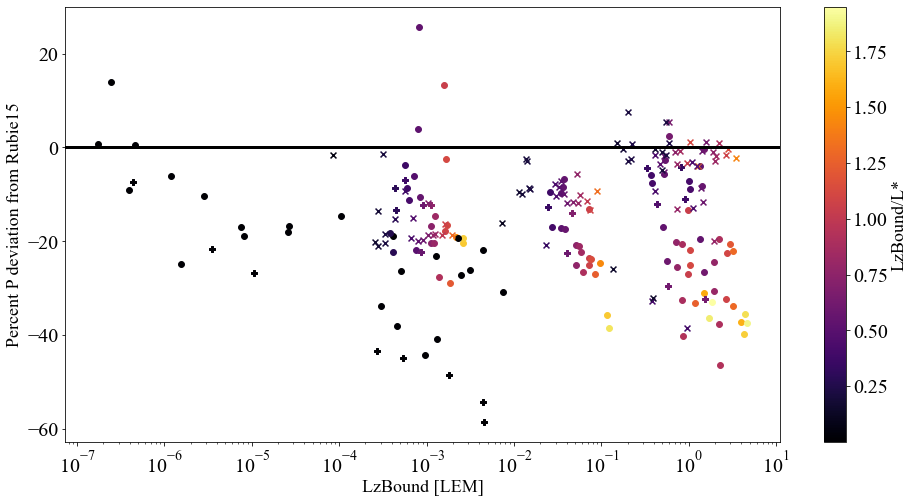

In [34]:
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome',fP=.73)
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',fP=.73)
dPT_rubie([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True,fP=.73)

T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',fP=.73)
T_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True,fP=.73)

T_rubie_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome',fP=.73)
T_rubie_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True,fP=.73)

P_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome')
P_rubie_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)

P_rubie_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome')
P_rubie_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',Lzstar=True)

In [35]:
siKD=2.98+15934/(1.2)+(-155*(.65)+2.26*(.65)**2-0.011*(.65)**3)/(1.2)
siKD0=2.98+15934/(1)+(-155*(1)+2.26*(1)**2-0.011*(1)**3)/(1)
print(siKD)
print(siKD0)
print(siKD/siKD0)
print((siKD-siKD0)/siKD0)
print(10**(siKD/siKD0))

13198.1481909375
15784.229
0.8361604606051711
-0.16383953939482884
6.8574154345917915


### Accretionary data
Icon legend: \
'o' = Theta = 0 \
'x' = Theta = 20 \
'☆' = Theta = 30 \
'□' = Theta = 45 \
'△' = Theta = 60

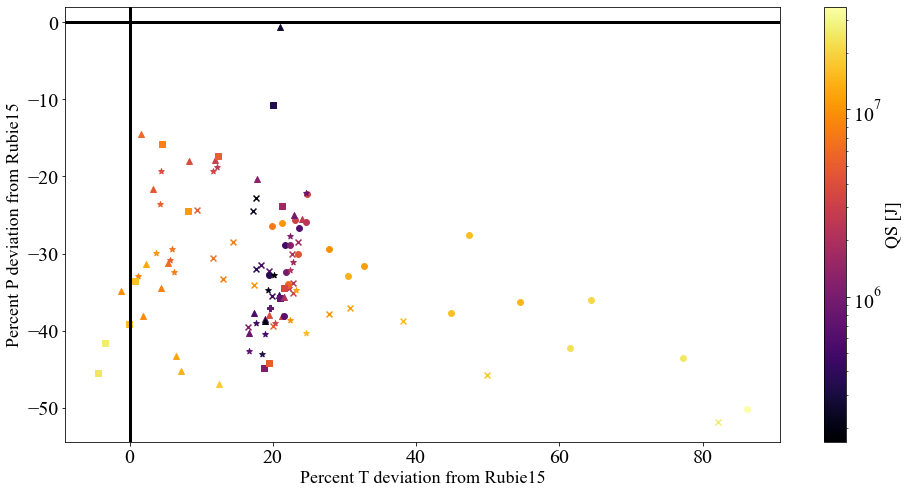

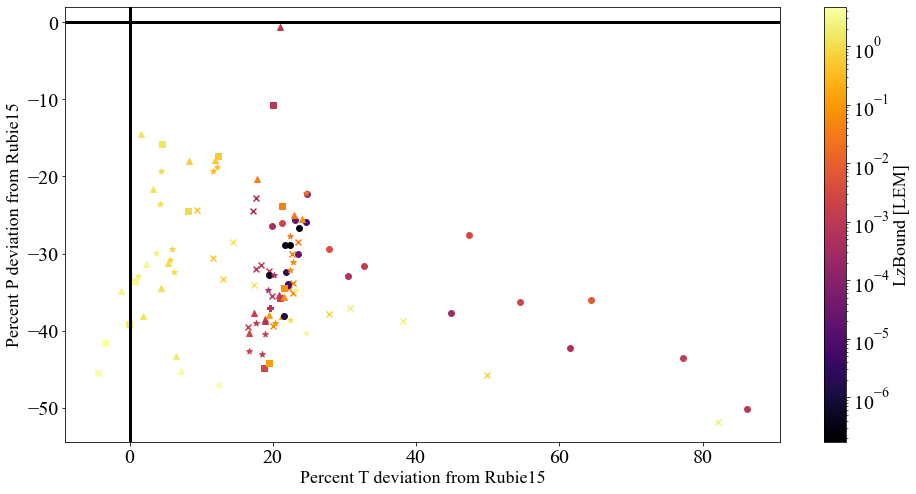

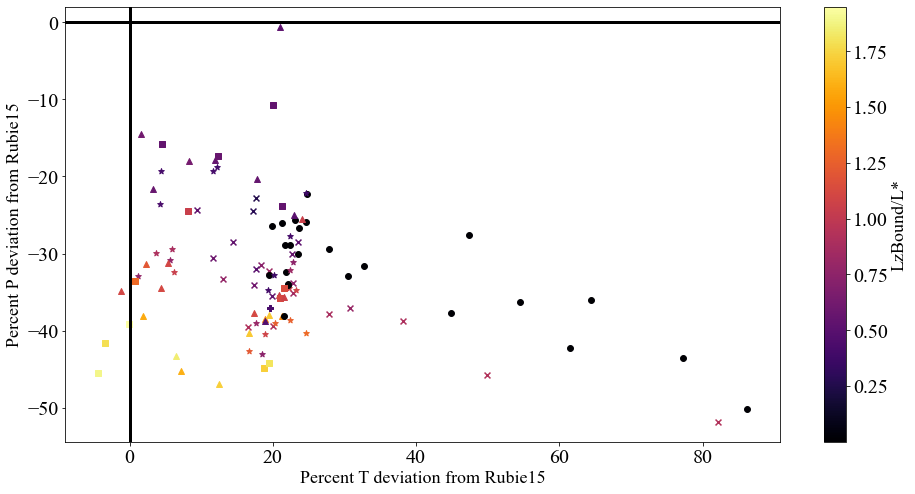

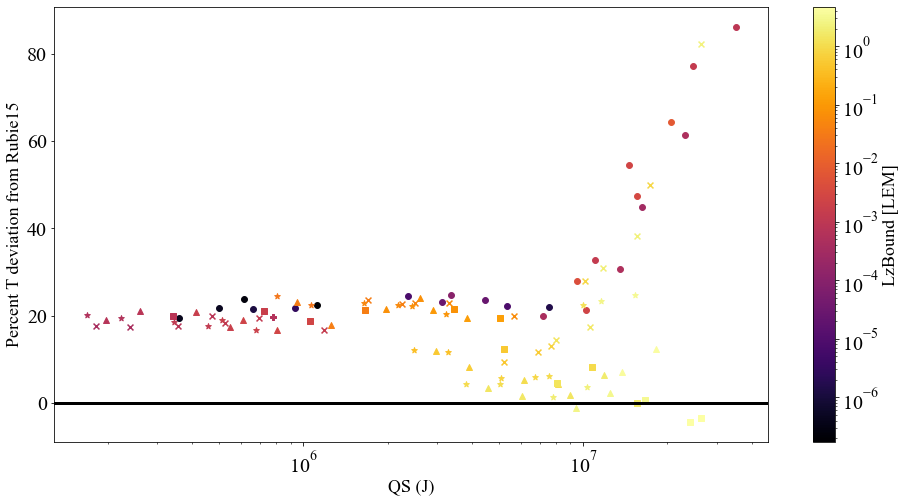

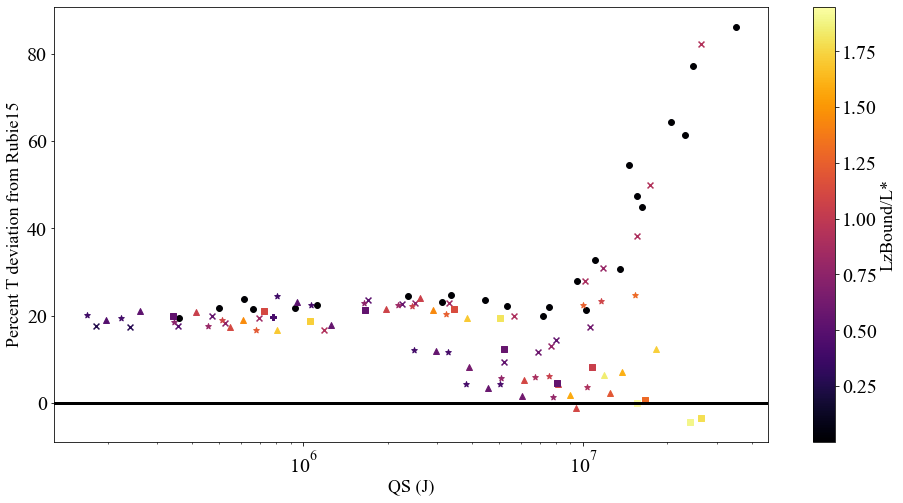

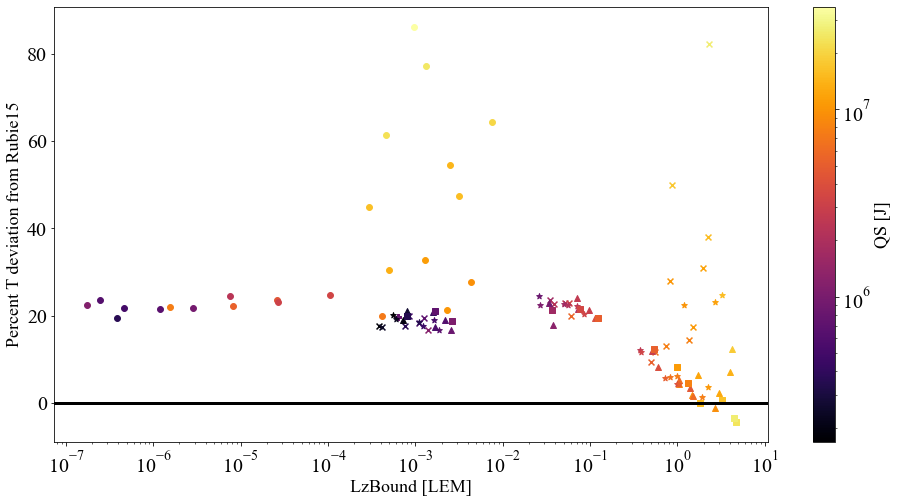

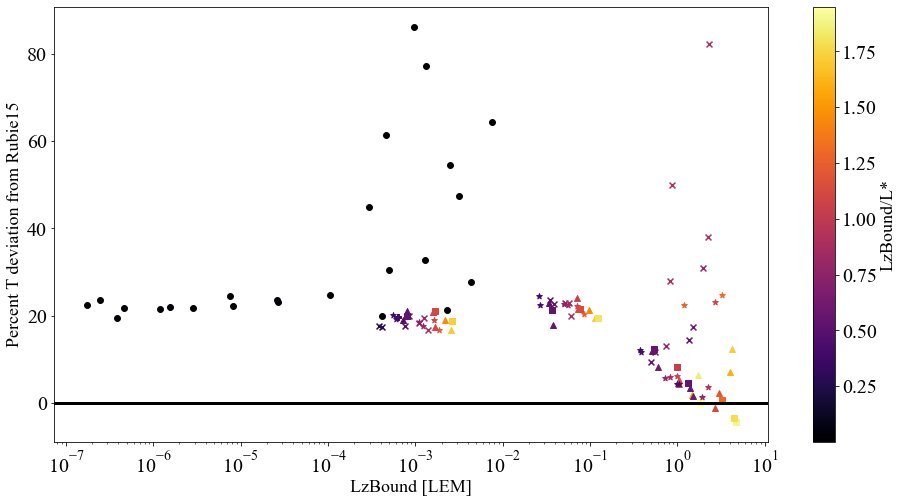

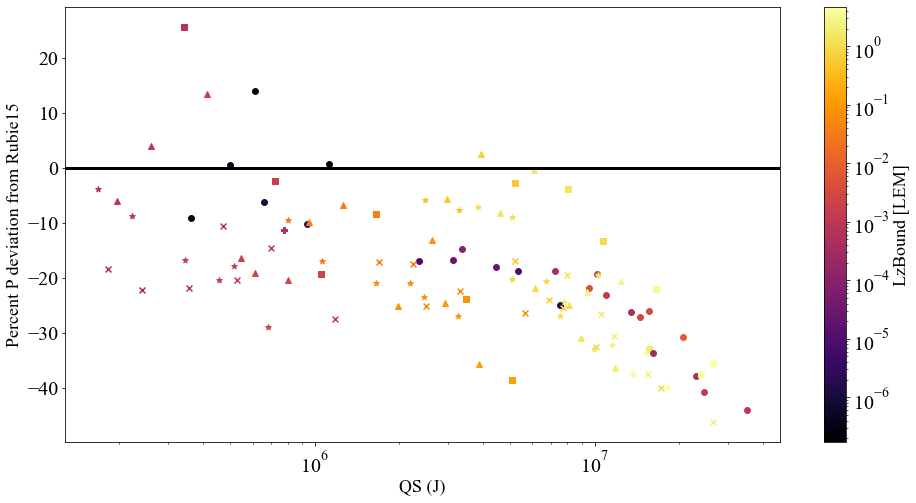

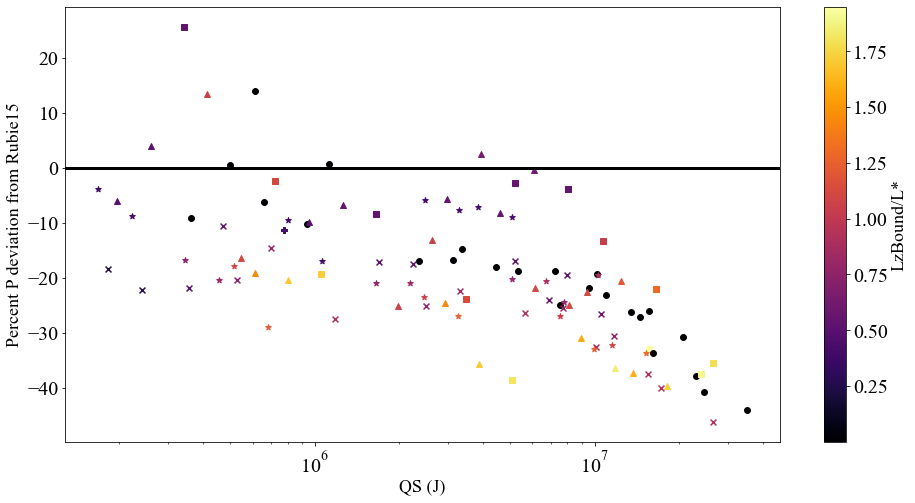

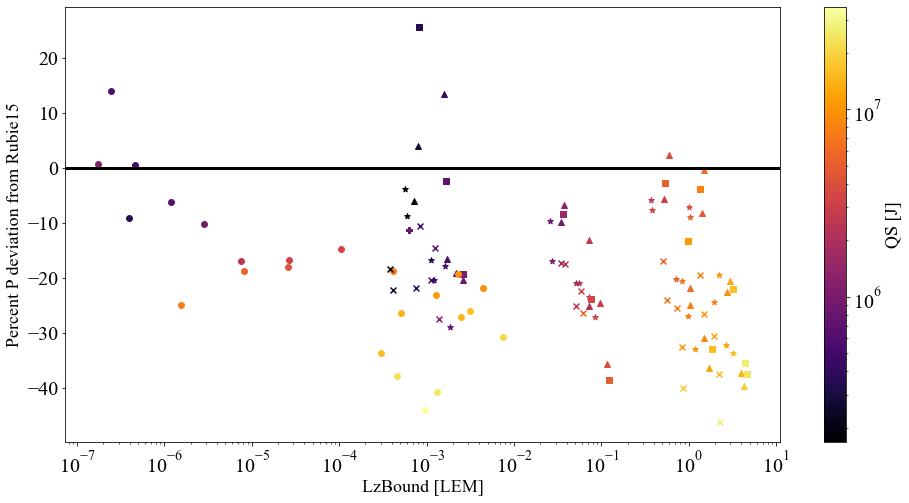

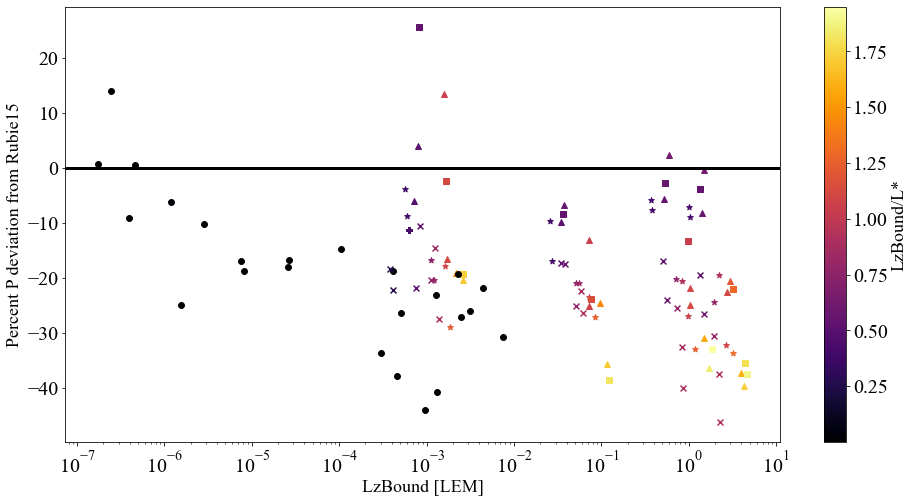

In [36]:
dPT_rubie([accretionlist],labels=None,colors='QS',legend=False,markers='theta',fP=.73)
dPT_rubie([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',fP=.73)
dPT_rubie([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

T_rubie_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',fP=.73)
T_rubie_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

T_rubie_Lz([accretionlist],labels=None,colors='QS',legend=False,markers='theta',fP=.73)
T_rubie_Lz([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

P_rubie_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='theta')
P_rubie_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)

P_rubie_Lz([accretionlist],labels=None,colors='QS',legend=False,markers='theta')
P_rubie_Lz([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Accretionary data (without head-on impacts)

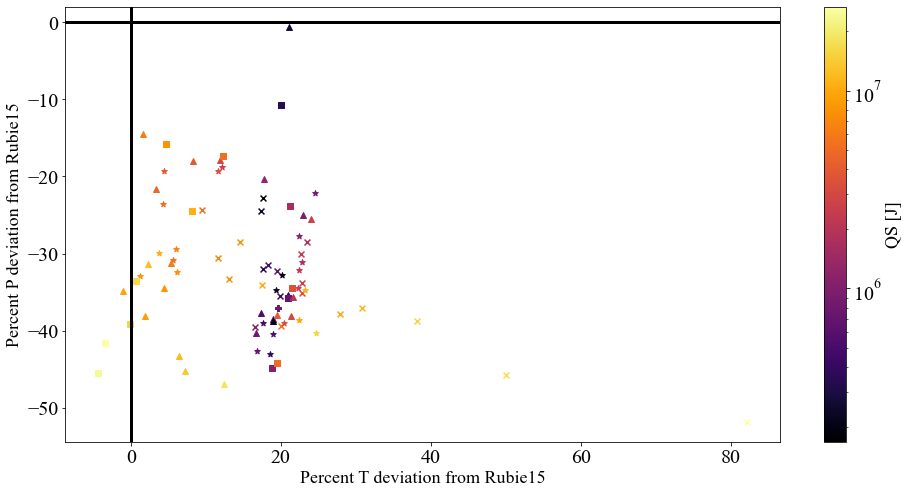

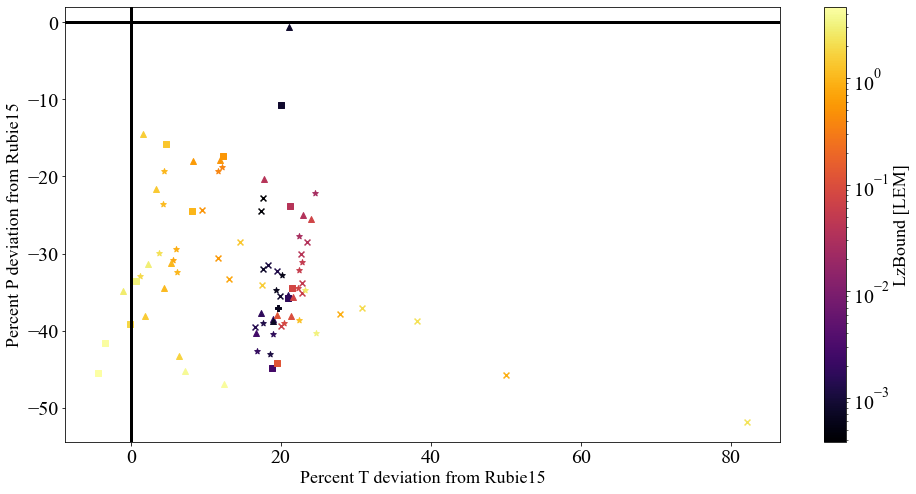

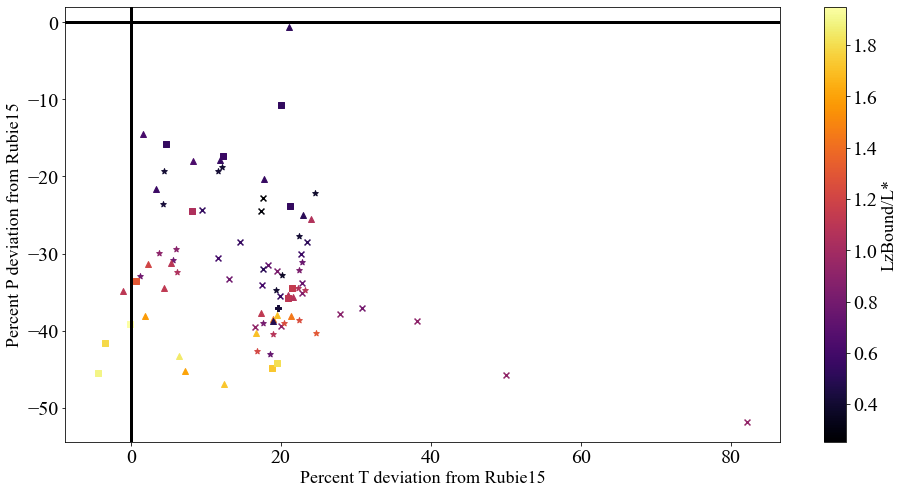

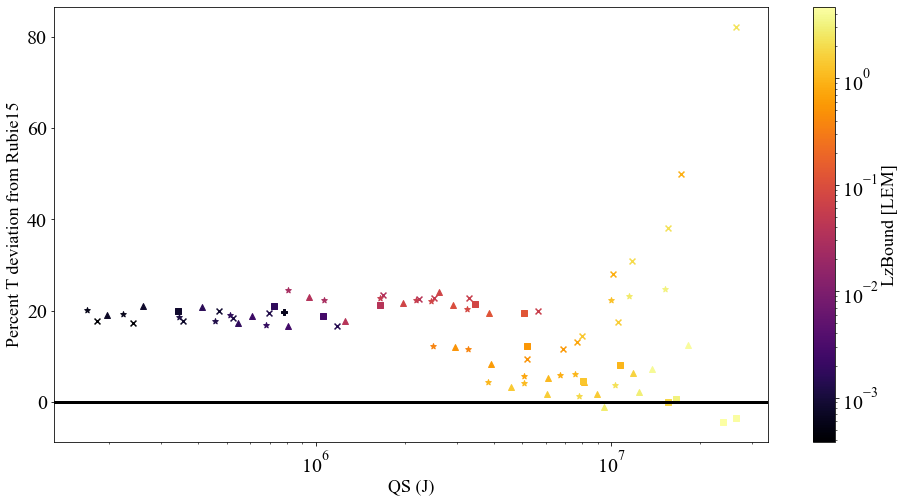

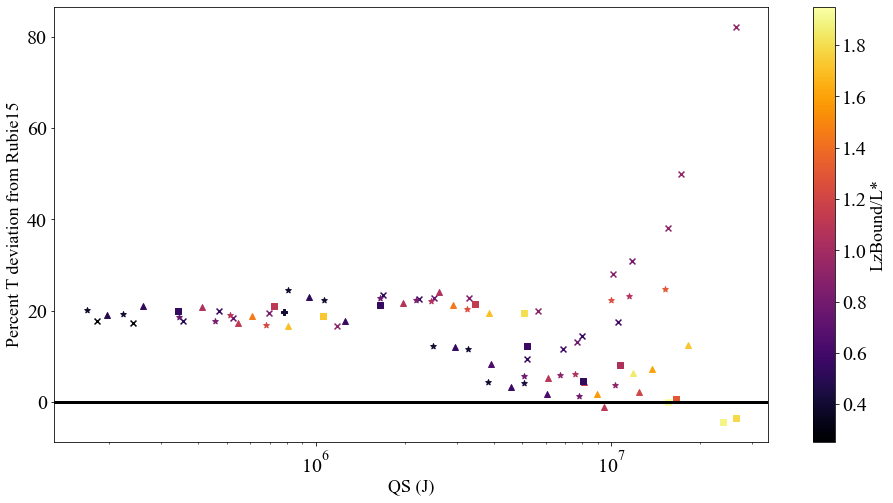

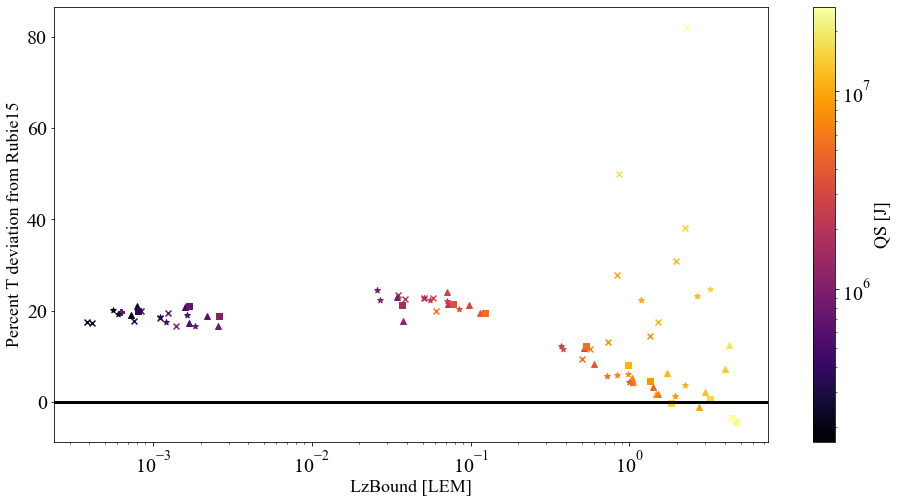

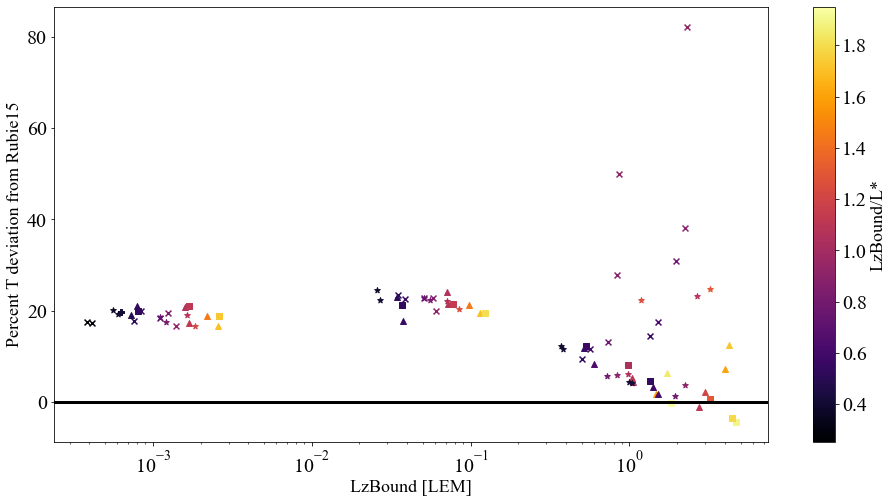

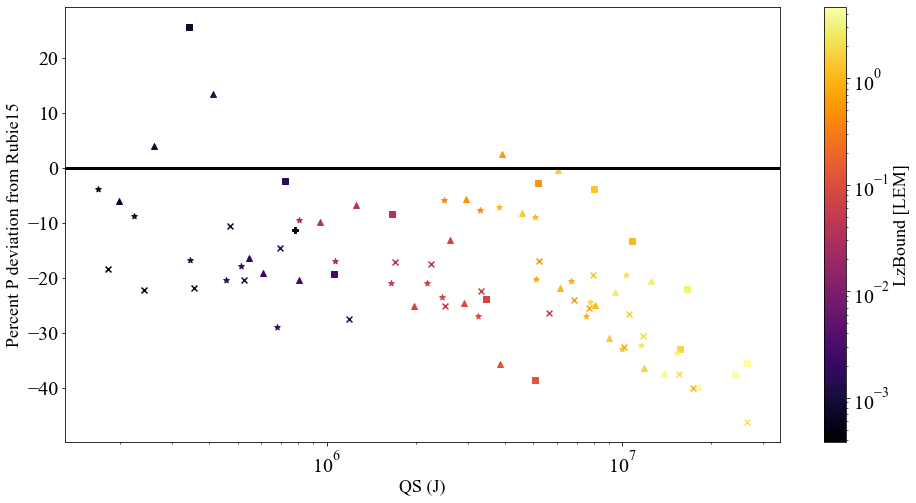

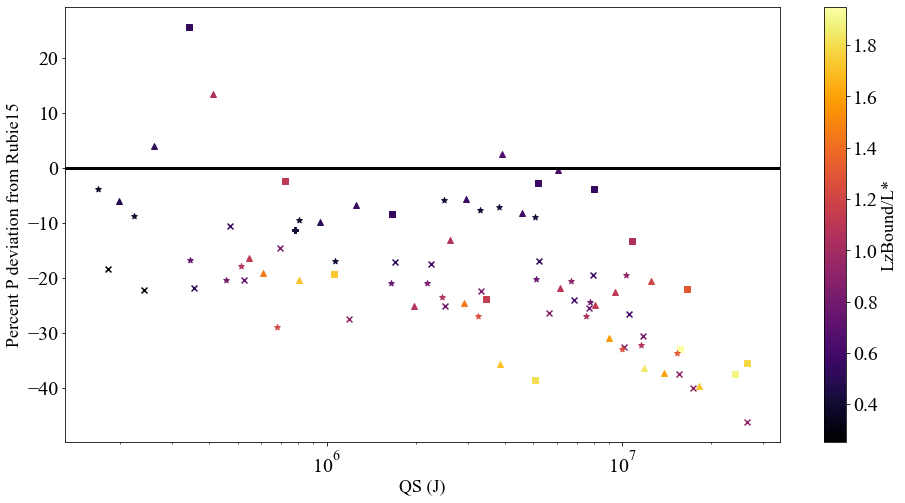

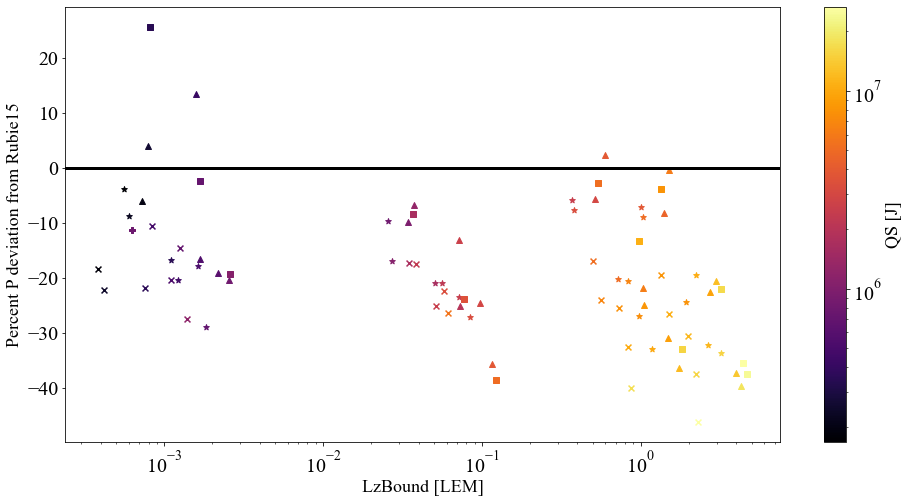

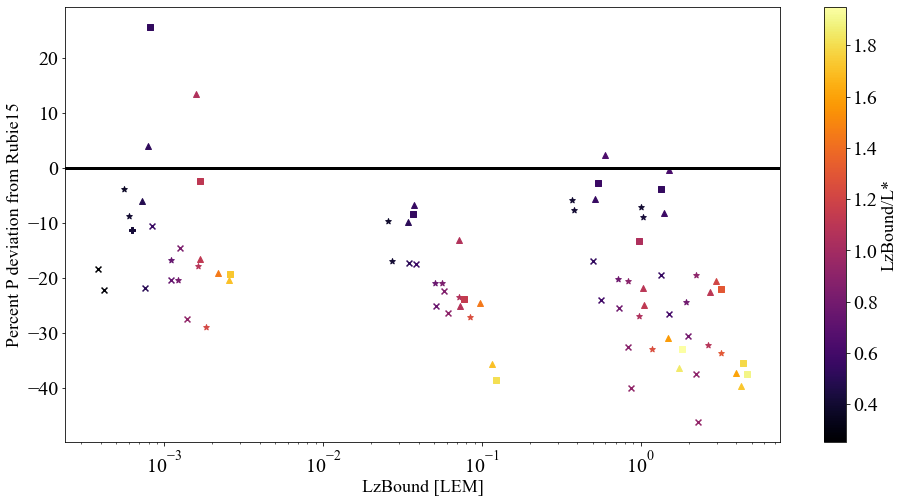

In [37]:
dPT_rubie([accretionlistno0],labels=None,colors='QS',legend=False,markers='theta',fP=.73)
dPT_rubie([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',fP=.73)
dPT_rubie([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

T_rubie_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',fP=.73)
T_rubie_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

T_rubie_Lz([accretionlistno0],labels=None,colors='QS',legend=False,markers='theta',fP=.73)
T_rubie_Lz([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

P_rubie_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta')
P_rubie_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)

P_rubie_Lz([accretionlistno0],labels=None,colors='QS',legend=False,markers='theta')
P_rubie_Lz([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)

### Hit-and-run data

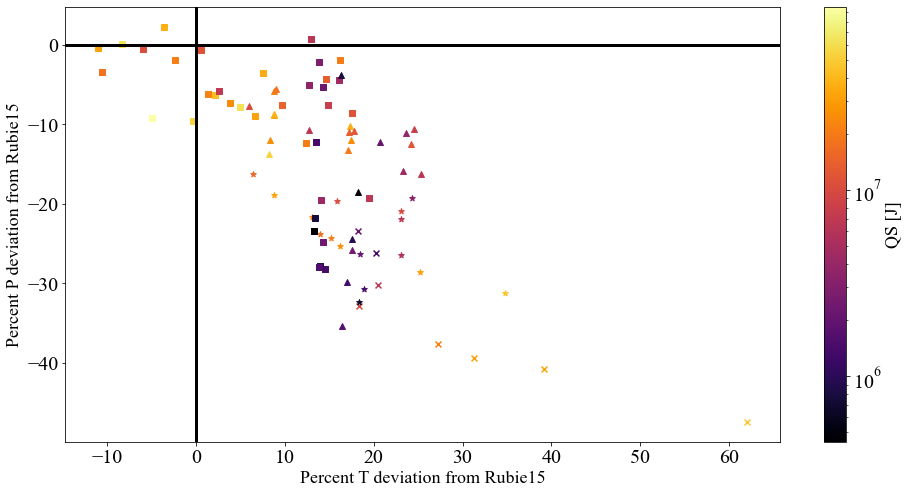

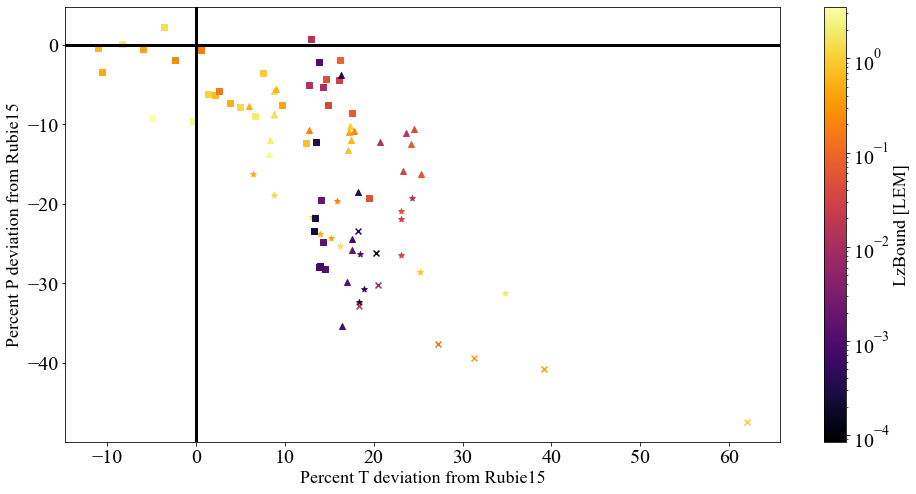

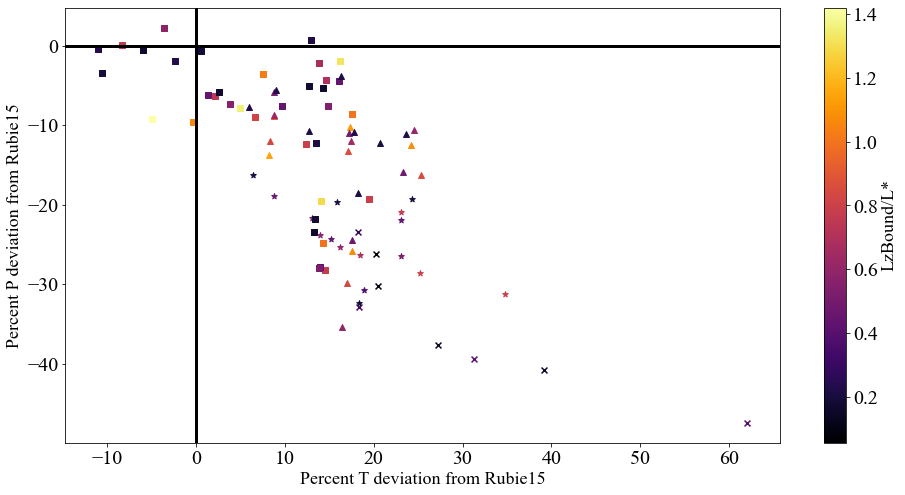

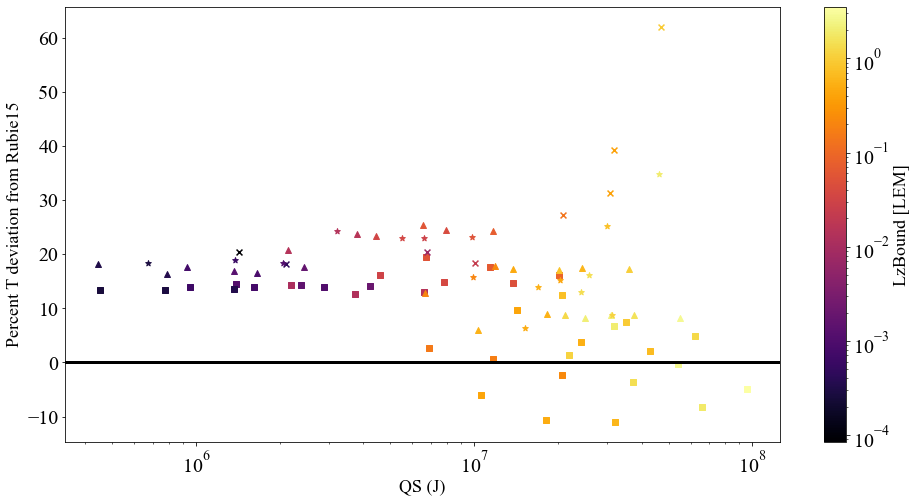

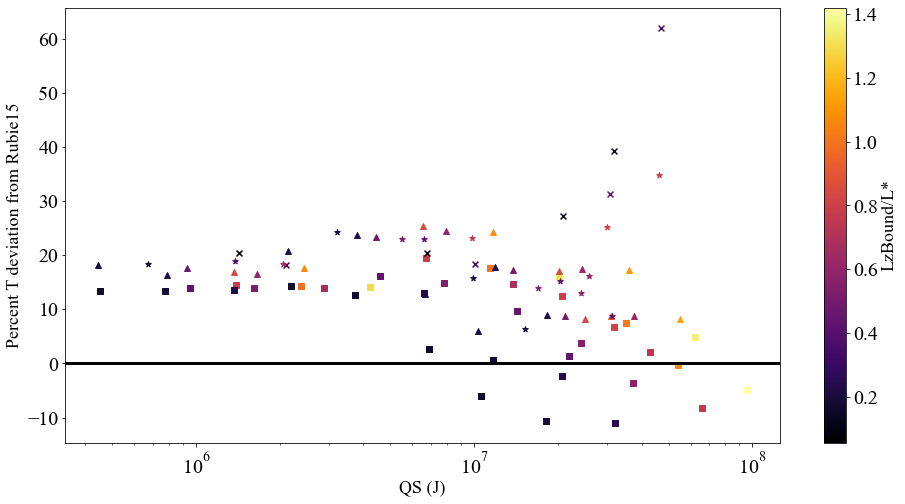

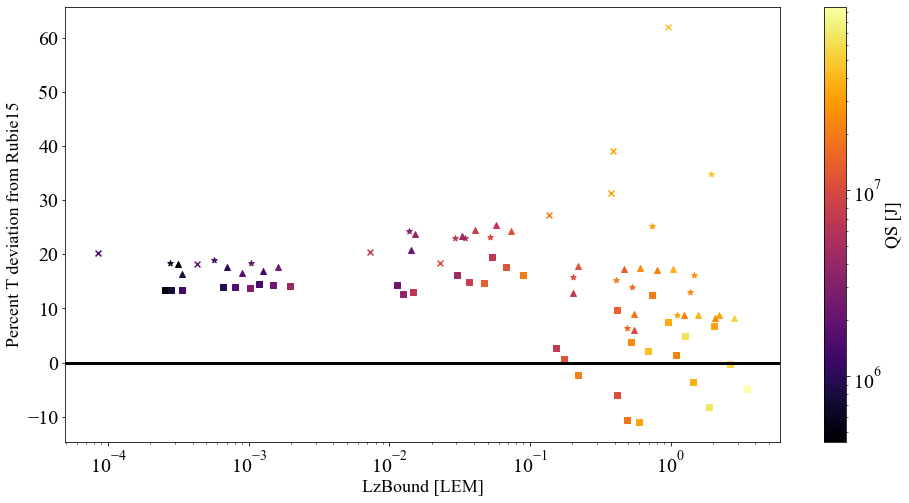

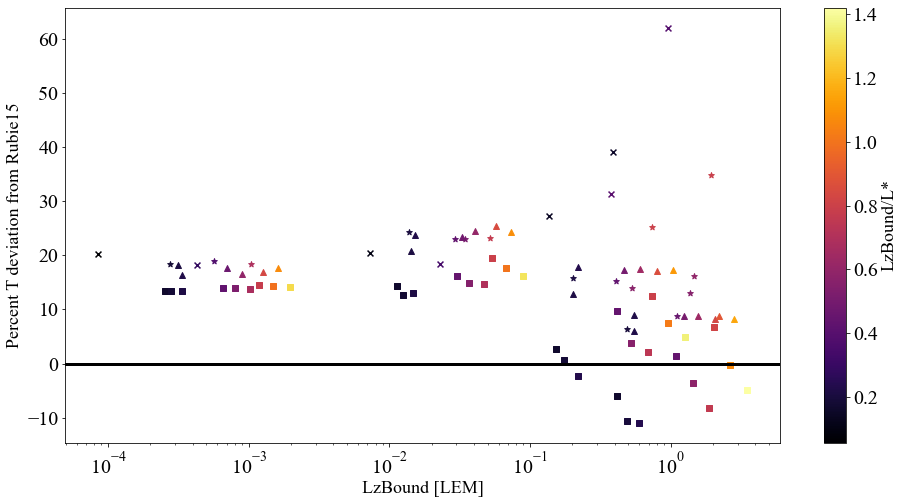

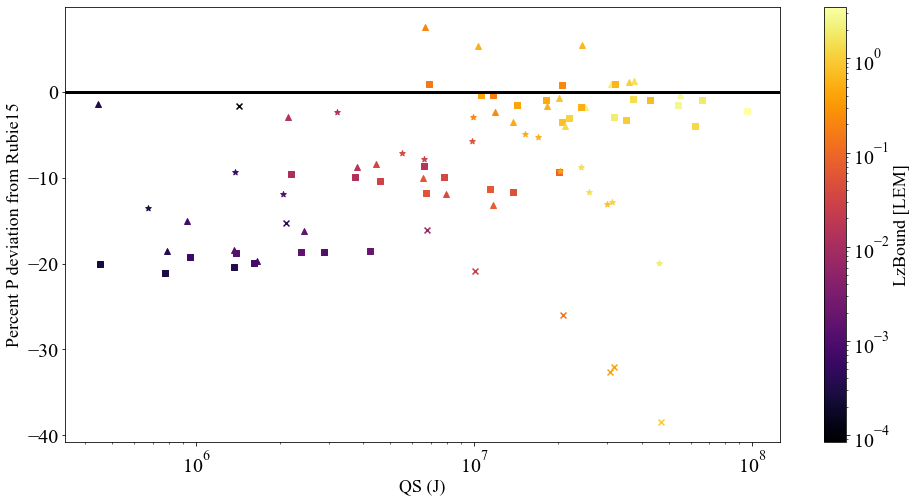

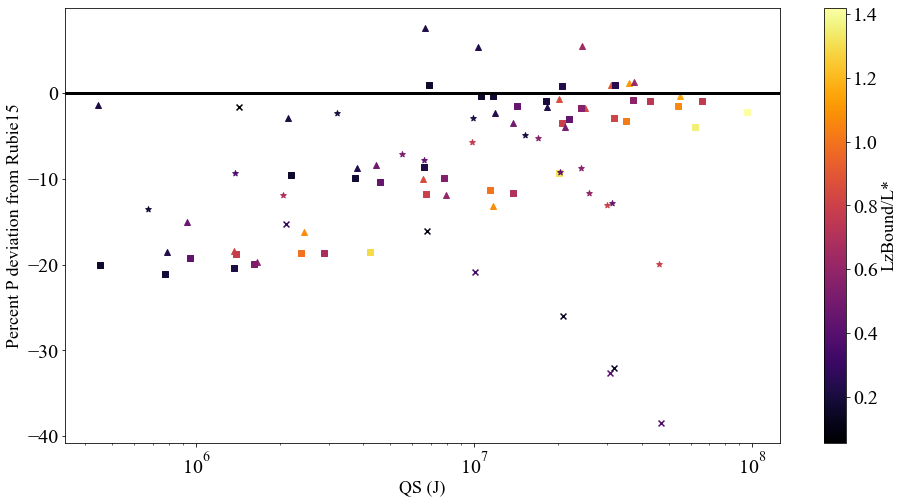

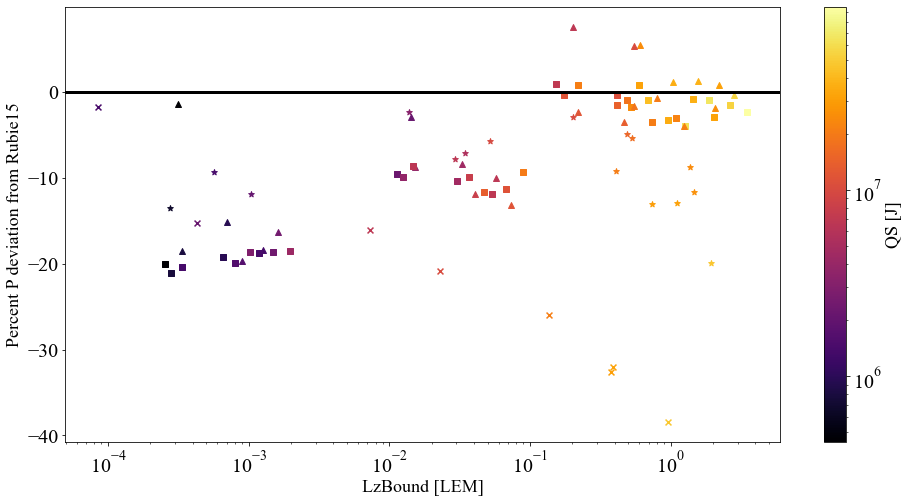

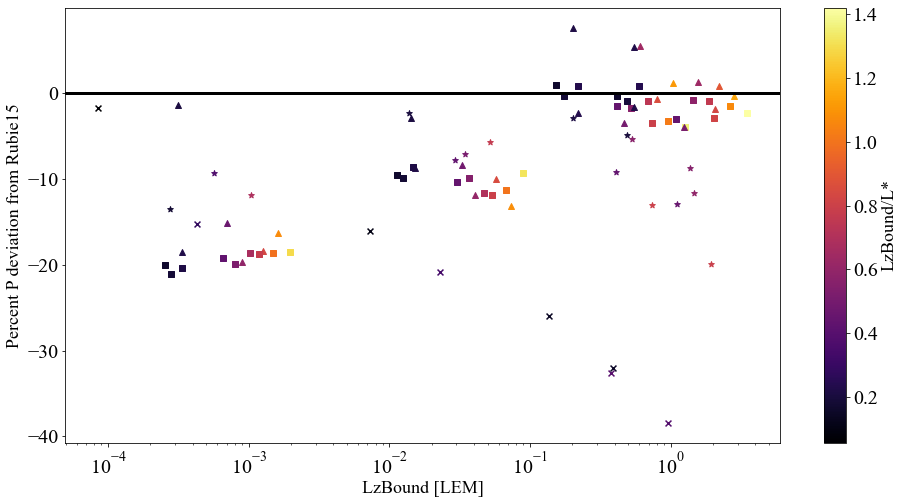

In [38]:
dPT_rubie([hitandrunlist],labels=None,colors='QS',legend=False,markers='theta',fP=.73)
dPT_rubie([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',fP=.73)
dPT_rubie([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

T_rubie_QS([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',fP=.73)
T_rubie_QS([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

T_rubie_Lz([hitandrunlist],labels=None,colors='QS',legend=False,markers='theta',fP=.73)
T_rubie_Lz([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True,fP=.73)

P_rubie_QS([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
P_rubie_QS([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)

P_rubie_Lz([hitandrunlist],labels=None,colors='QS',legend=False,markers='theta')
P_rubie_Lz([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)

## Compared to initial profiles
### All data
Icon legend:
'o' = accretion
'+' = partial accretion
'x' = hit-and-run

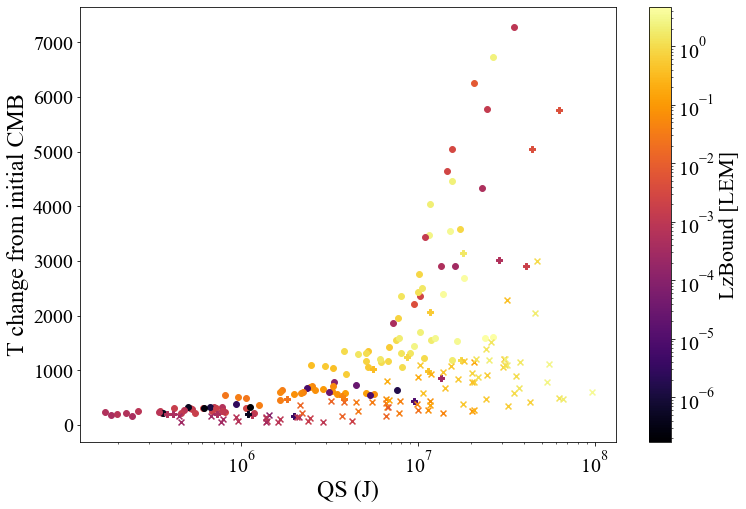

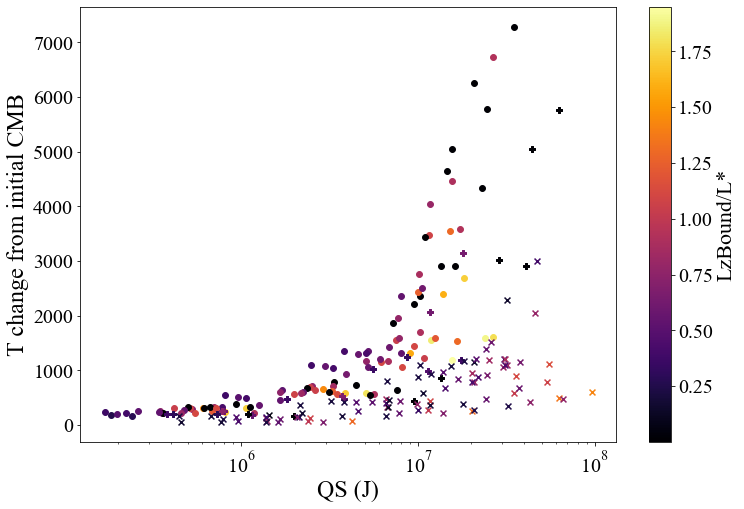

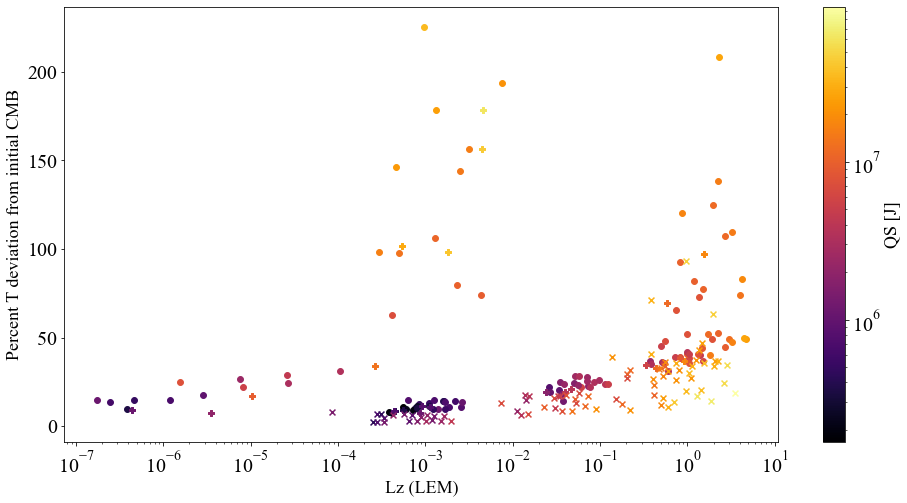

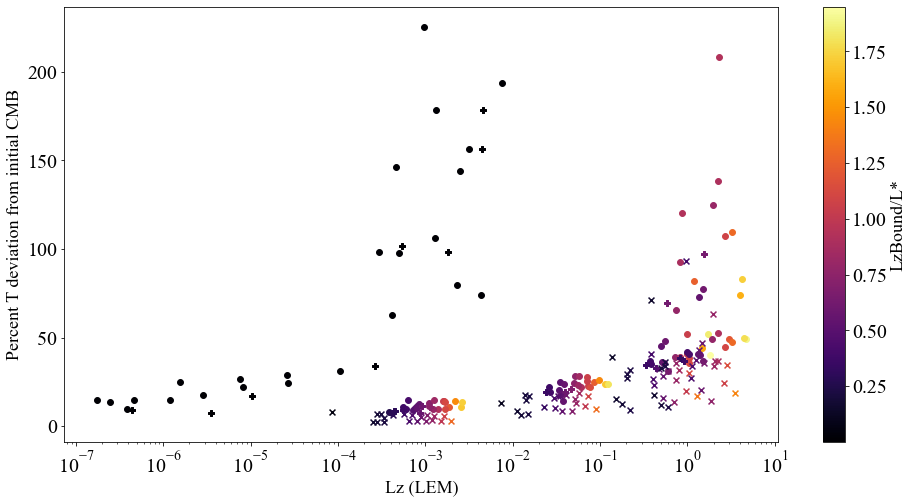

In [39]:
deltaT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',normalize=True)
#dT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome')
deltaT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',normalize=True,Lzstar=True)
#dT_CMB_QS([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',legend=False,markers='outcome',normalize=True)
#dT_CMB_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dT_CMB_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',legend=False,markers='outcome',normalize=True,Lzstar=True)
#dT_CMB_Lz([accretionlist,partialaccretionlist,hitandrunlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)

### Accretionary data
Icon legend: \
'o' = Theta = 0 \
'+' = Theta = 20 \
'x' = Theta = 30 \
'☆' = Theta = 45 \
'□' = Theta = 60

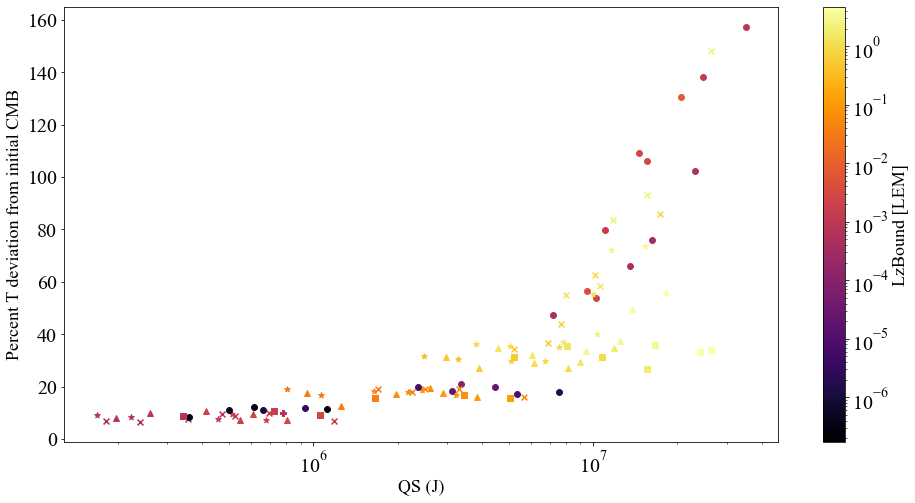

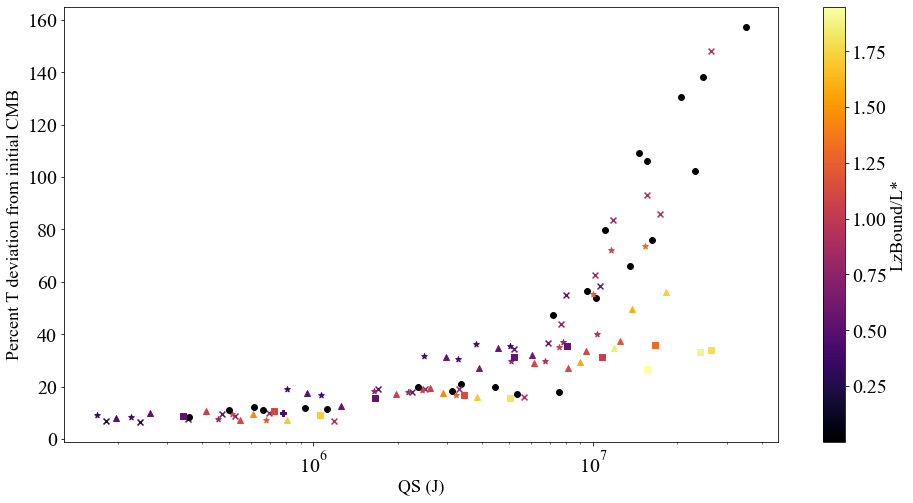

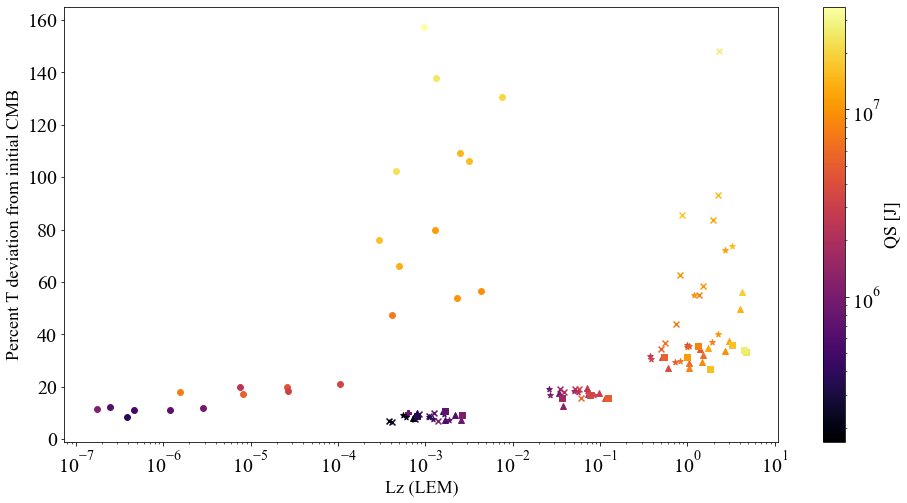

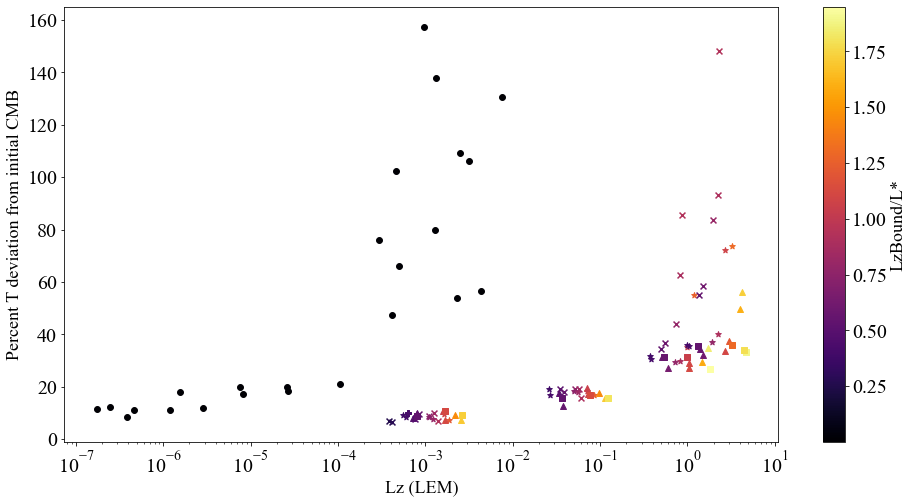

In [40]:
dT_CMB_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='theta')
#dT_CMB_QS([accretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome')
dT_CMB_QS([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
#dT_CMB_QS([accretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlist],labels=None,colors='QS',legend=False,markers='theta')
#dT_CMB_Lz([accretionlist],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dT_CMB_Lz([accretionlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
#dT_CMB_Lz([accretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)

### Accretionary data (without head-on impacts)

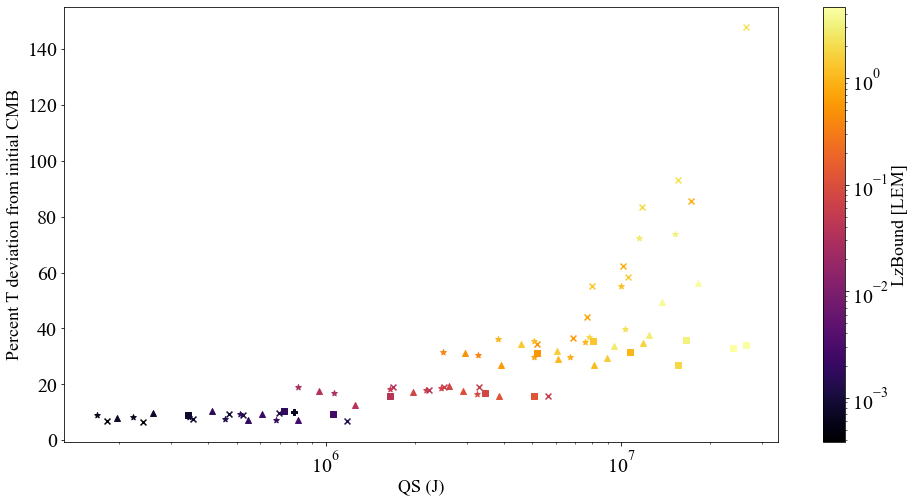

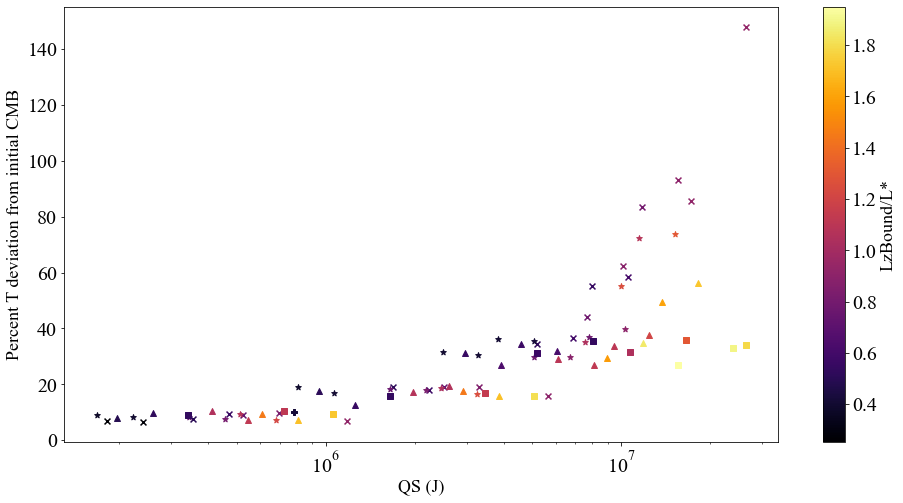

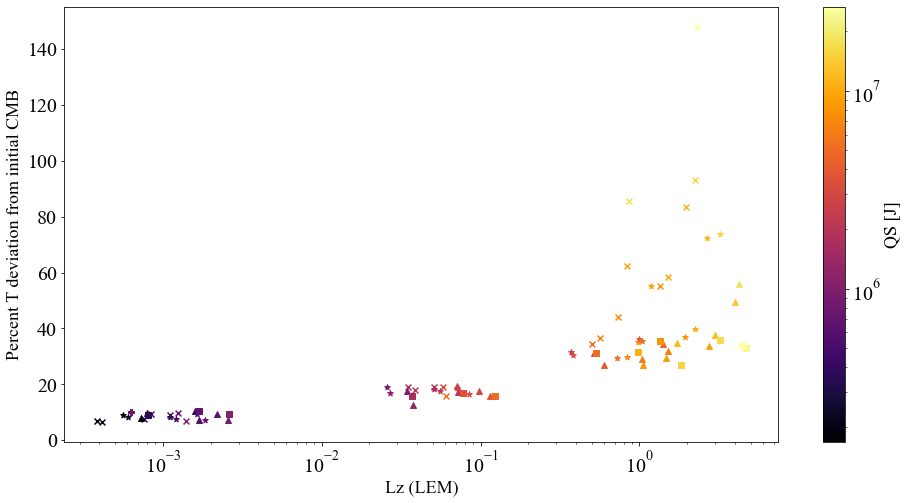

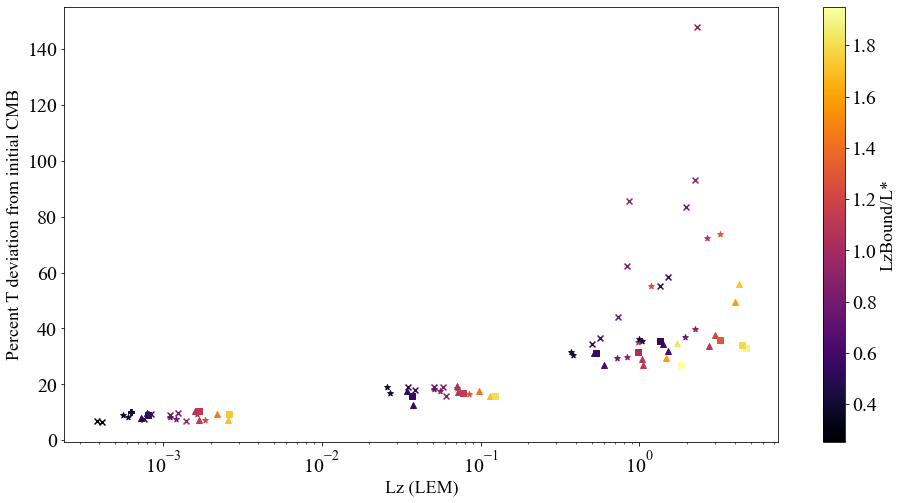

In [41]:
dT_CMB_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta')
#dT_CMB_QS([accretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome')
dT_CMB_QS([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
#dT_CMB_QS([accretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([accretionlistno0],labels=None,colors='QS',legend=False,markers='theta')
#dT_CMB_Lz([accretionlist],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dT_CMB_Lz([accretionlistno0],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
#dT_CMB_Lz([accretionlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)

### Fitting accretionary data by angle

polynomial coefficients, n...0 :  [ 0.3510198  -3.81135465 12.77685219]
R^2 value:  [0.93014164]
polynomial coefficients, n...0 :  [ 0.27161377 -2.69770032  8.94218851]
R^2 value:  [0.94559189]
polynomial coefficients, n...0 :  [ 0.17782944 -1.59450823  5.79274207]
R^2 value:  [0.93498416]
polynomial coefficients, n...0 :  [ 0.12614779 -1.03635189  4.26738824]
R^2 value:  [0.92734193]
polynomial coefficients, n...0 :  [ 3.77377203e-04  4.81442650e-01 -3.50520548e-01]
R^2 value:  [0.94084245]


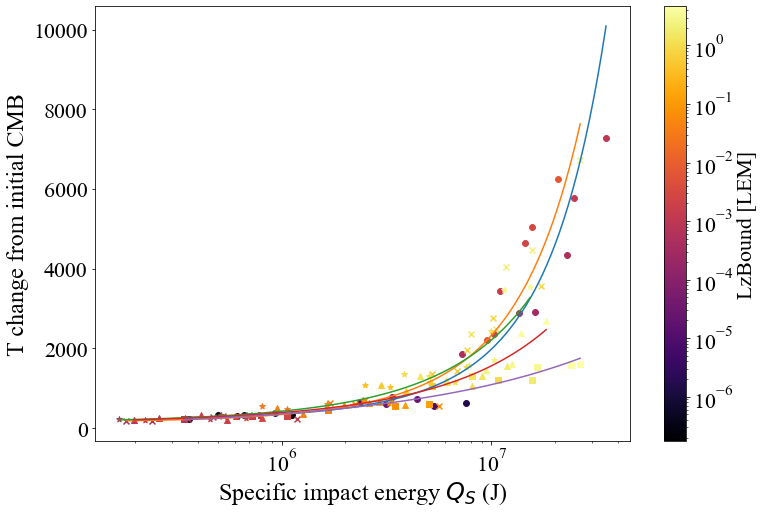

polynomial coefficients, n...0 :  [ 0.3510198  -3.81135465 12.77685219]
R^2 value:  [0.93014164]
polynomial coefficients, n...0 :  [ 0.27161377 -2.69770032  8.94218851]
R^2 value:  [0.94559189]
polynomial coefficients, n...0 :  [ 0.17782944 -1.59450823  5.79274207]
R^2 value:  [0.93498416]
polynomial coefficients, n...0 :  [ 0.12614779 -1.03635189  4.26738824]
R^2 value:  [0.92734193]
polynomial coefficients, n...0 :  [ 3.77377203e-04  4.81442650e-01 -3.50520548e-01]
R^2 value:  [0.94084245]


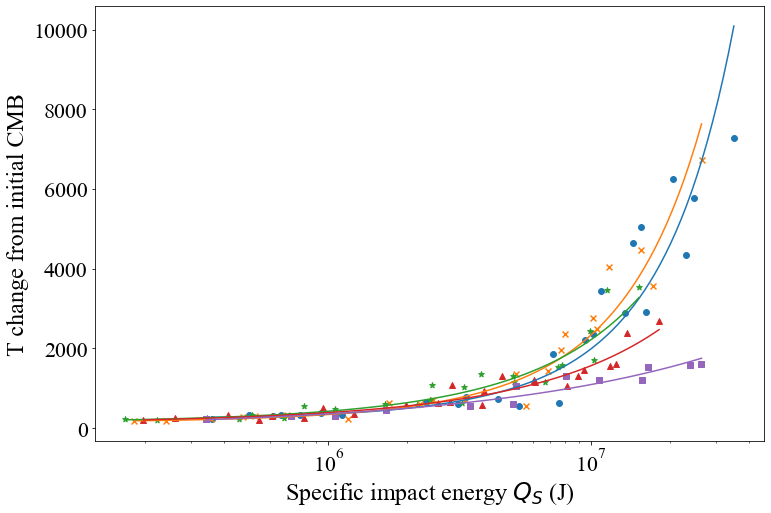

polynomial coefficients, n...0 :  [ 0.77941896 -2.10210574]
R^2 value:  [0.88810828]
polynomial coefficients, n...0 :  [ 0.74092276 -1.82651996]
R^2 value:  [0.90885953]
polynomial coefficients, n...0 :  [ 0.62168491 -1.05293358]
R^2 value:  [0.91466872]
polynomial coefficients, n...0 :  [ 0.55482447 -0.70790958]
R^2 value:  [0.9144015]
polynomial coefficients, n...0 :  [ 0.48637254 -0.36648513]
R^2 value:  [0.94084229]


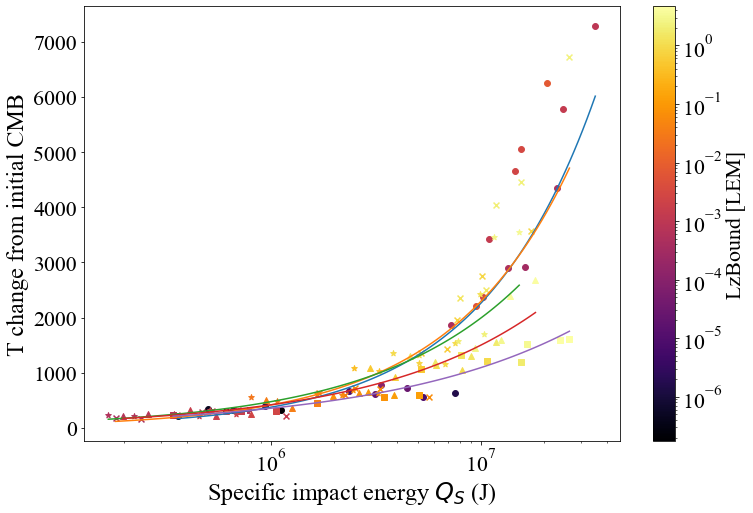

polynomial coefficients, n...0 :  [ 0.77941896 -2.10210574]
R^2 value:  [0.88810828]
polynomial coefficients, n...0 :  [ 0.74092276 -1.82651996]
R^2 value:  [0.90885953]
polynomial coefficients, n...0 :  [ 0.62168491 -1.05293358]
R^2 value:  [0.91466872]
polynomial coefficients, n...0 :  [ 0.55482447 -0.70790958]
R^2 value:  [0.9144015]
polynomial coefficients, n...0 :  [ 0.48637254 -0.36648513]
R^2 value:  [0.94084229]


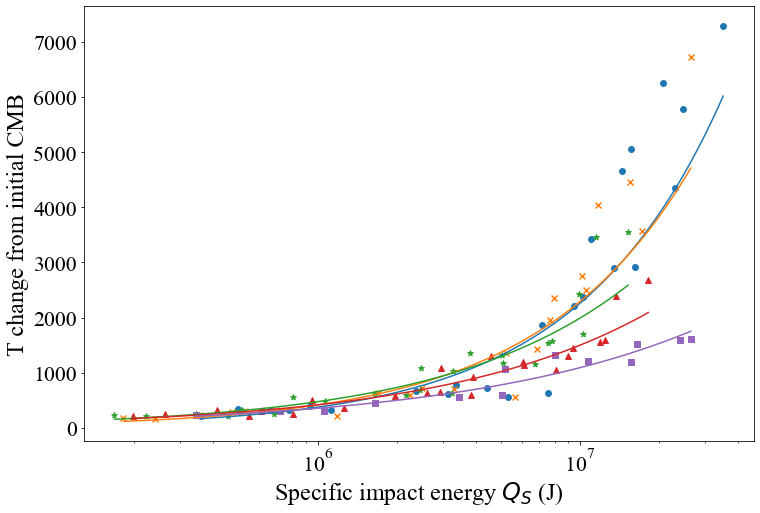

polynomial coefficients, n...0 :  [ 0.3510198  -3.81135465 12.77685219]
R^2 value:  [0.93014164]
polynomial coefficients, n...0 :  [ 0.27161377 -2.69770032  8.94218851]
R^2 value:  [0.94559189]
polynomial coefficients, n...0 :  [ 0.17782944 -1.59450823  5.79274207]
R^2 value:  [0.93498416]
polynomial coefficients, n...0 :  [ 0.12614779 -1.03635189  4.26738824]
R^2 value:  [0.92734193]
polynomial coefficients, n...0 :  [ 3.77377203e-04  4.81442650e-01 -3.50520548e-01]
R^2 value:  [0.94084245]


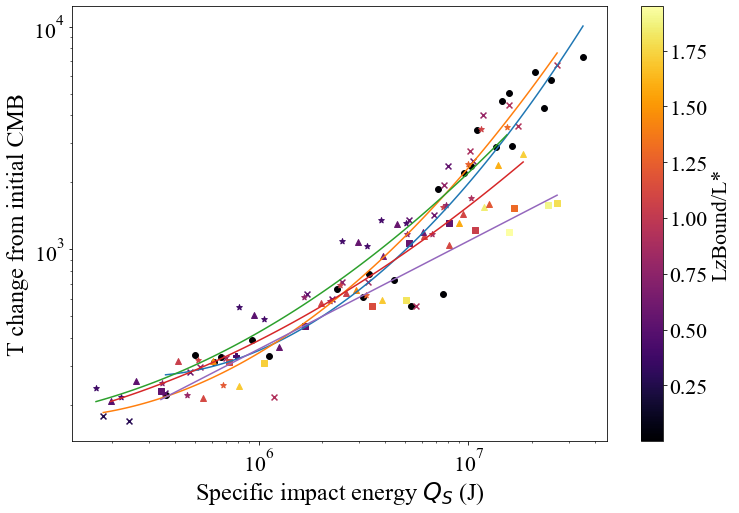

polynomial coefficients, n...0 :  [ 0.3510198  -3.81135465 12.77685219]
R^2 value:  [0.93014164]
polynomial coefficients, n...0 :  [ 0.27161377 -2.69770032  8.94218851]
R^2 value:  [0.94559189]
polynomial coefficients, n...0 :  [ 0.17782944 -1.59450823  5.79274207]
R^2 value:  [0.93498416]
polynomial coefficients, n...0 :  [ 0.12614779 -1.03635189  4.26738824]
R^2 value:  [0.92734193]
polynomial coefficients, n...0 :  [ 3.77377203e-04  4.81442650e-01 -3.50520548e-01]
R^2 value:  [0.94084245]


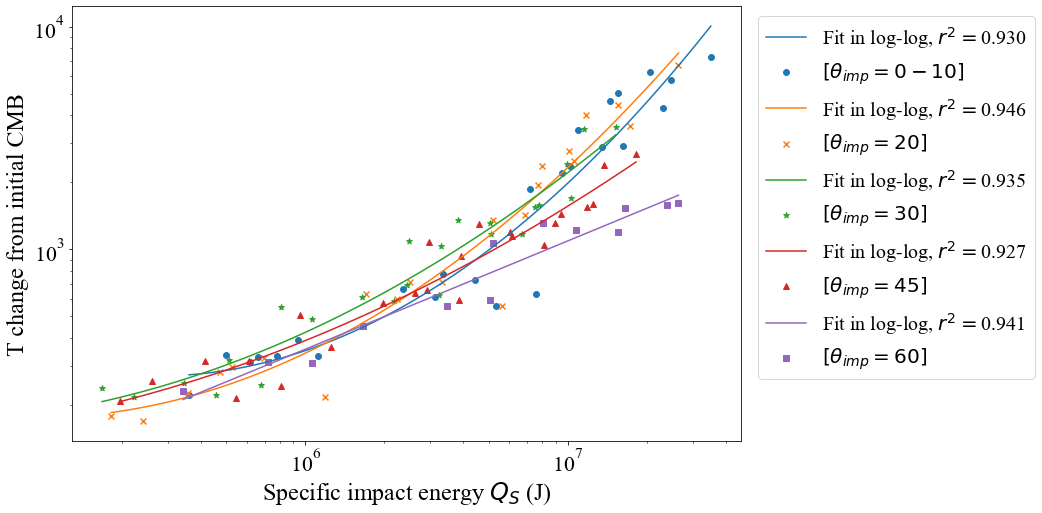

polynomial coefficients, n...0 :  [ 0.77941896 -2.10210574]
R^2 value:  [0.88810828]
polynomial coefficients, n...0 :  [ 0.74092276 -1.82651996]
R^2 value:  [0.90885953]
polynomial coefficients, n...0 :  [ 0.62168491 -1.05293358]
R^2 value:  [0.91466872]
polynomial coefficients, n...0 :  [ 0.55482447 -0.70790958]
R^2 value:  [0.9144015]
polynomial coefficients, n...0 :  [ 0.48637254 -0.36648513]
R^2 value:  [0.94084229]


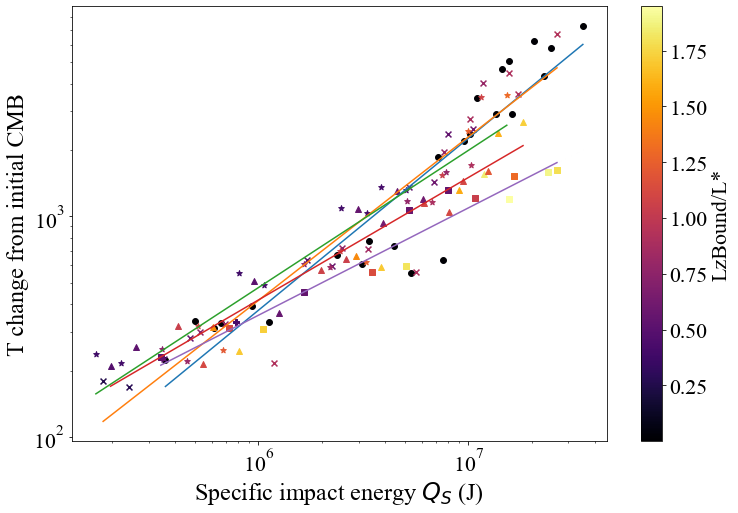

polynomial coefficients, n...0 :  [ 0.77941896 -2.10210574]
R^2 value:  [0.88810828]
polynomial coefficients, n...0 :  [ 0.74092276 -1.82651996]
R^2 value:  [0.90885953]
polynomial coefficients, n...0 :  [ 0.62168491 -1.05293358]
R^2 value:  [0.91466872]
polynomial coefficients, n...0 :  [ 0.55482447 -0.70790958]
R^2 value:  [0.9144015]
polynomial coefficients, n...0 :  [ 0.48637254 -0.36648513]
R^2 value:  [0.94084229]


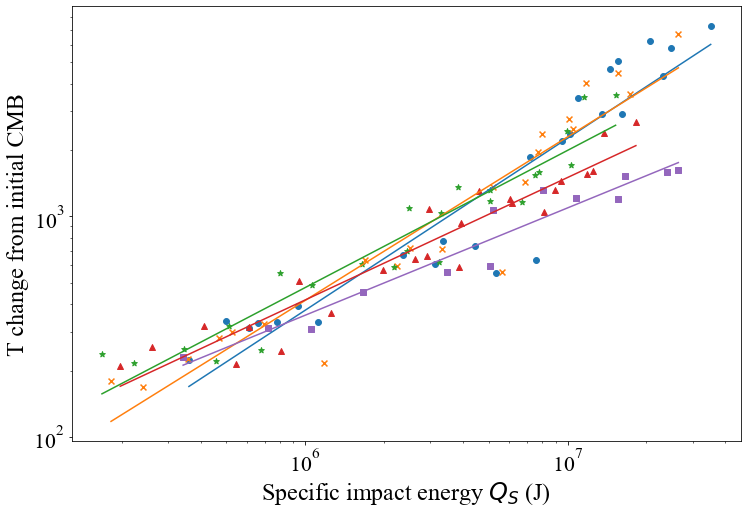

array([[ 0.77941896, -2.10210574],
       [ 0.74092276, -1.82651996],
       [ 0.62168491, -1.05293358],
       [ 0.55482447, -0.70790958],
       [ 0.48637254, -0.36648513]])

In [71]:
deltafitlist2d = deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)
deltafitlist1d = deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)

deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True,legend=True,markers='theta',Lzstar=True,normalize=True,logfit=2)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)
deltaT_CMB_QS([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=thetalabels,loglog=True,legend=False,markers='theta',Lzstar=True,normalize=True,logfit=1)

### Linear regression fits for log-log polynomial coefficients
Linear:

Fitting polynomial y = K_1(x) + K_0
Polynomial coefficient K_1 regression fit [-0.00521768  0.79839274]
R^2 value:  [0.94991235]


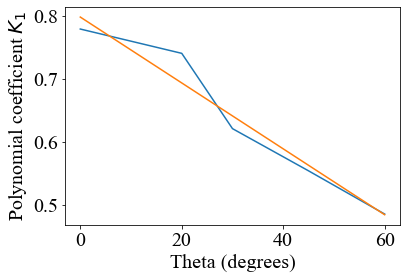

Polynomial coefficient K_0 regression fit [ 0.03102412 -2.17293843]
R^2 value:  [0.94282791]


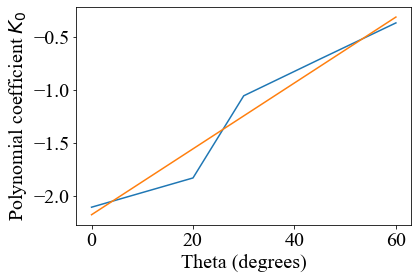

[[-0.00521768  0.79839274]
 [ 0.03102412 -2.17293843]]


In [43]:
thetalist = np.array([0, 20, 30, 45, 60])

def plot_theta_fits(fitlist,regfit=1):
    thetalist = np.array([0, 20, 30, 45, 60])
    nfit=np.size(fitlist[0,:])
    fitstring='Fitting polynomial y = '
    allfits = np.zeros([np.size(fitlist[0,:]),regfit+1])
    for i in range(nfit):
        fitstring=fitstring+'K_%g'%(nfit-i-1)
        if i<(nfit-2): fitstring=fitstring+'(x^%g) '%(nfit-i-1)
        elif i<(nfit-1): fitstring=fitstring+'(x) '
        if i<(nfit-1):fitstring=fitstring+'+ '
    print(fitstring)
    for i in range(nfit):
        fit,residuals,rank,singular_values,rcond=np.polyfit(thetalist,fitlist[:,i],regfit,full=True)
        print('Polynomial coefficient K_%g regression fit'%(nfit-i-1),fit)
        print('R^2 value: ',1-residuals/np.sum((fitlist[:,i]-np.mean(fitlist[:,i]))**2))
        allfits[i,:]=fit
        space=np.linspace(thetalist[0],thetalist[-1],50)
        fitfn=np.poly1d(fit)
        plt.plot(thetalist,fitlist[:,i])
        plt.plot(space,fitfn(space))
        plt.gca().set_xlabel('Theta (degrees)',size=20)
        plt.gca().set_ylabel(r'Polynomial coefficient $K_{%g}$'%(nfit-i-1),size=20)
        plt.show()
    return allfits

#print(np.size(deltafitlist1d[0,:]))
testfit=plot_theta_fits(deltafitlist1d)
print(testfit)

Quadratic:

(5, 3)
Fitting polynomial y = K_2(x^2) + K_1(x) + K_0
Polynomial coefficient K_2 regression fit [-0.00578782  0.3648201 ]
R^2 value:  [0.97733935]


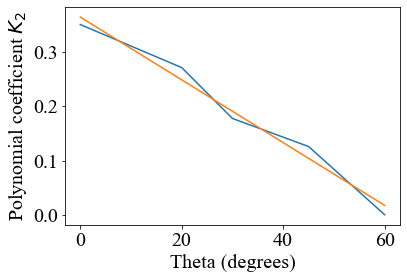

Polynomial coefficient K_1 regression fit [ 0.07022364 -3.90862732]
R^2 value:  [0.98086319]


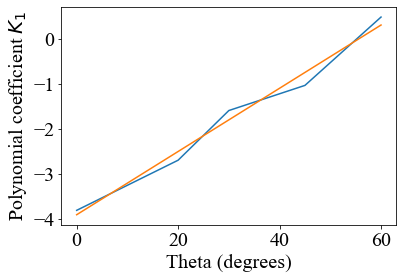

Polynomial coefficient K_0 regression fit [-0.21257589 12.87558279]
R^2 value:  [0.98207694]


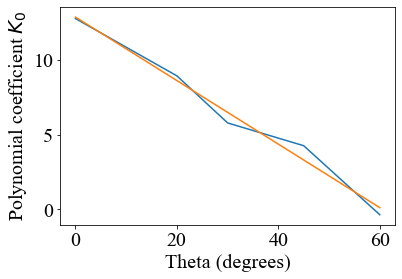

[[-5.78782149e-03  3.64820101e-01]
 [ 7.02236398e-02 -3.90862732e+00]
 [-2.12575893e-01  1.28755828e+01]]
3


In [44]:
print(np.shape(deltafitlist2d))
quadfit=plot_theta_fits(deltafitlist2d)
print(quadfit)
print(np.size(quadfit[:,0]))

In [45]:
def logdeltaT3D(QS,theta,fitlist):
    logdeltaT=0
    nfit=np.size(fitlist[:,0])
    #print(nfit)
    for i in range(nfit):
        coeff=0
        fitsize=np.size(fitlist[i,:])
        #print(fitsize)
        for j in range(fitsize):
            coeff+=fitlist[i,j]*(theta**(fitsize-1-j))
            #print(coeff)
        logdeltaT+=coeff*(np.log10(QS)**(nfit-1-i))
    return logdeltaT

vlogdeltaT3D=np.vectorize(logdeltaT3D,excluded=[2])
print(np.power(10,logdeltaT3D(1.e7,0,quadfit)))

2462.5014546467096


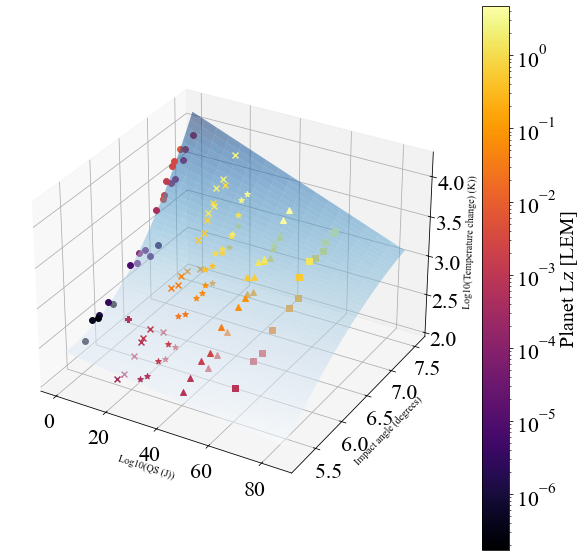

In [72]:
#%matplotlib widget
def deltaT_CMB_QS3D(simlistlist,labels=None,xlim=None,star=False,loglog=False,markers=None,legend=True,colors=None,Lzstar=False,normalize=False,logfit=False,fitlist=quadfit):
    if logfit==True:
        logfit=1
    fig = plt.figure(1,figsize=(10,10))
    ax = plt.axes(projection='3d',computed_zorder=False)
    count=0
    allQS=np.array([])
    allLz=np.array([])
    allfits = np.zeros([np.shape(simlistlist)[0],logfit+1])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        Lzs=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            QSs[j] = sim.QS
            allLz=np.append(allLz,Lzs[j])
            allQS=np.append(allQS,QSs[j])
    if colors=='Lz': 
        if Lzstar: pltnorm=Normalize(vmin=np.amin(allLz),vmax=np.amax(allLz))
        else: pltnorm=LogNorm(vmin=np.amin(allLz),vmax=np.amax(allLz))
    if colors=='QS': pltnorm=LogNorm(vmin=np.amin(allQS),vmax=np.amax(allQS))
        
    QSfield=np.logspace(np.log10(np.amin(allQS)),np.log10(np.amax(allQS)))
    thetafield=np.arange(0,90,5)
    thetafield,QSfield = np.meshgrid(thetafield,QSfield)
    Z=vlogdeltaT3D(QSfield,thetafield,fitlist)
    #Z=np.power(10,vlogdeltaT3D(QSfield,thetafield,fitlist))
    
    #ax.set_zscale('log')
    
    overlist=np.array([])
    for i in range(np.shape(simlistlist)[0]):
        simlist = simlistlist[i]
        DTplanets=np.zeros(np.size(simlist))
        DPplanets=np.zeros(np.size(simlist))
        QSs=np.zeros(np.size(simlist))
        Lzs=np.zeros(np.size(simlist))
        thetas=np.zeros(np.size(simlist))
        for j in range(np.size(simlist)):
            sim=simlist[j]
            if markers=='theta':marker=sim.thetamarker
            elif markers=='size':marker=sim.sizemarker
            elif markers=='ratio':marker=sim.ratiomarker
            elif markers=='outcome':marker=sim.outcomemarker
            if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
            if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/(sim.M_t/sim.Mbound[-1])
            else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
            thetas[j] = sim.theta
            if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
            else: Lzs[j]=sim.Lzbnd[-1]
            if star:
                QSs[j] = sim.QstarS
                #logallQS=np.append(logallQS,np.log10(sim.QstarS))
            else:
                QSs[j] = sim.QS
                #logallQS=np.append(logallQS,np.log10(sim.QS))
            if labels is None:
                if colors is not None:
                    if colors=='Lz':c=Lzs[j]
                    if colors=='QS':c=QSs[j]
                    if logdeltaT3D(QSs[j],thetas[j],fitlist)<np.log10(DTplanets[j]):
                        overlist=np.append(overlist,sim)
                    else:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
                else:
                    if logdeltaT3D(QSs[j],thetas[j],fitlist)<np.log10(DTplanets[j]):
                        overlist=np.append(overlist,sim)
                    else:
                        ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
                count+=1
        
        if labels is not None:
            #if logfit:
            ax.scatter(thetas,np.log10(QSs),np.log10(DTplanets),label=labels[i],s=35,marker=marker)
    ax.plot_surface(thetafield,np.log10(QSfield),  Z,alpha=0.5,cmap='Blues')
    DTplanets=np.zeros(np.size(overlist))
    DPplanets=np.zeros(np.size(overlist))
    QSs=np.zeros(np.size(overlist))
    Lzs=np.zeros(np.size(overlist))
    thetas=np.zeros(np.size(overlist))
    for j in range(np.size(overlist)):
        sim=overlist[j]
        if markers=='theta':marker=sim.thetamarker
        elif markers=='size':marker=sim.sizemarker
        elif markers=='ratio':marker=sim.ratiomarker
        elif markers=='outcome':marker=sim.outcomemarker
        if markers is None:marker=markerlist[(count//10)%np.size(markerlist)]
        if normalize: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)/(sim.M_t/sim.Mbound[-1])
        else: DTplanets[j] = (sim.TCMBmean - sim.TCMB0mant)
        thetas[j] = sim.theta
        if Lzstar: Lzs[j]=sim.Lzbnd[-1]/sim.Lzstar
        else: Lzs[j]=sim.Lzbnd[-1]
        if star:
            QSs[j] = sim.QstarS
            #logallQS=np.append(logallQS,np.log10(sim.QstarS))
        else:
            QSs[j] = sim.QS
            #logallQS=np.append(logallQS,np.log10(sim.QS))
        if labels is None:
            if colors is not None:
                if colors=='Lz':c=Lzs[j]
                if colors=='QS':c=QSs[j]
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker,c=c,cmap='inferno',norm=pltnorm)
            else:
                ax.scatter(thetas[j],np.log10(QSs[j]),np.log10(DTplanets[j]),label=sim.label,s=35,marker=marker)
            count+=1
    
    if colors is not None:
        cbar=plt.colorbar(cm.ScalarMappable(norm=pltnorm, cmap='inferno'), ax=ax)
        if colors=='Lz':
            if Lzstar:cbar.set_label('LzBound/L*',size=20)
            else:cbar.set_label('Planet Lz [LEM]',size=20)
        if colors=='QS':cbar.set_label('QS [J]',size=20)
    ax.set_xlabel('Log10(QS (J))',size=10)
    ax.set_ylabel('Impact angle (degrees)',size=10)
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel('Log10(Temperature change) (K))',size=10)
    
    plt.show()
    
deltaT_CMB_QS3D([accretion010list,accretion20list,accretion30list,accretion45list,accretion60list],labels=None,colors='Lz',legend=False,markers='theta',normalize=True,fitlist=quadfit)

Although the R^2 values for the individual linear fits aren't bad, I think the fact that the quadratic log-log fits have clear relationships between the best fit polynomial coefficients and angles means that a second-order log-log fit is the bettter option for a predictive deltaT model.

### Hit-and-run data

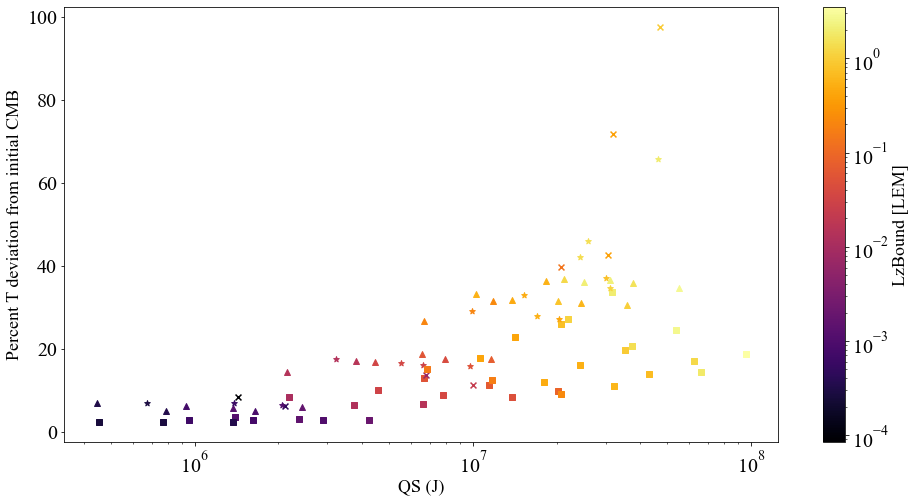

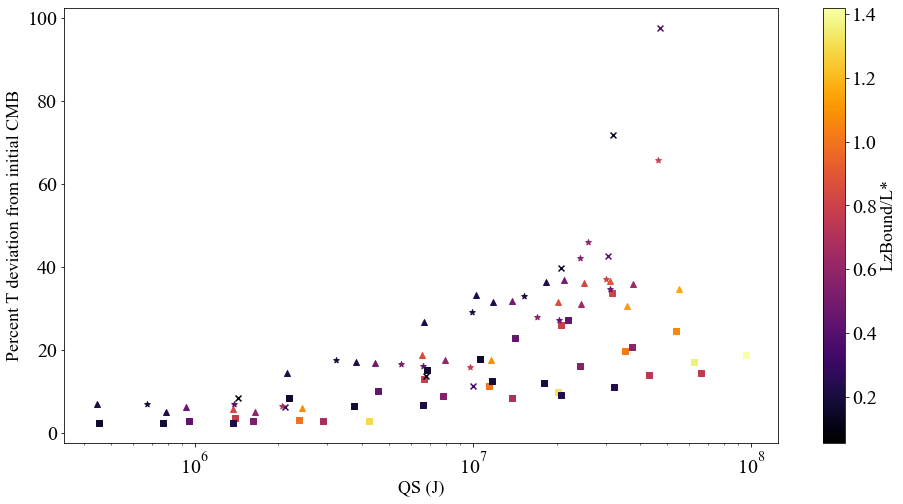

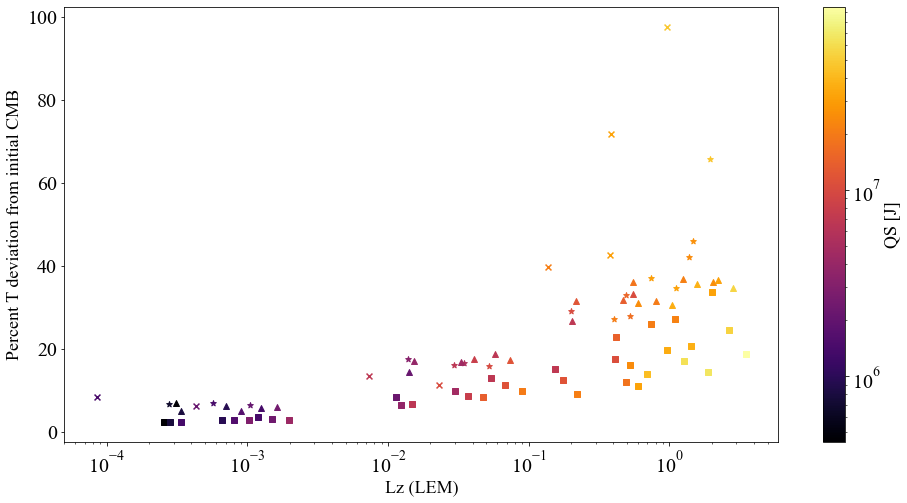

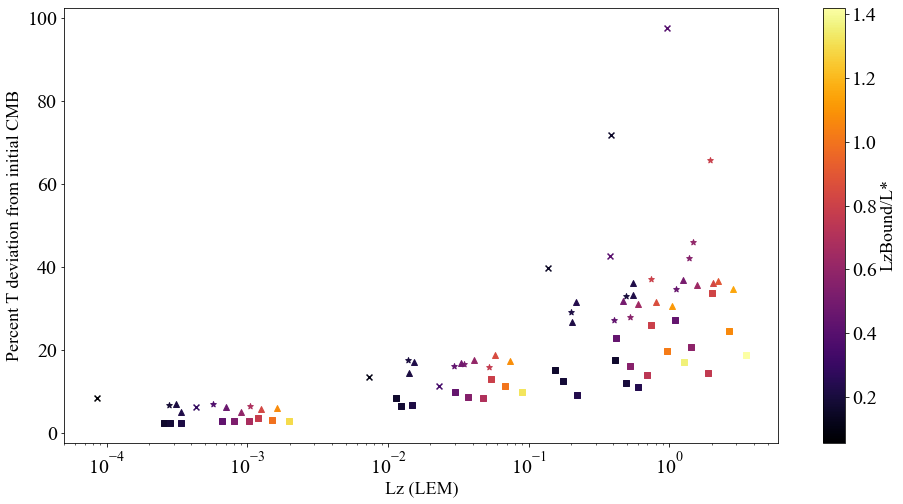

In [47]:
dT_CMB_QS([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta')
#dT_CMB_QS([hitandrunlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome')
dT_CMB_QS([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
#dT_CMB_QS([hitandrunlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)
dT_CMB_Lz([hitandrunlist],labels=None,colors='QS',legend=False,markers='theta')
#dT_CMB_Lz([hitandrunlist],labels=None,colors='QS',loglog=True,legend=False,markers='outcome')
dT_CMB_Lz([hitandrunlist],labels=None,colors='Lz',legend=False,markers='theta',Lzstar=True)
#dT_CMB_Lz([hitandrunlist],labels=None,colors='Lz',loglog=True,legend=False,markers='outcome',Lzstar=True)